# Projet IPEO

### Data loading

In [1]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

Device utilisé : cuda
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000
Nombre d'images (val) : 2000
Nombre d'images (test) : 2000


/home/calvo/IPEO_production/scitas_venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8608187..2.2941449].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9874357..2.5133271].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.277375..3.4887497].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7975103..2.8264449].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6075847..5.7071285].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2277337..2.437659].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.032026..5.20614].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9874357..2.2628329].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3039782..5.20614].


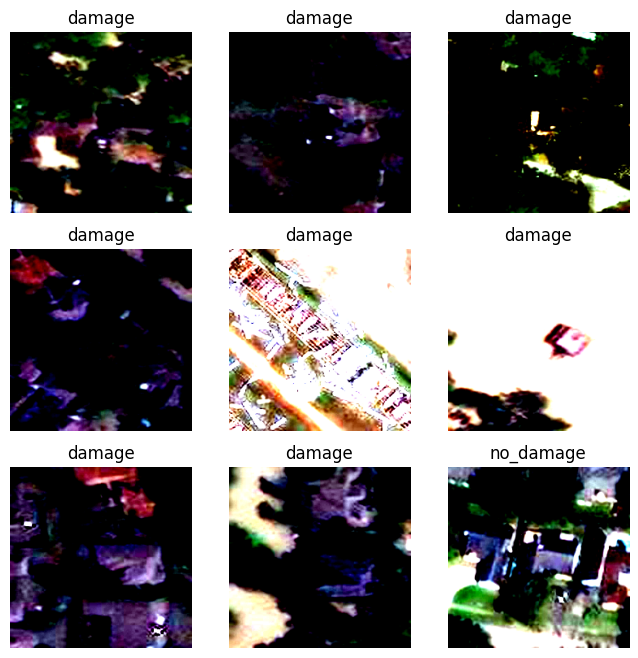

In [2]:
base_dir = "ipeo_hurricane_for_students"

mean = torch.tensor([0.3520655930042267, 0.3834735155105591, 0.28522437810897827])
std = torch.tensor([0.14353738725185394, 0.12388758361339569, 0.12524260580539703])

normalize = T.Normalize(mean, std)

default_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])


train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS (2 dans le cours)
# à voir si on garde ça comme ça
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds))
print("Nombre d'images (val) :", len(val_ds))
print("Nombre d'images (test) :", len(test_ds))

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [3]:
from torchvision.models import resnet34, mobilenet_v3_small


# load a resnet34 with 2 classes (damage vs no_damage) and move to device
model_resnet = resnet34(num_classes=2).to(device)
model_resnet

# load a mobilnet_v3_small with 2 classes (damage vs no_damage) and move to device
model_mobilenet = mobilenet_v3_small(num_classes=2).to(device)
model_mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss function with Class Balancing

In [4]:
# Compute class weights to handle imbalanced dataset
from collections import Counter

def compute_class_weights(dataset, device):
    """Calcule les poids pour chaque classe (inverse de la fréquence)"""
    # Compter les occurrences de chaque classe
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    
    # Calculer les poids (inverse de la fréquence)
    total_samples = len(labels)
    num_classes = len(class_counts)
    class_weights = torch.zeros(num_classes)
    
    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (num_classes * count)
    
    return class_weights.to(device)

# Calculer les class weights sur le training set
class_weights = compute_class_weights(train_ds, device)
print(f"✓ Class weights computed:")
for i, weight in enumerate(class_weights):
    print(f"   Class {train_ds.classes[i]}: {weight:.4f}")

# Define the loss function with class weights
criterion = CrossEntropyLoss(weight=class_weights)

✓ Class weights computed:
   Class damage: 0.7308
   Class no_damage: 1.5833


### Optimizer

In [5]:
from torch.optim import SGD

learning_rate = 0.01

optimizer_resnet = SGD(model_resnet.parameters(),lr=learning_rate)
optimizer_mobilenet = SGD(model_mobilenet.parameters(),lr=learning_rate)

### Training step

In [6]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Training and validating over the full batch

In [7]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []
    total_batches = len(train_dl)
    print(f"Training: {total_batches} batches to process")

    for batch_idx, batch in enumerate(train_dl, 1):
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"  Batch {batch_idx}/{total_batches} - loss: {loss:.4f}, acc: {accuracy*100:.2f}%")

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

In [8]:
num_epochs = 50  # Augmentez à 50, early stopping arrêtera avant si nécessaire
import os
import json

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# ============ EARLY STOPPING CONFIGURATION ============
patience = 5  # Nombre d'epochs sans amélioration avant d'arrêter
min_delta = 0.001  # Amélioration minimale considérée (0.1%)
# ====================================================

# Vérifier si les modèles ET les stats existent
models_exist = (os.path.exists("models/mobilenet_test.pth") and 
                os.path.exists("models/resnet_test.pth") and 
                os.path.exists("models/stats_test.json"))

if models_exist:
    # Charger les modèles (map_location pour compatibilité CPU/GPU)
    model_mobilenet.load_state_dict(torch.load("models/mobilenet_test.pth", map_location=device))
    model_resnet.load_state_dict(torch.load("models/resnet_test.pth", map_location=device))
    print("✅ MobileNet loaded from models/mobilenet_test.pth")
    print("✅ ResNet loaded from models/resnet_test.pth")
    
    # Charger les stats
    with open("models/stats_test.json", "r") as f:
        saved_stats = json.load(f)
        stats_mobilenet = saved_stats["mobilenet"]
        stats_resnet = saved_stats["resnet"]
    print("✅ Stats loaded from models/stats_test.json")
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")
    train_models = False
else:
    print("🔄 Starting training (models or stats not found)...")
    print(f"⚙️  Early stopping enabled: patience={patience} epochs, min_delta={min_delta*100:.1f}%")
    train_models = True

# ENTRAÎNER SEULEMENT SI LES MODÈLES N'EXISTENT PAS
if train_models:
    # ============ TRAINING MOBILENET ============
    print(f"\n{'='*80}")
    print("TRAINING MOBILENET WITH EARLY STOPPING")
    print(f"{'='*80}")
    
    stats_mobilenet = []
    best_val_acc_mobilenet = 0
    patience_counter_mobilenet = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"MOBILENET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_mobilenet, trainaccuracy_mobilenet = train_epoch(train_loader, model_mobilenet, optimizer_mobilenet, device)
        valloss_mobilenet, valaccuracy_mobilenet = validate_epoch(val_loader, model_mobilenet, device)

        print(f"epoch {epoch}; trainloss {trainloss_mobilenet:.4f}, train accuracy {trainaccuracy_mobilenet*100:.2f}% | valloss {valloss_mobilenet:.4f}, val accuracy {valaccuracy_mobilenet*100:.2f}%")

        stats_mobilenet.append({
            "trainloss": float(trainloss_mobilenet),
            "trainaccuracy": float(trainaccuracy_mobilenet),
            "valloss": float(valloss_mobilenet),
            "valaccuracy": float(valaccuracy_mobilenet),
            "epoch": epoch
        })

        # ====== EARLY STOPPING LOGIC ======
        if valaccuracy_mobilenet > best_val_acc_mobilenet + min_delta:
            best_val_acc_mobilenet = valaccuracy_mobilenet
            patience_counter_mobilenet = 0
            # Sauvegarder le meilleur modèle
            torch.save(model_mobilenet.state_dict(), "models/mobilenet_test.pth")
            print(f"✅ New best val accuracy: {best_val_acc_mobilenet*100:.2f}% - Model saved!")
        else:
            patience_counter_mobilenet += 1
            print(f"⏱️  No improvement. Patience: {patience_counter_mobilenet}/{patience}")
            
            if patience_counter_mobilenet >= patience:
                print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
                print(f"   Best validation accuracy: {best_val_acc_mobilenet*100:.2f}%")
                break
        # ==================================

    print("✅ Mobilenet training completed (or early stopped)")

    # ============ TRAINING RESNET ============
    print(f"\n{'='*80}")
    print("TRAINING RESNET34 WITH EARLY STOPPING")
    print(f"{'='*80}")
    
    stats_resnet = []
    best_val_acc_resnet = 0
    patience_counter_resnet = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"RESNET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
        valloss_resnet, valaccuracy_resnet = validate_epoch(val_loader, model_resnet, device)

        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

        # ====== EARLY STOPPING LOGIC ======
        if valaccuracy_resnet > best_val_acc_resnet + min_delta:
            best_val_acc_resnet = valaccuracy_resnet
            patience_counter_resnet = 0
            # Sauvegarder le meilleur modèle
            torch.save(model_resnet.state_dict(), "models/resnet_test.pth")
            print(f"✅ New best val accuracy: {best_val_acc_resnet*100:.2f}% - Model saved!")
        else:
            patience_counter_resnet += 1
            print(f"⏱️  No improvement. Patience: {patience_counter_resnet}/{patience}")
            
            if patience_counter_resnet >= patience:
                print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
                print(f"   Best validation accuracy: {best_val_acc_resnet*100:.2f}%")
                break
        # ==================================

    print("✅ ResNet training completed (or early stopped)")
    
    # Save stats as JSON
    with open("models/stats.json", "w") as f:
        json.dump({"mobilenet": stats_mobilenet, "resnet": stats_resnet}, f)
    print("✅ Stats saved to models/stats.json")
else:
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")


🔄 Starting training (models or stats not found)...
⚙️  Early stopping enabled: patience=5 epochs, min_delta=0.1%

TRAINING MOBILENET WITH EARLY STOPPING

MOBILENET - Epoch 1/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.6932, acc: 68.75%


  Batch 20/1188 - loss: 0.6874, acc: 68.75%


  Batch 30/1188 - loss: 0.6540, acc: 81.25%


  Batch 40/1188 - loss: 0.6461, acc: 68.75%


  Batch 50/1188 - loss: 0.6450, acc: 62.50%


  Batch 60/1188 - loss: 0.6379, acc: 75.00%


  Batch 70/1188 - loss: 0.6214, acc: 75.00%


  Batch 80/1188 - loss: 0.6000, acc: 75.00%


  Batch 90/1188 - loss: 0.5682, acc: 81.25%


  Batch 100/1188 - loss: 0.6304, acc: 81.25%


  Batch 110/1188 - loss: 0.6267, acc: 81.25%


  Batch 120/1188 - loss: 0.5129, acc: 81.25%


  Batch 130/1188 - loss: 0.5238, acc: 81.25%


  Batch 140/1188 - loss: 0.4265, acc: 93.75%


  Batch 150/1188 - loss: 0.3488, acc: 100.00%


  Batch 160/1188 - loss: 0.6179, acc: 81.25%


  Batch 170/1188 - loss: 0.3796, acc: 93.75%


  Batch 180/1188 - loss: 0.7349, acc: 68.75%


  Batch 190/1188 - loss: 0.4976, acc: 75.00%


  Batch 200/1188 - loss: 0.3983, acc: 87.50%


  Batch 210/1188 - loss: 0.3572, acc: 93.75%


  Batch 220/1188 - loss: 0.2725, acc: 93.75%


  Batch 230/1188 - loss: 0.3201, acc: 87.50%


  Batch 240/1188 - loss: 0.5334, acc: 75.00%


  Batch 250/1188 - loss: 0.2555, acc: 93.75%


  Batch 260/1188 - loss: 0.2223, acc: 100.00%


  Batch 270/1188 - loss: 0.1731, acc: 100.00%


  Batch 280/1188 - loss: 0.3844, acc: 87.50%


  Batch 290/1188 - loss: 0.1450, acc: 100.00%


  Batch 300/1188 - loss: 0.1310, acc: 100.00%


  Batch 310/1188 - loss: 0.3628, acc: 87.50%


  Batch 320/1188 - loss: 0.3356, acc: 87.50%


  Batch 330/1188 - loss: 0.1883, acc: 93.75%


  Batch 340/1188 - loss: 0.3034, acc: 87.50%


  Batch 350/1188 - loss: 0.3047, acc: 87.50%


  Batch 360/1188 - loss: 0.2271, acc: 93.75%


  Batch 370/1188 - loss: 0.2370, acc: 81.25%


  Batch 380/1188 - loss: 0.5803, acc: 75.00%


  Batch 390/1188 - loss: 0.2118, acc: 87.50%


  Batch 400/1188 - loss: 0.1704, acc: 87.50%


  Batch 410/1188 - loss: 0.1785, acc: 100.00%


  Batch 420/1188 - loss: 0.2802, acc: 87.50%


  Batch 430/1188 - loss: 0.1992, acc: 93.75%


  Batch 440/1188 - loss: 0.3192, acc: 87.50%


  Batch 450/1188 - loss: 0.3416, acc: 87.50%


  Batch 460/1188 - loss: 0.2876, acc: 81.25%


  Batch 470/1188 - loss: 0.0996, acc: 100.00%


  Batch 480/1188 - loss: 0.2559, acc: 87.50%


  Batch 490/1188 - loss: 0.3540, acc: 81.25%


  Batch 500/1188 - loss: 0.7451, acc: 75.00%


  Batch 510/1188 - loss: 0.2345, acc: 87.50%


  Batch 520/1188 - loss: 0.2376, acc: 87.50%


  Batch 530/1188 - loss: 0.1660, acc: 93.75%


  Batch 540/1188 - loss: 0.1359, acc: 100.00%


  Batch 550/1188 - loss: 0.1774, acc: 93.75%


  Batch 560/1188 - loss: 0.2559, acc: 87.50%


  Batch 570/1188 - loss: 0.6185, acc: 81.25%


  Batch 580/1188 - loss: 0.1445, acc: 93.75%


  Batch 590/1188 - loss: 0.3697, acc: 87.50%


  Batch 600/1188 - loss: 0.1848, acc: 87.50%


  Batch 610/1188 - loss: 0.3767, acc: 87.50%


  Batch 620/1188 - loss: 0.2158, acc: 93.75%


  Batch 630/1188 - loss: 0.0674, acc: 100.00%


  Batch 640/1188 - loss: 0.1580, acc: 93.75%


  Batch 650/1188 - loss: 0.1846, acc: 87.50%


  Batch 660/1188 - loss: 0.0565, acc: 100.00%


  Batch 670/1188 - loss: 0.1834, acc: 93.75%


  Batch 680/1188 - loss: 0.3831, acc: 81.25%


  Batch 690/1188 - loss: 0.3122, acc: 87.50%


  Batch 700/1188 - loss: 0.1480, acc: 100.00%


  Batch 710/1188 - loss: 0.1137, acc: 93.75%


  Batch 720/1188 - loss: 0.2660, acc: 93.75%


  Batch 730/1188 - loss: 0.1145, acc: 93.75%


  Batch 740/1188 - loss: 0.1710, acc: 93.75%


  Batch 750/1188 - loss: 0.1455, acc: 93.75%


  Batch 760/1188 - loss: 0.1574, acc: 100.00%


  Batch 770/1188 - loss: 0.2029, acc: 93.75%


  Batch 780/1188 - loss: 0.4542, acc: 87.50%


  Batch 790/1188 - loss: 0.2541, acc: 87.50%


  Batch 800/1188 - loss: 0.2984, acc: 93.75%


  Batch 810/1188 - loss: 0.1227, acc: 100.00%


  Batch 820/1188 - loss: 0.1606, acc: 93.75%


  Batch 830/1188 - loss: 0.1841, acc: 100.00%


  Batch 840/1188 - loss: 0.0522, acc: 100.00%


  Batch 850/1188 - loss: 0.1122, acc: 93.75%


  Batch 860/1188 - loss: 0.1904, acc: 93.75%


  Batch 870/1188 - loss: 0.1082, acc: 93.75%


  Batch 880/1188 - loss: 0.2551, acc: 93.75%


  Batch 890/1188 - loss: 0.1337, acc: 87.50%


  Batch 900/1188 - loss: 0.0260, acc: 100.00%


  Batch 910/1188 - loss: 0.1871, acc: 93.75%


  Batch 920/1188 - loss: 0.0384, acc: 100.00%


  Batch 930/1188 - loss: 0.0949, acc: 100.00%


  Batch 940/1188 - loss: 0.2422, acc: 87.50%


  Batch 950/1188 - loss: 0.1257, acc: 100.00%


  Batch 960/1188 - loss: 0.1371, acc: 87.50%


  Batch 970/1188 - loss: 0.1282, acc: 93.75%


  Batch 980/1188 - loss: 0.1996, acc: 93.75%


  Batch 990/1188 - loss: 0.1444, acc: 93.75%


  Batch 1000/1188 - loss: 0.4052, acc: 87.50%


  Batch 1010/1188 - loss: 0.0507, acc: 100.00%


  Batch 1020/1188 - loss: 0.1027, acc: 93.75%


  Batch 1030/1188 - loss: 0.0422, acc: 100.00%


  Batch 1040/1188 - loss: 0.2782, acc: 87.50%


  Batch 1050/1188 - loss: 0.2509, acc: 87.50%


  Batch 1060/1188 - loss: 0.1779, acc: 93.75%


  Batch 1070/1188 - loss: 0.0644, acc: 100.00%


  Batch 1080/1188 - loss: 0.0695, acc: 100.00%


  Batch 1090/1188 - loss: 0.1788, acc: 93.75%


  Batch 1100/1188 - loss: 0.5734, acc: 81.25%


  Batch 1110/1188 - loss: 0.0579, acc: 100.00%


  Batch 1120/1188 - loss: 0.1505, acc: 100.00%


  Batch 1130/1188 - loss: 0.1742, acc: 93.75%


  Batch 1140/1188 - loss: 0.0536, acc: 100.00%


  Batch 1150/1188 - loss: 0.0768, acc: 100.00%


  Batch 1160/1188 - loss: 0.4726, acc: 93.75%


  Batch 1170/1188 - loss: 0.1823, acc: 87.50%


  Batch 1180/1188 - loss: 0.0604, acc: 100.00%


  Batch 1188/1188 - loss: 0.3334, acc: 87.50%


epoch 0; trainloss 0.2954, train accuracy 89.04% | valloss 0.2374, val accuracy 90.45%
✅ New best val accuracy: 90.45% - Model saved!

MOBILENET - Epoch 2/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0620, acc: 100.00%


  Batch 20/1188 - loss: 0.1320, acc: 93.75%


  Batch 30/1188 - loss: 0.0357, acc: 100.00%


  Batch 40/1188 - loss: 0.2835, acc: 87.50%


  Batch 50/1188 - loss: 0.0913, acc: 100.00%


  Batch 60/1188 - loss: 0.4387, acc: 87.50%


  Batch 70/1188 - loss: 0.1402, acc: 93.75%


  Batch 80/1188 - loss: 0.2452, acc: 93.75%


  Batch 90/1188 - loss: 0.4188, acc: 87.50%


  Batch 100/1188 - loss: 0.0723, acc: 93.75%


  Batch 110/1188 - loss: 0.0381, acc: 100.00%


  Batch 120/1188 - loss: 0.0917, acc: 100.00%


  Batch 130/1188 - loss: 0.0699, acc: 100.00%


  Batch 140/1188 - loss: 0.1432, acc: 93.75%


  Batch 150/1188 - loss: 0.2078, acc: 93.75%


  Batch 160/1188 - loss: 0.2981, acc: 87.50%


  Batch 170/1188 - loss: 0.7098, acc: 75.00%


  Batch 180/1188 - loss: 0.0517, acc: 100.00%


  Batch 190/1188 - loss: 0.0862, acc: 100.00%


  Batch 200/1188 - loss: 0.5224, acc: 81.25%


  Batch 210/1188 - loss: 0.1230, acc: 100.00%


  Batch 220/1188 - loss: 0.0642, acc: 93.75%


  Batch 230/1188 - loss: 0.2735, acc: 93.75%


  Batch 240/1188 - loss: 0.0534, acc: 100.00%


  Batch 250/1188 - loss: 0.1218, acc: 100.00%


  Batch 260/1188 - loss: 0.1713, acc: 87.50%


  Batch 270/1188 - loss: 0.0237, acc: 100.00%


  Batch 280/1188 - loss: 0.2053, acc: 87.50%


  Batch 290/1188 - loss: 0.0667, acc: 100.00%


  Batch 300/1188 - loss: 0.1289, acc: 93.75%


  Batch 310/1188 - loss: 0.2205, acc: 87.50%


  Batch 320/1188 - loss: 0.0462, acc: 100.00%


  Batch 330/1188 - loss: 0.1320, acc: 93.75%


  Batch 340/1188 - loss: 0.0697, acc: 100.00%


  Batch 350/1188 - loss: 0.1235, acc: 100.00%


  Batch 360/1188 - loss: 0.0867, acc: 100.00%


  Batch 370/1188 - loss: 0.0985, acc: 100.00%


  Batch 380/1188 - loss: 0.3566, acc: 87.50%


  Batch 390/1188 - loss: 0.0426, acc: 100.00%


  Batch 400/1188 - loss: 0.0600, acc: 100.00%


  Batch 410/1188 - loss: 0.2861, acc: 87.50%


  Batch 420/1188 - loss: 0.0168, acc: 100.00%


  Batch 430/1188 - loss: 0.0782, acc: 100.00%


  Batch 440/1188 - loss: 0.1064, acc: 93.75%


  Batch 450/1188 - loss: 0.1676, acc: 93.75%


  Batch 460/1188 - loss: 0.0281, acc: 100.00%


  Batch 470/1188 - loss: 0.0966, acc: 100.00%


  Batch 480/1188 - loss: 0.7288, acc: 81.25%


  Batch 490/1188 - loss: 1.3271, acc: 75.00%


  Batch 500/1188 - loss: 0.1385, acc: 93.75%


  Batch 510/1188 - loss: 0.0525, acc: 100.00%


  Batch 520/1188 - loss: 0.3176, acc: 81.25%


  Batch 530/1188 - loss: 0.0537, acc: 100.00%


  Batch 540/1188 - loss: 0.0955, acc: 93.75%


  Batch 550/1188 - loss: 0.1015, acc: 93.75%


  Batch 560/1188 - loss: 0.4000, acc: 87.50%


  Batch 570/1188 - loss: 0.0479, acc: 100.00%


  Batch 580/1188 - loss: 0.1172, acc: 93.75%


  Batch 590/1188 - loss: 0.0688, acc: 100.00%


  Batch 600/1188 - loss: 0.2075, acc: 93.75%


  Batch 610/1188 - loss: 0.0892, acc: 93.75%


  Batch 620/1188 - loss: 0.0853, acc: 100.00%


  Batch 630/1188 - loss: 0.0635, acc: 100.00%


  Batch 640/1188 - loss: 0.4976, acc: 81.25%


  Batch 650/1188 - loss: 0.3011, acc: 87.50%


  Batch 660/1188 - loss: 0.0687, acc: 100.00%


  Batch 670/1188 - loss: 0.0645, acc: 100.00%


  Batch 680/1188 - loss: 0.2463, acc: 87.50%


  Batch 690/1188 - loss: 0.0282, acc: 100.00%


  Batch 700/1188 - loss: 0.1382, acc: 93.75%


  Batch 710/1188 - loss: 0.3635, acc: 87.50%


  Batch 720/1188 - loss: 0.0168, acc: 100.00%


  Batch 730/1188 - loss: 0.1472, acc: 93.75%


  Batch 740/1188 - loss: 0.0128, acc: 100.00%


  Batch 750/1188 - loss: 0.0900, acc: 93.75%


  Batch 760/1188 - loss: 0.0469, acc: 100.00%


  Batch 770/1188 - loss: 0.0473, acc: 100.00%


  Batch 780/1188 - loss: 0.2571, acc: 75.00%


  Batch 790/1188 - loss: 0.0512, acc: 100.00%


  Batch 800/1188 - loss: 0.1144, acc: 93.75%


  Batch 810/1188 - loss: 0.1589, acc: 87.50%


  Batch 820/1188 - loss: 0.0649, acc: 93.75%


  Batch 830/1188 - loss: 0.0158, acc: 100.00%


  Batch 840/1188 - loss: 0.0338, acc: 100.00%


  Batch 850/1188 - loss: 0.1491, acc: 93.75%


  Batch 860/1188 - loss: 0.1159, acc: 100.00%


  Batch 870/1188 - loss: 0.0944, acc: 93.75%


  Batch 880/1188 - loss: 0.0729, acc: 100.00%


  Batch 890/1188 - loss: 0.1290, acc: 100.00%


  Batch 900/1188 - loss: 0.1741, acc: 93.75%


  Batch 910/1188 - loss: 0.0738, acc: 100.00%


  Batch 920/1188 - loss: 0.1283, acc: 93.75%


  Batch 930/1188 - loss: 0.1145, acc: 87.50%


  Batch 940/1188 - loss: 0.0561, acc: 100.00%


  Batch 950/1188 - loss: 0.8019, acc: 75.00%


  Batch 960/1188 - loss: 0.2153, acc: 93.75%


  Batch 970/1188 - loss: 0.0168, acc: 100.00%


  Batch 980/1188 - loss: 0.0596, acc: 100.00%


  Batch 990/1188 - loss: 0.0850, acc: 93.75%


  Batch 1000/1188 - loss: 0.1606, acc: 87.50%


  Batch 1010/1188 - loss: 0.0533, acc: 100.00%


  Batch 1020/1188 - loss: 0.1351, acc: 93.75%


  Batch 1030/1188 - loss: 0.0606, acc: 100.00%


  Batch 1040/1188 - loss: 0.0679, acc: 100.00%


  Batch 1050/1188 - loss: 0.3815, acc: 87.50%


  Batch 1060/1188 - loss: 0.1068, acc: 93.75%


  Batch 1070/1188 - loss: 0.1671, acc: 87.50%


  Batch 1080/1188 - loss: 0.1088, acc: 100.00%


  Batch 1090/1188 - loss: 0.1106, acc: 93.75%


  Batch 1100/1188 - loss: 0.0499, acc: 100.00%


  Batch 1110/1188 - loss: 0.4040, acc: 81.25%


  Batch 1120/1188 - loss: 0.1218, acc: 93.75%


  Batch 1130/1188 - loss: 0.1306, acc: 93.75%


  Batch 1140/1188 - loss: 0.1416, acc: 93.75%


  Batch 1150/1188 - loss: 0.0554, acc: 100.00%


  Batch 1160/1188 - loss: 0.0134, acc: 100.00%


  Batch 1170/1188 - loss: 0.1574, acc: 93.75%


  Batch 1180/1188 - loss: 0.0593, acc: 100.00%


  Batch 1188/1188 - loss: 0.0681, acc: 100.00%


epoch 1; trainloss 0.1615, train accuracy 94.13% | valloss 0.2066, val accuracy 93.95%
✅ New best val accuracy: 93.95% - Model saved!

MOBILENET - Epoch 3/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0806, acc: 100.00%


  Batch 20/1188 - loss: 0.3072, acc: 87.50%


  Batch 30/1188 - loss: 0.1044, acc: 93.75%


  Batch 40/1188 - loss: 0.1305, acc: 93.75%


  Batch 50/1188 - loss: 0.1417, acc: 93.75%


  Batch 60/1188 - loss: 0.2037, acc: 93.75%


  Batch 70/1188 - loss: 0.3194, acc: 87.50%


  Batch 80/1188 - loss: 0.1254, acc: 87.50%


  Batch 90/1188 - loss: 0.1278, acc: 100.00%


  Batch 100/1188 - loss: 0.0188, acc: 100.00%


  Batch 110/1188 - loss: 0.3786, acc: 87.50%


  Batch 120/1188 - loss: 0.0164, acc: 100.00%


  Batch 130/1188 - loss: 0.0445, acc: 100.00%


  Batch 140/1188 - loss: 0.0683, acc: 100.00%


  Batch 150/1188 - loss: 0.1019, acc: 100.00%


  Batch 160/1188 - loss: 0.1270, acc: 100.00%


  Batch 170/1188 - loss: 0.0269, acc: 100.00%


  Batch 180/1188 - loss: 0.0860, acc: 100.00%


  Batch 190/1188 - loss: 0.0279, acc: 100.00%


  Batch 200/1188 - loss: 0.3252, acc: 93.75%


  Batch 210/1188 - loss: 0.0640, acc: 100.00%


  Batch 220/1188 - loss: 0.2614, acc: 87.50%


  Batch 230/1188 - loss: 0.0512, acc: 100.00%


  Batch 240/1188 - loss: 0.2451, acc: 93.75%


  Batch 250/1188 - loss: 0.0437, acc: 93.75%


  Batch 260/1188 - loss: 0.0747, acc: 93.75%


  Batch 270/1188 - loss: 0.0607, acc: 100.00%


  Batch 280/1188 - loss: 0.0863, acc: 93.75%


  Batch 290/1188 - loss: 0.0339, acc: 100.00%


  Batch 300/1188 - loss: 0.0962, acc: 93.75%


  Batch 310/1188 - loss: 0.0622, acc: 100.00%


  Batch 320/1188 - loss: 0.1068, acc: 93.75%


  Batch 330/1188 - loss: 0.0225, acc: 100.00%


  Batch 340/1188 - loss: 0.0128, acc: 100.00%


  Batch 350/1188 - loss: 0.5188, acc: 81.25%


  Batch 360/1188 - loss: 0.0053, acc: 100.00%


  Batch 370/1188 - loss: 0.0637, acc: 100.00%


  Batch 380/1188 - loss: 0.0643, acc: 100.00%


  Batch 390/1188 - loss: 0.1220, acc: 93.75%


  Batch 400/1188 - loss: 0.1062, acc: 100.00%


  Batch 410/1188 - loss: 0.0435, acc: 93.75%


  Batch 420/1188 - loss: 0.0728, acc: 100.00%


  Batch 430/1188 - loss: 0.0230, acc: 100.00%


  Batch 440/1188 - loss: 0.1276, acc: 93.75%


  Batch 450/1188 - loss: 0.0519, acc: 93.75%


  Batch 460/1188 - loss: 0.1116, acc: 93.75%


  Batch 470/1188 - loss: 0.0559, acc: 100.00%


  Batch 480/1188 - loss: 0.0890, acc: 93.75%


  Batch 490/1188 - loss: 0.0450, acc: 100.00%


  Batch 500/1188 - loss: 0.0768, acc: 93.75%


  Batch 510/1188 - loss: 0.3208, acc: 81.25%


  Batch 520/1188 - loss: 0.2701, acc: 93.75%


  Batch 530/1188 - loss: 0.1696, acc: 87.50%


  Batch 540/1188 - loss: 0.0811, acc: 93.75%


  Batch 550/1188 - loss: 0.0642, acc: 100.00%


  Batch 560/1188 - loss: 0.1018, acc: 100.00%


  Batch 570/1188 - loss: 0.2478, acc: 87.50%


  Batch 580/1188 - loss: 0.1159, acc: 100.00%


  Batch 590/1188 - loss: 0.0761, acc: 100.00%


  Batch 600/1188 - loss: 0.2552, acc: 93.75%


  Batch 610/1188 - loss: 0.0515, acc: 100.00%


  Batch 620/1188 - loss: 0.0543, acc: 100.00%


  Batch 630/1188 - loss: 0.1816, acc: 87.50%


  Batch 640/1188 - loss: 0.0431, acc: 100.00%


  Batch 650/1188 - loss: 0.0424, acc: 100.00%


  Batch 660/1188 - loss: 0.0486, acc: 100.00%


  Batch 670/1188 - loss: 0.0385, acc: 100.00%


  Batch 680/1188 - loss: 0.0605, acc: 100.00%


  Batch 690/1188 - loss: 0.1431, acc: 87.50%


  Batch 700/1188 - loss: 0.1951, acc: 93.75%


  Batch 710/1188 - loss: 0.0176, acc: 100.00%


  Batch 720/1188 - loss: 0.0598, acc: 93.75%


  Batch 730/1188 - loss: 0.1485, acc: 93.75%


  Batch 740/1188 - loss: 0.1057, acc: 93.75%


  Batch 750/1188 - loss: 0.0763, acc: 100.00%


  Batch 760/1188 - loss: 0.0325, acc: 100.00%


  Batch 770/1188 - loss: 0.0415, acc: 100.00%


  Batch 780/1188 - loss: 0.2116, acc: 87.50%


  Batch 790/1188 - loss: 0.2178, acc: 87.50%


  Batch 800/1188 - loss: 0.0799, acc: 100.00%


  Batch 810/1188 - loss: 0.0881, acc: 87.50%


  Batch 820/1188 - loss: 0.0171, acc: 100.00%


  Batch 830/1188 - loss: 0.1382, acc: 93.75%


  Batch 840/1188 - loss: 0.1739, acc: 93.75%


  Batch 850/1188 - loss: 0.1302, acc: 93.75%


  Batch 860/1188 - loss: 0.0777, acc: 93.75%


  Batch 870/1188 - loss: 0.1576, acc: 93.75%


  Batch 880/1188 - loss: 0.2745, acc: 87.50%


  Batch 890/1188 - loss: 0.1707, acc: 93.75%


  Batch 900/1188 - loss: 0.0247, acc: 100.00%


  Batch 910/1188 - loss: 0.0521, acc: 100.00%


  Batch 920/1188 - loss: 0.0397, acc: 100.00%


  Batch 930/1188 - loss: 0.0260, acc: 100.00%


  Batch 940/1188 - loss: 0.0457, acc: 100.00%


  Batch 950/1188 - loss: 0.5006, acc: 81.25%


  Batch 960/1188 - loss: 0.0333, acc: 100.00%


  Batch 970/1188 - loss: 0.1334, acc: 100.00%


  Batch 980/1188 - loss: 0.0387, acc: 100.00%


  Batch 990/1188 - loss: 0.1171, acc: 87.50%


  Batch 1000/1188 - loss: 0.0235, acc: 100.00%


  Batch 1010/1188 - loss: 0.3882, acc: 87.50%


  Batch 1020/1188 - loss: 0.0537, acc: 100.00%


  Batch 1030/1188 - loss: 0.0778, acc: 100.00%


  Batch 1040/1188 - loss: 0.1207, acc: 93.75%


  Batch 1050/1188 - loss: 0.0423, acc: 100.00%


  Batch 1060/1188 - loss: 0.1227, acc: 87.50%


  Batch 1070/1188 - loss: 0.0801, acc: 100.00%


  Batch 1080/1188 - loss: 0.1226, acc: 93.75%


  Batch 1090/1188 - loss: 0.0181, acc: 100.00%


  Batch 1100/1188 - loss: 0.0451, acc: 100.00%


  Batch 1110/1188 - loss: 0.8185, acc: 87.50%


  Batch 1120/1188 - loss: 0.0090, acc: 100.00%


  Batch 1130/1188 - loss: 0.0263, acc: 100.00%


  Batch 1140/1188 - loss: 0.0123, acc: 100.00%


  Batch 1150/1188 - loss: 0.0369, acc: 100.00%


  Batch 1160/1188 - loss: 0.6355, acc: 87.50%


  Batch 1170/1188 - loss: 0.0335, acc: 100.00%


  Batch 1180/1188 - loss: 0.0268, acc: 100.00%


  Batch 1188/1188 - loss: 0.0477, acc: 100.00%


epoch 2; trainloss 0.1190, train accuracy 95.61% | valloss 0.3061, val accuracy 89.70%
⏱️  No improvement. Patience: 1/5

MOBILENET - Epoch 4/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0523, acc: 93.75%


  Batch 20/1188 - loss: 0.1693, acc: 93.75%


  Batch 30/1188 - loss: 0.2109, acc: 87.50%


  Batch 40/1188 - loss: 0.0281, acc: 100.00%


  Batch 50/1188 - loss: 0.0377, acc: 100.00%


  Batch 60/1188 - loss: 0.0262, acc: 100.00%


  Batch 70/1188 - loss: 0.0234, acc: 100.00%


  Batch 80/1188 - loss: 0.0894, acc: 93.75%


  Batch 90/1188 - loss: 0.1631, acc: 93.75%


  Batch 100/1188 - loss: 0.2722, acc: 87.50%


  Batch 110/1188 - loss: 0.1083, acc: 93.75%


  Batch 120/1188 - loss: 0.0229, acc: 100.00%


  Batch 130/1188 - loss: 0.0381, acc: 100.00%


  Batch 140/1188 - loss: 0.0423, acc: 93.75%


  Batch 150/1188 - loss: 0.0758, acc: 93.75%


  Batch 160/1188 - loss: 0.0921, acc: 93.75%


  Batch 170/1188 - loss: 0.0745, acc: 93.75%


  Batch 180/1188 - loss: 0.3151, acc: 87.50%


  Batch 190/1188 - loss: 1.1330, acc: 75.00%


  Batch 200/1188 - loss: 0.4702, acc: 87.50%


  Batch 210/1188 - loss: 0.1683, acc: 87.50%


  Batch 220/1188 - loss: 0.0208, acc: 100.00%


  Batch 230/1188 - loss: 0.1244, acc: 93.75%


  Batch 240/1188 - loss: 0.0760, acc: 93.75%


  Batch 250/1188 - loss: 0.0352, acc: 100.00%


  Batch 260/1188 - loss: 0.0464, acc: 100.00%


  Batch 270/1188 - loss: 0.0435, acc: 100.00%


  Batch 280/1188 - loss: 0.1350, acc: 93.75%


  Batch 290/1188 - loss: 0.0276, acc: 100.00%


  Batch 300/1188 - loss: 0.0316, acc: 100.00%


  Batch 310/1188 - loss: 0.0375, acc: 100.00%


  Batch 320/1188 - loss: 0.0120, acc: 100.00%


  Batch 330/1188 - loss: 0.2007, acc: 87.50%


  Batch 340/1188 - loss: 0.0464, acc: 100.00%


  Batch 350/1188 - loss: 0.0211, acc: 100.00%


  Batch 360/1188 - loss: 0.1459, acc: 87.50%


  Batch 370/1188 - loss: 0.0603, acc: 100.00%


  Batch 380/1188 - loss: 0.0303, acc: 100.00%


  Batch 390/1188 - loss: 0.1444, acc: 93.75%


  Batch 400/1188 - loss: 0.0327, acc: 100.00%


  Batch 410/1188 - loss: 0.2928, acc: 93.75%


  Batch 420/1188 - loss: 0.0877, acc: 100.00%


  Batch 430/1188 - loss: 0.0611, acc: 93.75%


  Batch 440/1188 - loss: 0.0750, acc: 100.00%


  Batch 450/1188 - loss: 0.3708, acc: 75.00%


  Batch 460/1188 - loss: 0.0185, acc: 100.00%


  Batch 470/1188 - loss: 0.0240, acc: 100.00%


  Batch 480/1188 - loss: 0.0352, acc: 100.00%


  Batch 490/1188 - loss: 0.1972, acc: 93.75%


  Batch 500/1188 - loss: 0.1949, acc: 93.75%


  Batch 510/1188 - loss: 0.0247, acc: 100.00%


  Batch 520/1188 - loss: 0.2591, acc: 81.25%


  Batch 530/1188 - loss: 0.0350, acc: 100.00%


  Batch 540/1188 - loss: 0.0243, acc: 100.00%


  Batch 550/1188 - loss: 0.0817, acc: 93.75%


  Batch 560/1188 - loss: 0.0489, acc: 93.75%


  Batch 570/1188 - loss: 0.0400, acc: 100.00%


  Batch 580/1188 - loss: 0.0239, acc: 100.00%


  Batch 590/1188 - loss: 0.0364, acc: 100.00%


  Batch 600/1188 - loss: 0.0641, acc: 100.00%


  Batch 610/1188 - loss: 0.1850, acc: 87.50%


  Batch 620/1188 - loss: 0.1621, acc: 93.75%


  Batch 630/1188 - loss: 0.0579, acc: 100.00%


  Batch 640/1188 - loss: 0.3142, acc: 93.75%


  Batch 650/1188 - loss: 0.0131, acc: 100.00%


  Batch 660/1188 - loss: 0.0932, acc: 100.00%


  Batch 670/1188 - loss: 0.0242, acc: 100.00%


  Batch 680/1188 - loss: 0.0451, acc: 100.00%


  Batch 690/1188 - loss: 0.0363, acc: 100.00%


  Batch 700/1188 - loss: 0.2762, acc: 93.75%


  Batch 710/1188 - loss: 0.0200, acc: 100.00%


  Batch 720/1188 - loss: 0.0580, acc: 100.00%


  Batch 730/1188 - loss: 0.0415, acc: 100.00%


  Batch 740/1188 - loss: 0.1144, acc: 93.75%


  Batch 750/1188 - loss: 0.1427, acc: 87.50%


  Batch 760/1188 - loss: 0.0619, acc: 100.00%


  Batch 770/1188 - loss: 0.0268, acc: 100.00%


  Batch 780/1188 - loss: 0.0652, acc: 100.00%


  Batch 790/1188 - loss: 0.0687, acc: 100.00%


  Batch 800/1188 - loss: 0.0261, acc: 100.00%


  Batch 810/1188 - loss: 0.0627, acc: 93.75%


  Batch 820/1188 - loss: 0.0386, acc: 100.00%


  Batch 830/1188 - loss: 0.2671, acc: 87.50%


  Batch 840/1188 - loss: 0.1311, acc: 87.50%


  Batch 850/1188 - loss: 0.0686, acc: 93.75%


  Batch 860/1188 - loss: 0.0197, acc: 100.00%


  Batch 870/1188 - loss: 0.1316, acc: 93.75%


  Batch 880/1188 - loss: 0.0503, acc: 93.75%


  Batch 890/1188 - loss: 0.0292, acc: 100.00%


  Batch 900/1188 - loss: 0.0823, acc: 93.75%


  Batch 910/1188 - loss: 0.0404, acc: 100.00%


  Batch 920/1188 - loss: 0.0332, acc: 100.00%


  Batch 930/1188 - loss: 0.0891, acc: 93.75%


  Batch 940/1188 - loss: 0.0215, acc: 100.00%


  Batch 950/1188 - loss: 0.1096, acc: 93.75%


  Batch 960/1188 - loss: 0.1056, acc: 93.75%


  Batch 970/1188 - loss: 0.0207, acc: 100.00%


  Batch 980/1188 - loss: 0.0620, acc: 93.75%


  Batch 990/1188 - loss: 0.0250, acc: 100.00%


  Batch 1000/1188 - loss: 0.1055, acc: 93.75%


  Batch 1010/1188 - loss: 0.0518, acc: 93.75%


  Batch 1020/1188 - loss: 0.2556, acc: 93.75%


  Batch 1030/1188 - loss: 0.0275, acc: 100.00%


  Batch 1040/1188 - loss: 0.1363, acc: 93.75%


  Batch 1050/1188 - loss: 0.0214, acc: 100.00%


  Batch 1060/1188 - loss: 0.0198, acc: 100.00%


  Batch 1070/1188 - loss: 0.0096, acc: 100.00%


  Batch 1080/1188 - loss: 0.1346, acc: 93.75%


  Batch 1090/1188 - loss: 0.2029, acc: 87.50%


  Batch 1100/1188 - loss: 0.0256, acc: 100.00%


  Batch 1110/1188 - loss: 0.2462, acc: 87.50%


  Batch 1120/1188 - loss: 0.1943, acc: 87.50%


  Batch 1130/1188 - loss: 0.0982, acc: 93.75%


  Batch 1140/1188 - loss: 0.0135, acc: 100.00%


  Batch 1150/1188 - loss: 0.1422, acc: 93.75%


  Batch 1160/1188 - loss: 0.0279, acc: 100.00%


  Batch 1170/1188 - loss: 0.0782, acc: 100.00%


  Batch 1180/1188 - loss: 0.0318, acc: 100.00%


  Batch 1188/1188 - loss: 0.0284, acc: 100.00%


epoch 3; trainloss 0.1045, train accuracy 96.36% | valloss 0.2059, val accuracy 93.20%
⏱️  No improvement. Patience: 2/5

MOBILENET - Epoch 5/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0556, acc: 100.00%


  Batch 20/1188 - loss: 0.1397, acc: 93.75%


  Batch 30/1188 - loss: 0.0316, acc: 100.00%


  Batch 40/1188 - loss: 0.0266, acc: 100.00%


  Batch 50/1188 - loss: 0.0057, acc: 100.00%


  Batch 60/1188 - loss: 0.0254, acc: 100.00%


  Batch 70/1188 - loss: 0.0801, acc: 93.75%


  Batch 80/1188 - loss: 0.0149, acc: 100.00%


  Batch 90/1188 - loss: 0.0750, acc: 100.00%


  Batch 100/1188 - loss: 0.0684, acc: 100.00%


  Batch 110/1188 - loss: 0.1530, acc: 93.75%


  Batch 120/1188 - loss: 0.2202, acc: 87.50%


  Batch 130/1188 - loss: 0.0449, acc: 100.00%


  Batch 140/1188 - loss: 0.0347, acc: 100.00%


  Batch 150/1188 - loss: 0.0028, acc: 100.00%


  Batch 160/1188 - loss: 0.2791, acc: 87.50%


  Batch 170/1188 - loss: 0.0196, acc: 100.00%


  Batch 180/1188 - loss: 0.0546, acc: 93.75%


  Batch 190/1188 - loss: 0.0135, acc: 100.00%


  Batch 200/1188 - loss: 0.0680, acc: 100.00%


  Batch 210/1188 - loss: 0.0636, acc: 93.75%


  Batch 220/1188 - loss: 0.0219, acc: 100.00%


  Batch 230/1188 - loss: 0.0607, acc: 100.00%


  Batch 240/1188 - loss: 0.0317, acc: 100.00%


  Batch 250/1188 - loss: 0.0046, acc: 100.00%


  Batch 260/1188 - loss: 0.0746, acc: 100.00%


  Batch 270/1188 - loss: 0.0367, acc: 93.75%


  Batch 280/1188 - loss: 0.1196, acc: 93.75%


  Batch 290/1188 - loss: 0.1542, acc: 93.75%


  Batch 300/1188 - loss: 0.0277, acc: 100.00%


  Batch 310/1188 - loss: 0.1046, acc: 100.00%


  Batch 320/1188 - loss: 0.0481, acc: 100.00%


  Batch 330/1188 - loss: 0.0519, acc: 100.00%


  Batch 340/1188 - loss: 0.0055, acc: 100.00%


  Batch 350/1188 - loss: 0.0285, acc: 100.00%


  Batch 360/1188 - loss: 0.0679, acc: 100.00%


  Batch 370/1188 - loss: 0.0095, acc: 100.00%


  Batch 380/1188 - loss: 0.4837, acc: 87.50%


  Batch 390/1188 - loss: 0.0309, acc: 100.00%


  Batch 400/1188 - loss: 0.2030, acc: 93.75%


  Batch 410/1188 - loss: 0.0261, acc: 100.00%


  Batch 420/1188 - loss: 0.0089, acc: 100.00%


  Batch 430/1188 - loss: 0.0168, acc: 100.00%


  Batch 440/1188 - loss: 0.0209, acc: 100.00%


  Batch 450/1188 - loss: 0.0333, acc: 100.00%


  Batch 460/1188 - loss: 0.0724, acc: 93.75%


  Batch 470/1188 - loss: 0.0877, acc: 100.00%


  Batch 480/1188 - loss: 0.5580, acc: 87.50%


  Batch 490/1188 - loss: 0.0236, acc: 100.00%


  Batch 500/1188 - loss: 0.0998, acc: 93.75%


  Batch 510/1188 - loss: 0.0388, acc: 100.00%


  Batch 520/1188 - loss: 0.0564, acc: 93.75%


  Batch 530/1188 - loss: 0.0491, acc: 93.75%


  Batch 540/1188 - loss: 0.0252, acc: 100.00%


  Batch 550/1188 - loss: 0.0709, acc: 93.75%


  Batch 560/1188 - loss: 0.2458, acc: 87.50%


  Batch 570/1188 - loss: 0.0206, acc: 100.00%


  Batch 580/1188 - loss: 0.0315, acc: 100.00%


  Batch 590/1188 - loss: 0.0133, acc: 100.00%


  Batch 600/1188 - loss: 0.0202, acc: 100.00%


  Batch 610/1188 - loss: 0.1789, acc: 93.75%


  Batch 620/1188 - loss: 0.1594, acc: 87.50%


  Batch 630/1188 - loss: 0.0493, acc: 100.00%


  Batch 640/1188 - loss: 0.0135, acc: 100.00%


  Batch 650/1188 - loss: 0.0254, acc: 100.00%


  Batch 660/1188 - loss: 0.0218, acc: 100.00%


  Batch 670/1188 - loss: 0.0106, acc: 100.00%


  Batch 680/1188 - loss: 0.0994, acc: 93.75%


  Batch 690/1188 - loss: 0.1037, acc: 93.75%


  Batch 700/1188 - loss: 0.0665, acc: 93.75%


  Batch 710/1188 - loss: 0.1409, acc: 100.00%


  Batch 720/1188 - loss: 0.3380, acc: 75.00%


  Batch 730/1188 - loss: 0.0187, acc: 100.00%


  Batch 740/1188 - loss: 0.0900, acc: 100.00%


  Batch 750/1188 - loss: 0.0457, acc: 100.00%


  Batch 760/1188 - loss: 0.0275, acc: 100.00%


  Batch 770/1188 - loss: 0.0349, acc: 100.00%


  Batch 780/1188 - loss: 0.1933, acc: 93.75%


  Batch 790/1188 - loss: 0.0074, acc: 100.00%


  Batch 800/1188 - loss: 0.0806, acc: 100.00%


  Batch 810/1188 - loss: 0.0456, acc: 100.00%


  Batch 820/1188 - loss: 0.0913, acc: 93.75%


  Batch 830/1188 - loss: 0.0438, acc: 100.00%


  Batch 840/1188 - loss: 0.0922, acc: 93.75%


  Batch 850/1188 - loss: 0.1024, acc: 93.75%


  Batch 860/1188 - loss: 0.0072, acc: 100.00%


  Batch 870/1188 - loss: 0.0474, acc: 100.00%


  Batch 880/1188 - loss: 0.1088, acc: 93.75%


  Batch 890/1188 - loss: 0.1132, acc: 93.75%


  Batch 900/1188 - loss: 0.0271, acc: 100.00%


  Batch 910/1188 - loss: 0.0881, acc: 93.75%


  Batch 920/1188 - loss: 0.0041, acc: 100.00%


  Batch 930/1188 - loss: 0.0204, acc: 100.00%


  Batch 940/1188 - loss: 0.3370, acc: 93.75%


  Batch 950/1188 - loss: 0.0526, acc: 93.75%


  Batch 960/1188 - loss: 0.0305, acc: 100.00%


  Batch 970/1188 - loss: 0.0439, acc: 100.00%


  Batch 980/1188 - loss: 0.1371, acc: 87.50%


  Batch 990/1188 - loss: 0.1066, acc: 93.75%


  Batch 1000/1188 - loss: 0.1367, acc: 87.50%


  Batch 1010/1188 - loss: 0.1629, acc: 87.50%


  Batch 1020/1188 - loss: 0.0943, acc: 93.75%


  Batch 1030/1188 - loss: 0.1956, acc: 93.75%


  Batch 1040/1188 - loss: 0.0176, acc: 100.00%


  Batch 1050/1188 - loss: 0.0130, acc: 100.00%


  Batch 1060/1188 - loss: 0.1956, acc: 93.75%


  Batch 1070/1188 - loss: 0.0028, acc: 100.00%


  Batch 1080/1188 - loss: 0.0158, acc: 100.00%


  Batch 1090/1188 - loss: 0.0372, acc: 100.00%


  Batch 1100/1188 - loss: 0.0085, acc: 100.00%


  Batch 1110/1188 - loss: 0.0420, acc: 100.00%


  Batch 1120/1188 - loss: 0.0061, acc: 100.00%


  Batch 1130/1188 - loss: 0.0436, acc: 100.00%


  Batch 1140/1188 - loss: 0.0027, acc: 100.00%


  Batch 1150/1188 - loss: 0.0794, acc: 100.00%


  Batch 1160/1188 - loss: 0.0864, acc: 93.75%


  Batch 1170/1188 - loss: 0.0705, acc: 93.75%


  Batch 1180/1188 - loss: 0.1674, acc: 93.75%


  Batch 1188/1188 - loss: 0.6095, acc: 87.50%


epoch 4; trainloss 0.0909, train accuracy 96.79% | valloss 0.1386, val accuracy 95.50%
✅ New best val accuracy: 95.50% - Model saved!

MOBILENET - Epoch 6/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0463, acc: 100.00%


  Batch 20/1188 - loss: 0.1241, acc: 93.75%


  Batch 30/1188 - loss: 0.0117, acc: 100.00%


  Batch 40/1188 - loss: 0.1411, acc: 93.75%


  Batch 50/1188 - loss: 0.0155, acc: 100.00%


  Batch 60/1188 - loss: 0.0121, acc: 100.00%


  Batch 70/1188 - loss: 0.0122, acc: 100.00%


  Batch 80/1188 - loss: 0.0459, acc: 100.00%


  Batch 90/1188 - loss: 0.0810, acc: 93.75%


  Batch 100/1188 - loss: 0.1128, acc: 93.75%


  Batch 110/1188 - loss: 0.0223, acc: 100.00%


  Batch 120/1188 - loss: 0.0940, acc: 93.75%


  Batch 130/1188 - loss: 0.0571, acc: 100.00%


  Batch 140/1188 - loss: 0.0942, acc: 93.75%


  Batch 150/1188 - loss: 0.0841, acc: 93.75%


  Batch 160/1188 - loss: 0.0374, acc: 93.75%


  Batch 170/1188 - loss: 0.0115, acc: 100.00%


  Batch 180/1188 - loss: 0.0337, acc: 100.00%


  Batch 190/1188 - loss: 0.0066, acc: 100.00%


  Batch 200/1188 - loss: 0.0486, acc: 100.00%


  Batch 210/1188 - loss: 0.0242, acc: 100.00%


  Batch 220/1188 - loss: 0.0234, acc: 100.00%


  Batch 230/1188 - loss: 0.0177, acc: 100.00%


  Batch 240/1188 - loss: 0.0878, acc: 93.75%


  Batch 250/1188 - loss: 0.0803, acc: 100.00%


  Batch 260/1188 - loss: 0.0473, acc: 100.00%


  Batch 270/1188 - loss: 0.1093, acc: 93.75%


  Batch 280/1188 - loss: 0.0092, acc: 100.00%


  Batch 290/1188 - loss: 0.0174, acc: 100.00%


  Batch 300/1188 - loss: 0.0376, acc: 100.00%


  Batch 310/1188 - loss: 0.0273, acc: 100.00%


  Batch 320/1188 - loss: 0.0048, acc: 100.00%


  Batch 330/1188 - loss: 0.5416, acc: 87.50%


  Batch 340/1188 - loss: 0.0828, acc: 93.75%


  Batch 350/1188 - loss: 0.0706, acc: 93.75%


  Batch 360/1188 - loss: 0.0068, acc: 100.00%


  Batch 370/1188 - loss: 0.0198, acc: 100.00%


  Batch 380/1188 - loss: 0.1761, acc: 93.75%


  Batch 390/1188 - loss: 0.0243, acc: 100.00%


  Batch 400/1188 - loss: 0.0511, acc: 100.00%


  Batch 410/1188 - loss: 0.0282, acc: 100.00%


  Batch 420/1188 - loss: 0.0351, acc: 100.00%


  Batch 430/1188 - loss: 0.1651, acc: 93.75%


  Batch 440/1188 - loss: 0.0241, acc: 100.00%


  Batch 450/1188 - loss: 0.0052, acc: 100.00%


  Batch 460/1188 - loss: 0.0088, acc: 100.00%


  Batch 470/1188 - loss: 0.0102, acc: 100.00%


  Batch 480/1188 - loss: 0.0270, acc: 100.00%


  Batch 490/1188 - loss: 0.0220, acc: 100.00%


  Batch 500/1188 - loss: 0.0319, acc: 100.00%


  Batch 510/1188 - loss: 0.0068, acc: 100.00%


  Batch 520/1188 - loss: 0.0426, acc: 100.00%


  Batch 530/1188 - loss: 0.2823, acc: 93.75%


  Batch 540/1188 - loss: 0.0296, acc: 100.00%


  Batch 550/1188 - loss: 0.0240, acc: 100.00%


  Batch 560/1188 - loss: 0.0020, acc: 100.00%


  Batch 570/1188 - loss: 0.0248, acc: 100.00%


  Batch 580/1188 - loss: 0.0290, acc: 100.00%


  Batch 590/1188 - loss: 0.0087, acc: 100.00%


  Batch 600/1188 - loss: 0.0337, acc: 100.00%


  Batch 610/1188 - loss: 0.0119, acc: 100.00%


  Batch 620/1188 - loss: 0.0369, acc: 93.75%


  Batch 630/1188 - loss: 0.0035, acc: 100.00%


  Batch 640/1188 - loss: 0.0126, acc: 100.00%


  Batch 650/1188 - loss: 0.0126, acc: 100.00%


  Batch 660/1188 - loss: 0.0284, acc: 100.00%


  Batch 670/1188 - loss: 0.0409, acc: 100.00%


  Batch 680/1188 - loss: 0.0271, acc: 100.00%


  Batch 690/1188 - loss: 0.0264, acc: 100.00%


  Batch 700/1188 - loss: 0.0049, acc: 100.00%


  Batch 710/1188 - loss: 0.0402, acc: 93.75%


  Batch 720/1188 - loss: 0.0256, acc: 100.00%


  Batch 730/1188 - loss: 0.0301, acc: 100.00%


  Batch 740/1188 - loss: 0.0125, acc: 100.00%


  Batch 750/1188 - loss: 0.0094, acc: 100.00%


  Batch 760/1188 - loss: 0.0500, acc: 93.75%


  Batch 770/1188 - loss: 0.0336, acc: 100.00%


  Batch 780/1188 - loss: 0.0264, acc: 100.00%


  Batch 790/1188 - loss: 0.1116, acc: 87.50%


  Batch 800/1188 - loss: 0.0327, acc: 100.00%


  Batch 810/1188 - loss: 0.0057, acc: 100.00%


  Batch 820/1188 - loss: 0.0074, acc: 100.00%


  Batch 830/1188 - loss: 0.0581, acc: 100.00%


  Batch 840/1188 - loss: 0.0128, acc: 100.00%


  Batch 850/1188 - loss: 0.0401, acc: 100.00%


  Batch 860/1188 - loss: 0.2114, acc: 93.75%


  Batch 870/1188 - loss: 0.0897, acc: 93.75%


  Batch 880/1188 - loss: 0.0255, acc: 100.00%


  Batch 890/1188 - loss: 0.0880, acc: 93.75%


  Batch 900/1188 - loss: 0.0086, acc: 100.00%


  Batch 910/1188 - loss: 0.0333, acc: 100.00%


  Batch 920/1188 - loss: 0.1512, acc: 93.75%


  Batch 930/1188 - loss: 0.0282, acc: 100.00%


  Batch 940/1188 - loss: 0.1013, acc: 93.75%


  Batch 950/1188 - loss: 0.0071, acc: 100.00%


  Batch 960/1188 - loss: 0.6781, acc: 87.50%


  Batch 970/1188 - loss: 0.0090, acc: 100.00%


  Batch 980/1188 - loss: 0.0079, acc: 100.00%


  Batch 990/1188 - loss: 0.0337, acc: 100.00%


  Batch 1000/1188 - loss: 0.1163, acc: 93.75%


  Batch 1010/1188 - loss: 0.3752, acc: 87.50%


  Batch 1020/1188 - loss: 0.0902, acc: 93.75%


  Batch 1030/1188 - loss: 0.0915, acc: 93.75%


  Batch 1040/1188 - loss: 0.0073, acc: 100.00%


  Batch 1050/1188 - loss: 0.0122, acc: 100.00%


  Batch 1060/1188 - loss: 0.0171, acc: 100.00%


  Batch 1070/1188 - loss: 0.0373, acc: 100.00%


  Batch 1080/1188 - loss: 0.0549, acc: 93.75%


  Batch 1090/1188 - loss: 0.0320, acc: 100.00%


  Batch 1100/1188 - loss: 0.0110, acc: 100.00%


  Batch 1110/1188 - loss: 0.0553, acc: 100.00%


  Batch 1120/1188 - loss: 0.0640, acc: 100.00%


  Batch 1130/1188 - loss: 0.0095, acc: 100.00%


  Batch 1140/1188 - loss: 0.0291, acc: 100.00%


  Batch 1150/1188 - loss: 0.0412, acc: 100.00%


  Batch 1160/1188 - loss: 0.0084, acc: 100.00%


  Batch 1170/1188 - loss: 0.0045, acc: 100.00%


  Batch 1180/1188 - loss: 0.0034, acc: 100.00%


  Batch 1188/1188 - loss: 0.0156, acc: 100.00%


epoch 5; trainloss 0.0698, train accuracy 97.67% | valloss 0.1458, val accuracy 94.40%
⏱️  No improvement. Patience: 1/5

MOBILENET - Epoch 7/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0075, acc: 100.00%


  Batch 20/1188 - loss: 0.0083, acc: 100.00%


  Batch 30/1188 - loss: 0.0238, acc: 100.00%


  Batch 40/1188 - loss: 0.0143, acc: 100.00%


  Batch 50/1188 - loss: 0.0756, acc: 93.75%


  Batch 60/1188 - loss: 0.0065, acc: 100.00%


  Batch 70/1188 - loss: 0.0104, acc: 100.00%


  Batch 80/1188 - loss: 0.0568, acc: 100.00%


  Batch 90/1188 - loss: 0.0026, acc: 100.00%


  Batch 100/1188 - loss: 0.0190, acc: 100.00%


  Batch 110/1188 - loss: 0.0019, acc: 100.00%


  Batch 120/1188 - loss: 0.0608, acc: 100.00%


  Batch 130/1188 - loss: 0.0134, acc: 100.00%


  Batch 140/1188 - loss: 0.0086, acc: 100.00%


  Batch 150/1188 - loss: 0.0279, acc: 100.00%


  Batch 160/1188 - loss: 0.0870, acc: 93.75%


  Batch 170/1188 - loss: 0.0695, acc: 93.75%


  Batch 180/1188 - loss: 0.0641, acc: 100.00%


  Batch 190/1188 - loss: 0.0803, acc: 93.75%


  Batch 200/1188 - loss: 0.1872, acc: 93.75%


  Batch 210/1188 - loss: 0.0357, acc: 100.00%


  Batch 220/1188 - loss: 0.0411, acc: 100.00%


  Batch 230/1188 - loss: 0.0102, acc: 100.00%


  Batch 240/1188 - loss: 0.0124, acc: 100.00%


  Batch 250/1188 - loss: 0.0390, acc: 100.00%


  Batch 260/1188 - loss: 0.0787, acc: 100.00%


  Batch 270/1188 - loss: 0.0374, acc: 100.00%


  Batch 280/1188 - loss: 0.0043, acc: 100.00%


  Batch 290/1188 - loss: 0.0093, acc: 100.00%


  Batch 300/1188 - loss: 0.0262, acc: 100.00%


  Batch 310/1188 - loss: 0.0316, acc: 100.00%


  Batch 320/1188 - loss: 0.1052, acc: 93.75%


  Batch 330/1188 - loss: 0.1989, acc: 87.50%


  Batch 340/1188 - loss: 0.0905, acc: 93.75%


  Batch 350/1188 - loss: 0.0242, acc: 100.00%


  Batch 360/1188 - loss: 0.0304, acc: 100.00%


  Batch 370/1188 - loss: 0.0187, acc: 100.00%


  Batch 380/1188 - loss: 0.0078, acc: 100.00%


  Batch 390/1188 - loss: 0.0099, acc: 100.00%


  Batch 400/1188 - loss: 0.0124, acc: 100.00%


  Batch 410/1188 - loss: 0.1011, acc: 93.75%


  Batch 420/1188 - loss: 0.1106, acc: 93.75%


  Batch 430/1188 - loss: 0.0090, acc: 100.00%


  Batch 440/1188 - loss: 0.0292, acc: 100.00%


  Batch 450/1188 - loss: 0.0086, acc: 100.00%


  Batch 460/1188 - loss: 0.0046, acc: 100.00%


  Batch 470/1188 - loss: 0.0566, acc: 100.00%


  Batch 480/1188 - loss: 0.0402, acc: 100.00%


  Batch 490/1188 - loss: 0.0257, acc: 100.00%


  Batch 500/1188 - loss: 0.0061, acc: 100.00%


  Batch 510/1188 - loss: 0.0228, acc: 100.00%


  Batch 520/1188 - loss: 0.1164, acc: 93.75%


  Batch 530/1188 - loss: 0.1405, acc: 93.75%


  Batch 540/1188 - loss: 0.0666, acc: 93.75%


  Batch 550/1188 - loss: 0.1421, acc: 87.50%


  Batch 560/1188 - loss: 0.0365, acc: 100.00%


  Batch 570/1188 - loss: 0.0161, acc: 100.00%


  Batch 580/1188 - loss: 0.0441, acc: 100.00%


  Batch 590/1188 - loss: 0.0049, acc: 100.00%


  Batch 600/1188 - loss: 0.0268, acc: 100.00%


  Batch 610/1188 - loss: 0.0100, acc: 100.00%


  Batch 620/1188 - loss: 0.0147, acc: 100.00%


  Batch 630/1188 - loss: 0.0949, acc: 93.75%


  Batch 640/1188 - loss: 0.0118, acc: 100.00%


  Batch 650/1188 - loss: 0.0208, acc: 100.00%


  Batch 660/1188 - loss: 0.0292, acc: 100.00%


  Batch 670/1188 - loss: 0.0040, acc: 100.00%


  Batch 680/1188 - loss: 0.0201, acc: 100.00%


  Batch 690/1188 - loss: 0.0215, acc: 100.00%


  Batch 700/1188 - loss: 0.0210, acc: 100.00%


  Batch 710/1188 - loss: 0.0041, acc: 100.00%


  Batch 720/1188 - loss: 0.0216, acc: 100.00%


  Batch 730/1188 - loss: 0.0487, acc: 93.75%


  Batch 740/1188 - loss: 0.0140, acc: 100.00%


  Batch 750/1188 - loss: 0.0462, acc: 93.75%


  Batch 760/1188 - loss: 0.1173, acc: 93.75%


  Batch 770/1188 - loss: 0.3224, acc: 81.25%


  Batch 780/1188 - loss: 0.0019, acc: 100.00%


  Batch 790/1188 - loss: 0.2839, acc: 93.75%


  Batch 800/1188 - loss: 0.0046, acc: 100.00%


  Batch 810/1188 - loss: 0.0096, acc: 100.00%


  Batch 820/1188 - loss: 0.0418, acc: 93.75%


  Batch 830/1188 - loss: 0.0072, acc: 100.00%


  Batch 840/1188 - loss: 0.0523, acc: 93.75%


  Batch 850/1188 - loss: 0.0087, acc: 100.00%


  Batch 860/1188 - loss: 0.1045, acc: 93.75%


  Batch 870/1188 - loss: 0.0632, acc: 100.00%


  Batch 880/1188 - loss: 0.0128, acc: 100.00%


  Batch 890/1188 - loss: 0.0050, acc: 100.00%


  Batch 900/1188 - loss: 0.1321, acc: 93.75%


  Batch 910/1188 - loss: 0.1693, acc: 93.75%


  Batch 920/1188 - loss: 0.0046, acc: 100.00%


  Batch 930/1188 - loss: 0.0203, acc: 100.00%


  Batch 940/1188 - loss: 0.0220, acc: 100.00%


  Batch 950/1188 - loss: 0.0039, acc: 100.00%


  Batch 960/1188 - loss: 0.1564, acc: 93.75%


  Batch 970/1188 - loss: 0.0761, acc: 93.75%


  Batch 980/1188 - loss: 0.0031, acc: 100.00%


  Batch 990/1188 - loss: 0.0121, acc: 100.00%


  Batch 1000/1188 - loss: 0.0324, acc: 100.00%


  Batch 1010/1188 - loss: 0.0068, acc: 100.00%


  Batch 1020/1188 - loss: 0.0011, acc: 100.00%


  Batch 1030/1188 - loss: 0.0050, acc: 100.00%


  Batch 1040/1188 - loss: 0.0110, acc: 100.00%


  Batch 1050/1188 - loss: 0.0387, acc: 100.00%


  Batch 1060/1188 - loss: 0.0984, acc: 93.75%


  Batch 1070/1188 - loss: 0.0996, acc: 93.75%


  Batch 1080/1188 - loss: 0.0891, acc: 93.75%


  Batch 1090/1188 - loss: 0.0389, acc: 100.00%


  Batch 1100/1188 - loss: 0.0068, acc: 100.00%


  Batch 1110/1188 - loss: 0.0026, acc: 100.00%


  Batch 1120/1188 - loss: 0.1217, acc: 93.75%


  Batch 1130/1188 - loss: 0.0044, acc: 100.00%


  Batch 1140/1188 - loss: 0.0064, acc: 100.00%


  Batch 1150/1188 - loss: 0.0082, acc: 100.00%


  Batch 1160/1188 - loss: 0.0489, acc: 100.00%


  Batch 1170/1188 - loss: 0.0756, acc: 100.00%


  Batch 1180/1188 - loss: 0.0060, acc: 100.00%


  Batch 1188/1188 - loss: 0.0077, acc: 100.00%


epoch 6; trainloss 0.0662, train accuracy 97.74% | valloss 0.1327, val accuracy 95.35%
⏱️  No improvement. Patience: 2/5

MOBILENET - Epoch 8/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0296, acc: 100.00%


  Batch 20/1188 - loss: 0.1039, acc: 93.75%


  Batch 30/1188 - loss: 0.0910, acc: 93.75%


  Batch 40/1188 - loss: 0.0054, acc: 100.00%


  Batch 50/1188 - loss: 0.1234, acc: 93.75%


  Batch 60/1188 - loss: 0.0124, acc: 100.00%


  Batch 70/1188 - loss: 0.1901, acc: 93.75%


  Batch 80/1188 - loss: 0.0348, acc: 100.00%


  Batch 90/1188 - loss: 0.2230, acc: 93.75%


  Batch 100/1188 - loss: 0.0063, acc: 100.00%


  Batch 110/1188 - loss: 0.0996, acc: 93.75%


  Batch 120/1188 - loss: 0.0405, acc: 100.00%


  Batch 130/1188 - loss: 0.0044, acc: 100.00%


  Batch 140/1188 - loss: 0.1011, acc: 100.00%


  Batch 150/1188 - loss: 0.0081, acc: 100.00%


  Batch 160/1188 - loss: 0.0017, acc: 100.00%


  Batch 170/1188 - loss: 0.0063, acc: 100.00%


  Batch 180/1188 - loss: 0.0074, acc: 100.00%


  Batch 190/1188 - loss: 0.0381, acc: 100.00%


  Batch 200/1188 - loss: 0.0189, acc: 100.00%


  Batch 210/1188 - loss: 0.0620, acc: 100.00%


  Batch 220/1188 - loss: 0.0205, acc: 100.00%


  Batch 230/1188 - loss: 0.0222, acc: 100.00%


  Batch 240/1188 - loss: 0.0021, acc: 100.00%


  Batch 250/1188 - loss: 0.0030, acc: 100.00%


  Batch 260/1188 - loss: 0.0234, acc: 100.00%


  Batch 270/1188 - loss: 0.0318, acc: 100.00%


  Batch 280/1188 - loss: 0.0324, acc: 100.00%


  Batch 290/1188 - loss: 0.0029, acc: 100.00%


  Batch 300/1188 - loss: 0.0536, acc: 100.00%


  Batch 310/1188 - loss: 0.2080, acc: 87.50%


  Batch 320/1188 - loss: 0.0114, acc: 100.00%


  Batch 330/1188 - loss: 0.1581, acc: 87.50%


  Batch 340/1188 - loss: 0.0221, acc: 100.00%


  Batch 350/1188 - loss: 0.0135, acc: 100.00%


  Batch 360/1188 - loss: 0.0468, acc: 93.75%


  Batch 370/1188 - loss: 0.0502, acc: 93.75%


  Batch 380/1188 - loss: 0.0016, acc: 100.00%


  Batch 390/1188 - loss: 0.0220, acc: 100.00%


  Batch 400/1188 - loss: 0.0069, acc: 100.00%


  Batch 410/1188 - loss: 0.0149, acc: 100.00%


  Batch 420/1188 - loss: 0.0556, acc: 93.75%


  Batch 430/1188 - loss: 0.0802, acc: 100.00%


  Batch 440/1188 - loss: 0.0148, acc: 100.00%


  Batch 450/1188 - loss: 0.0561, acc: 100.00%


  Batch 460/1188 - loss: 0.3682, acc: 75.00%


  Batch 470/1188 - loss: 0.0046, acc: 100.00%


  Batch 480/1188 - loss: 0.0267, acc: 100.00%


  Batch 490/1188 - loss: 0.0018, acc: 100.00%


  Batch 500/1188 - loss: 0.0338, acc: 100.00%


  Batch 510/1188 - loss: 0.0217, acc: 100.00%


  Batch 520/1188 - loss: 0.1629, acc: 93.75%


  Batch 530/1188 - loss: 0.0222, acc: 100.00%


  Batch 540/1188 - loss: 0.0110, acc: 100.00%


  Batch 550/1188 - loss: 0.0035, acc: 100.00%


  Batch 560/1188 - loss: 0.0691, acc: 93.75%


  Batch 570/1188 - loss: 0.0373, acc: 93.75%


  Batch 580/1188 - loss: 0.0141, acc: 100.00%


  Batch 590/1188 - loss: 0.0140, acc: 100.00%


  Batch 600/1188 - loss: 0.0228, acc: 100.00%


  Batch 610/1188 - loss: 0.0024, acc: 100.00%


  Batch 620/1188 - loss: 0.0021, acc: 100.00%


  Batch 630/1188 - loss: 0.0113, acc: 100.00%


  Batch 640/1188 - loss: 0.0063, acc: 100.00%


  Batch 650/1188 - loss: 0.0113, acc: 100.00%


  Batch 660/1188 - loss: 0.0020, acc: 100.00%


  Batch 670/1188 - loss: 0.0570, acc: 93.75%


  Batch 680/1188 - loss: 0.0045, acc: 100.00%


  Batch 690/1188 - loss: 0.0682, acc: 93.75%


  Batch 700/1188 - loss: 0.0190, acc: 100.00%


  Batch 710/1188 - loss: 0.0524, acc: 100.00%


  Batch 720/1188 - loss: 0.0245, acc: 100.00%


  Batch 730/1188 - loss: 0.0041, acc: 100.00%


  Batch 740/1188 - loss: 0.0358, acc: 100.00%


  Batch 750/1188 - loss: 0.2359, acc: 87.50%


  Batch 760/1188 - loss: 0.1614, acc: 93.75%


  Batch 770/1188 - loss: 0.1519, acc: 93.75%


  Batch 780/1188 - loss: 0.0301, acc: 100.00%


  Batch 790/1188 - loss: 0.0371, acc: 100.00%


  Batch 800/1188 - loss: 0.0104, acc: 100.00%


  Batch 810/1188 - loss: 0.0030, acc: 100.00%


  Batch 820/1188 - loss: 0.0708, acc: 93.75%


  Batch 830/1188 - loss: 0.0059, acc: 100.00%


  Batch 840/1188 - loss: 0.0023, acc: 100.00%


  Batch 850/1188 - loss: 0.0550, acc: 100.00%


  Batch 860/1188 - loss: 0.0309, acc: 100.00%


  Batch 870/1188 - loss: 0.0411, acc: 100.00%


  Batch 880/1188 - loss: 0.0189, acc: 100.00%


  Batch 890/1188 - loss: 0.4587, acc: 87.50%


  Batch 900/1188 - loss: 0.0444, acc: 93.75%


  Batch 910/1188 - loss: 0.0175, acc: 100.00%


  Batch 920/1188 - loss: 0.0644, acc: 93.75%


  Batch 930/1188 - loss: 0.0330, acc: 100.00%


  Batch 940/1188 - loss: 0.4971, acc: 81.25%


  Batch 950/1188 - loss: 0.0062, acc: 100.00%


  Batch 960/1188 - loss: 0.0575, acc: 100.00%


  Batch 970/1188 - loss: 0.0160, acc: 100.00%


  Batch 980/1188 - loss: 0.0188, acc: 100.00%


  Batch 990/1188 - loss: 0.0049, acc: 100.00%


  Batch 1000/1188 - loss: 0.0083, acc: 100.00%


  Batch 1010/1188 - loss: 0.5249, acc: 87.50%


  Batch 1020/1188 - loss: 0.0010, acc: 100.00%


  Batch 1030/1188 - loss: 0.0039, acc: 100.00%


  Batch 1040/1188 - loss: 0.0558, acc: 93.75%


  Batch 1050/1188 - loss: 0.0085, acc: 100.00%


  Batch 1060/1188 - loss: 0.0036, acc: 100.00%


  Batch 1070/1188 - loss: 0.1489, acc: 93.75%


  Batch 1080/1188 - loss: 0.3182, acc: 87.50%


  Batch 1090/1188 - loss: 0.0032, acc: 100.00%


  Batch 1100/1188 - loss: 0.0994, acc: 93.75%


  Batch 1110/1188 - loss: 0.0165, acc: 100.00%


  Batch 1120/1188 - loss: 0.0049, acc: 100.00%


  Batch 1130/1188 - loss: 0.0921, acc: 100.00%


  Batch 1140/1188 - loss: 0.0132, acc: 100.00%


  Batch 1150/1188 - loss: 0.0041, acc: 100.00%


  Batch 1160/1188 - loss: 0.1132, acc: 93.75%


  Batch 1170/1188 - loss: 0.0680, acc: 100.00%


  Batch 1180/1188 - loss: 0.0334, acc: 100.00%


  Batch 1188/1188 - loss: 0.0070, acc: 100.00%


epoch 7; trainloss 0.0593, train accuracy 97.92% | valloss 0.5206, val accuracy 78.60%
⏱️  No improvement. Patience: 3/5

MOBILENET - Epoch 9/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0168, acc: 100.00%


  Batch 20/1188 - loss: 0.0040, acc: 100.00%


  Batch 30/1188 - loss: 0.0093, acc: 100.00%


  Batch 40/1188 - loss: 0.0671, acc: 100.00%


  Batch 50/1188 - loss: 0.0052, acc: 100.00%


  Batch 60/1188 - loss: 0.0016, acc: 100.00%


  Batch 70/1188 - loss: 0.0121, acc: 100.00%


  Batch 80/1188 - loss: 0.0018, acc: 100.00%


  Batch 90/1188 - loss: 0.0095, acc: 100.00%


  Batch 100/1188 - loss: 0.1213, acc: 93.75%


  Batch 110/1188 - loss: 0.0276, acc: 100.00%


  Batch 120/1188 - loss: 0.0033, acc: 100.00%


  Batch 130/1188 - loss: 0.0114, acc: 100.00%


  Batch 140/1188 - loss: 0.0247, acc: 100.00%


  Batch 150/1188 - loss: 0.2735, acc: 93.75%


  Batch 160/1188 - loss: 0.0067, acc: 100.00%


  Batch 170/1188 - loss: 0.0503, acc: 100.00%


  Batch 180/1188 - loss: 0.0027, acc: 100.00%


  Batch 190/1188 - loss: 0.5903, acc: 81.25%


  Batch 200/1188 - loss: 0.0465, acc: 93.75%


  Batch 210/1188 - loss: 0.0422, acc: 93.75%


  Batch 220/1188 - loss: 0.0016, acc: 100.00%


  Batch 230/1188 - loss: 0.0247, acc: 100.00%


  Batch 240/1188 - loss: 0.0711, acc: 93.75%


  Batch 250/1188 - loss: 0.0906, acc: 93.75%


  Batch 260/1188 - loss: 0.0051, acc: 100.00%


  Batch 270/1188 - loss: 0.0931, acc: 93.75%


  Batch 280/1188 - loss: 0.0148, acc: 100.00%


  Batch 290/1188 - loss: 0.0378, acc: 100.00%


  Batch 300/1188 - loss: 0.3198, acc: 93.75%


  Batch 310/1188 - loss: 0.1468, acc: 93.75%


  Batch 320/1188 - loss: 0.0376, acc: 100.00%


  Batch 330/1188 - loss: 0.0185, acc: 100.00%


  Batch 340/1188 - loss: 0.0019, acc: 100.00%


  Batch 350/1188 - loss: 0.0040, acc: 100.00%


  Batch 360/1188 - loss: 0.0457, acc: 100.00%


  Batch 370/1188 - loss: 0.0116, acc: 100.00%


  Batch 380/1188 - loss: 0.0064, acc: 100.00%


  Batch 390/1188 - loss: 0.0105, acc: 100.00%


  Batch 400/1188 - loss: 0.0317, acc: 100.00%


  Batch 410/1188 - loss: 0.0717, acc: 93.75%


  Batch 420/1188 - loss: 0.1020, acc: 93.75%


  Batch 430/1188 - loss: 0.0221, acc: 100.00%


  Batch 440/1188 - loss: 0.0336, acc: 100.00%


  Batch 450/1188 - loss: 0.0106, acc: 100.00%


  Batch 460/1188 - loss: 0.0065, acc: 100.00%


  Batch 470/1188 - loss: 0.0054, acc: 100.00%


  Batch 480/1188 - loss: 0.0984, acc: 93.75%


  Batch 490/1188 - loss: 0.1588, acc: 93.75%


  Batch 500/1188 - loss: 0.0088, acc: 100.00%


  Batch 510/1188 - loss: 0.0146, acc: 100.00%


  Batch 520/1188 - loss: 0.0061, acc: 100.00%


  Batch 530/1188 - loss: 0.0470, acc: 100.00%


  Batch 540/1188 - loss: 0.0067, acc: 100.00%


  Batch 550/1188 - loss: 0.0063, acc: 100.00%


  Batch 560/1188 - loss: 0.0356, acc: 100.00%


  Batch 570/1188 - loss: 0.0504, acc: 93.75%


  Batch 580/1188 - loss: 0.1851, acc: 93.75%


  Batch 590/1188 - loss: 0.1716, acc: 93.75%


  Batch 600/1188 - loss: 0.0070, acc: 100.00%


  Batch 610/1188 - loss: 0.0149, acc: 100.00%


  Batch 620/1188 - loss: 0.0095, acc: 100.00%


  Batch 630/1188 - loss: 0.0042, acc: 100.00%


  Batch 640/1188 - loss: 0.0539, acc: 100.00%


  Batch 650/1188 - loss: 0.0971, acc: 87.50%


  Batch 660/1188 - loss: 0.0043, acc: 100.00%


  Batch 670/1188 - loss: 0.0024, acc: 100.00%


  Batch 680/1188 - loss: 0.0071, acc: 100.00%


  Batch 690/1188 - loss: 0.0457, acc: 100.00%


  Batch 700/1188 - loss: 0.0225, acc: 100.00%


  Batch 710/1188 - loss: 0.0076, acc: 100.00%


  Batch 720/1188 - loss: 0.0166, acc: 100.00%


  Batch 730/1188 - loss: 0.0193, acc: 100.00%


  Batch 740/1188 - loss: 0.0818, acc: 100.00%


  Batch 750/1188 - loss: 0.2167, acc: 93.75%


  Batch 760/1188 - loss: 0.2195, acc: 93.75%


  Batch 770/1188 - loss: 0.1554, acc: 87.50%


  Batch 780/1188 - loss: 0.0193, acc: 100.00%


  Batch 790/1188 - loss: 0.0151, acc: 100.00%


  Batch 800/1188 - loss: 0.0278, acc: 100.00%


  Batch 810/1188 - loss: 0.1027, acc: 93.75%


  Batch 820/1188 - loss: 0.0184, acc: 100.00%


  Batch 830/1188 - loss: 0.0103, acc: 100.00%


  Batch 840/1188 - loss: 0.0028, acc: 100.00%


  Batch 850/1188 - loss: 0.0085, acc: 100.00%


  Batch 860/1188 - loss: 0.0051, acc: 100.00%


  Batch 870/1188 - loss: 0.0070, acc: 100.00%


  Batch 880/1188 - loss: 0.0990, acc: 93.75%


  Batch 890/1188 - loss: 0.0080, acc: 100.00%


  Batch 900/1188 - loss: 0.0163, acc: 100.00%


  Batch 910/1188 - loss: 0.0130, acc: 100.00%


  Batch 920/1188 - loss: 0.0036, acc: 100.00%


  Batch 930/1188 - loss: 0.1786, acc: 93.75%


  Batch 940/1188 - loss: 0.0061, acc: 100.00%


  Batch 950/1188 - loss: 0.0126, acc: 100.00%


  Batch 960/1188 - loss: 0.0076, acc: 100.00%


  Batch 970/1188 - loss: 0.0123, acc: 100.00%


  Batch 980/1188 - loss: 0.0162, acc: 100.00%


  Batch 990/1188 - loss: 0.0035, acc: 100.00%


  Batch 1000/1188 - loss: 0.0101, acc: 100.00%


  Batch 1010/1188 - loss: 0.0007, acc: 100.00%


  Batch 1020/1188 - loss: 0.0030, acc: 100.00%


  Batch 1030/1188 - loss: 0.0842, acc: 93.75%


  Batch 1040/1188 - loss: 0.0062, acc: 100.00%


  Batch 1050/1188 - loss: 0.2988, acc: 87.50%


  Batch 1060/1188 - loss: 0.0325, acc: 100.00%


  Batch 1070/1188 - loss: 0.0018, acc: 100.00%


  Batch 1080/1188 - loss: 0.0025, acc: 100.00%


  Batch 1090/1188 - loss: 0.0628, acc: 93.75%


  Batch 1100/1188 - loss: 0.1483, acc: 93.75%


  Batch 1110/1188 - loss: 0.0533, acc: 100.00%


  Batch 1120/1188 - loss: 0.0275, acc: 100.00%


  Batch 1130/1188 - loss: 0.0204, acc: 100.00%


  Batch 1140/1188 - loss: 0.0010, acc: 100.00%


  Batch 1150/1188 - loss: 0.0643, acc: 100.00%


  Batch 1160/1188 - loss: 0.0073, acc: 100.00%


  Batch 1170/1188 - loss: 0.0255, acc: 100.00%


  Batch 1180/1188 - loss: 0.0064, acc: 100.00%


  Batch 1188/1188 - loss: 0.7368, acc: 62.50%


epoch 8; trainloss 0.0499, train accuracy 98.29% | valloss 0.3680, val accuracy 85.75%
⏱️  No improvement. Patience: 4/5

MOBILENET - Epoch 10/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0397, acc: 100.00%


  Batch 20/1188 - loss: 0.0329, acc: 100.00%


  Batch 30/1188 - loss: 0.0136, acc: 100.00%


  Batch 40/1188 - loss: 0.0406, acc: 100.00%


  Batch 50/1188 - loss: 0.0121, acc: 100.00%


  Batch 60/1188 - loss: 0.0019, acc: 100.00%


  Batch 70/1188 - loss: 0.0062, acc: 100.00%


  Batch 80/1188 - loss: 0.1085, acc: 93.75%


  Batch 90/1188 - loss: 0.0096, acc: 100.00%


  Batch 100/1188 - loss: 0.0625, acc: 93.75%


  Batch 110/1188 - loss: 0.1421, acc: 93.75%


  Batch 120/1188 - loss: 0.1007, acc: 93.75%


  Batch 130/1188 - loss: 0.0044, acc: 100.00%


  Batch 140/1188 - loss: 0.0042, acc: 100.00%


  Batch 150/1188 - loss: 0.0967, acc: 93.75%


  Batch 160/1188 - loss: 0.0067, acc: 100.00%


  Batch 170/1188 - loss: 0.0582, acc: 93.75%


  Batch 180/1188 - loss: 0.0033, acc: 100.00%


  Batch 190/1188 - loss: 0.0007, acc: 100.00%


  Batch 200/1188 - loss: 0.0410, acc: 100.00%


  Batch 210/1188 - loss: 0.0947, acc: 93.75%


  Batch 220/1188 - loss: 0.0826, acc: 100.00%


  Batch 230/1188 - loss: 0.0006, acc: 100.00%


  Batch 240/1188 - loss: 0.0028, acc: 100.00%


  Batch 250/1188 - loss: 0.0041, acc: 100.00%


  Batch 260/1188 - loss: 0.0365, acc: 100.00%


  Batch 270/1188 - loss: 0.0125, acc: 100.00%


  Batch 280/1188 - loss: 0.0212, acc: 100.00%


  Batch 290/1188 - loss: 0.0088, acc: 100.00%


  Batch 300/1188 - loss: 0.0340, acc: 100.00%


  Batch 310/1188 - loss: 0.0293, acc: 100.00%


  Batch 320/1188 - loss: 0.0082, acc: 100.00%


  Batch 330/1188 - loss: 0.0012, acc: 100.00%


  Batch 340/1188 - loss: 0.0140, acc: 100.00%


  Batch 350/1188 - loss: 0.1197, acc: 93.75%


  Batch 360/1188 - loss: 0.0022, acc: 100.00%


  Batch 370/1188 - loss: 0.0725, acc: 93.75%


  Batch 380/1188 - loss: 0.0063, acc: 100.00%


  Batch 390/1188 - loss: 0.0107, acc: 100.00%


  Batch 400/1188 - loss: 0.0317, acc: 100.00%


  Batch 410/1188 - loss: 0.0107, acc: 100.00%


  Batch 420/1188 - loss: 0.0104, acc: 100.00%


  Batch 430/1188 - loss: 0.0022, acc: 100.00%


  Batch 440/1188 - loss: 0.0281, acc: 100.00%


  Batch 450/1188 - loss: 0.0048, acc: 100.00%


  Batch 460/1188 - loss: 1.5058, acc: 50.00%


  Batch 470/1188 - loss: 0.0214, acc: 100.00%


  Batch 480/1188 - loss: 0.0170, acc: 100.00%


  Batch 490/1188 - loss: 0.0134, acc: 100.00%


  Batch 500/1188 - loss: 0.0106, acc: 100.00%


  Batch 510/1188 - loss: 0.0180, acc: 100.00%


  Batch 520/1188 - loss: 0.0195, acc: 100.00%


  Batch 530/1188 - loss: 0.0044, acc: 100.00%


  Batch 540/1188 - loss: 0.2506, acc: 87.50%


  Batch 550/1188 - loss: 0.0141, acc: 100.00%


  Batch 560/1188 - loss: 0.1098, acc: 93.75%


  Batch 570/1188 - loss: 0.0513, acc: 93.75%


  Batch 580/1188 - loss: 0.1207, acc: 93.75%


  Batch 590/1188 - loss: 0.0562, acc: 93.75%


  Batch 600/1188 - loss: 0.0060, acc: 100.00%


  Batch 610/1188 - loss: 0.0059, acc: 100.00%


  Batch 620/1188 - loss: 0.0073, acc: 100.00%


  Batch 630/1188 - loss: 0.0427, acc: 93.75%


  Batch 640/1188 - loss: 0.0356, acc: 100.00%


  Batch 650/1188 - loss: 0.0138, acc: 100.00%


  Batch 660/1188 - loss: 0.0063, acc: 100.00%


  Batch 670/1188 - loss: 0.0893, acc: 93.75%


  Batch 680/1188 - loss: 0.0012, acc: 100.00%


  Batch 690/1188 - loss: 0.0121, acc: 100.00%


  Batch 700/1188 - loss: 0.0222, acc: 100.00%


  Batch 710/1188 - loss: 0.0093, acc: 100.00%


  Batch 720/1188 - loss: 0.0128, acc: 100.00%


  Batch 730/1188 - loss: 0.0399, acc: 100.00%


  Batch 740/1188 - loss: 0.0542, acc: 93.75%


  Batch 750/1188 - loss: 0.0537, acc: 93.75%


  Batch 760/1188 - loss: 0.0092, acc: 100.00%


  Batch 770/1188 - loss: 0.0215, acc: 100.00%


  Batch 780/1188 - loss: 0.0223, acc: 100.00%


  Batch 790/1188 - loss: 0.0160, acc: 100.00%


  Batch 800/1188 - loss: 0.0028, acc: 100.00%


  Batch 810/1188 - loss: 0.0724, acc: 93.75%


  Batch 820/1188 - loss: 0.0608, acc: 93.75%


  Batch 830/1188 - loss: 0.0094, acc: 100.00%


  Batch 840/1188 - loss: 0.0488, acc: 93.75%


  Batch 850/1188 - loss: 0.0411, acc: 93.75%


  Batch 860/1188 - loss: 0.0114, acc: 100.00%


  Batch 870/1188 - loss: 0.0054, acc: 100.00%


  Batch 880/1188 - loss: 0.0315, acc: 100.00%


  Batch 890/1188 - loss: 0.0083, acc: 100.00%


  Batch 900/1188 - loss: 0.0021, acc: 100.00%


  Batch 910/1188 - loss: 0.1406, acc: 93.75%


  Batch 920/1188 - loss: 0.0149, acc: 100.00%


  Batch 930/1188 - loss: 0.0110, acc: 100.00%


  Batch 940/1188 - loss: 0.0580, acc: 100.00%


  Batch 950/1188 - loss: 0.0082, acc: 100.00%


  Batch 960/1188 - loss: 0.0017, acc: 100.00%


  Batch 970/1188 - loss: 0.0049, acc: 100.00%


  Batch 980/1188 - loss: 0.1931, acc: 93.75%


  Batch 990/1188 - loss: 0.0111, acc: 100.00%


  Batch 1000/1188 - loss: 0.0445, acc: 93.75%


  Batch 1010/1188 - loss: 0.0071, acc: 100.00%


  Batch 1020/1188 - loss: 0.0037, acc: 100.00%


  Batch 1030/1188 - loss: 0.0182, acc: 100.00%


  Batch 1040/1188 - loss: 0.0365, acc: 100.00%


  Batch 1050/1188 - loss: 0.0193, acc: 100.00%


  Batch 1060/1188 - loss: 0.0085, acc: 100.00%


  Batch 1070/1188 - loss: 0.0140, acc: 100.00%


  Batch 1080/1188 - loss: 0.0159, acc: 100.00%


  Batch 1090/1188 - loss: 0.0136, acc: 100.00%


  Batch 1100/1188 - loss: 0.0712, acc: 93.75%


  Batch 1110/1188 - loss: 0.0014, acc: 100.00%


  Batch 1120/1188 - loss: 0.0184, acc: 100.00%


  Batch 1130/1188 - loss: 0.0029, acc: 100.00%


  Batch 1140/1188 - loss: 0.2212, acc: 87.50%


  Batch 1150/1188 - loss: 0.0066, acc: 100.00%


  Batch 1160/1188 - loss: 0.0215, acc: 100.00%


  Batch 1170/1188 - loss: 0.0034, acc: 100.00%


  Batch 1180/1188 - loss: 0.0068, acc: 100.00%


  Batch 1188/1188 - loss: 0.0013, acc: 100.00%


epoch 9; trainloss 0.0475, train accuracy 98.38% | valloss 0.1534, val accuracy 94.70%
⏱️  No improvement. Patience: 5/5

🛑 Early stopping triggered! No improvement for 5 epochs.
   Best validation accuracy: 95.50%
✅ Mobilenet training completed (or early stopped)

TRAINING RESNET34 WITH EARLY STOPPING

RESNET - Epoch 1/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.4490, acc: 87.50%


  Batch 20/1188 - loss: 0.5989, acc: 68.75%


  Batch 30/1188 - loss: 1.0908, acc: 81.25%


  Batch 40/1188 - loss: 0.2498, acc: 93.75%


  Batch 50/1188 - loss: 0.1167, acc: 100.00%


  Batch 60/1188 - loss: 0.4073, acc: 87.50%


  Batch 70/1188 - loss: 0.4761, acc: 81.25%


  Batch 80/1188 - loss: 0.2350, acc: 93.75%


  Batch 90/1188 - loss: 0.6787, acc: 81.25%


  Batch 100/1188 - loss: 0.3378, acc: 87.50%


  Batch 110/1188 - loss: 0.2982, acc: 81.25%


  Batch 120/1188 - loss: 0.3777, acc: 93.75%


  Batch 130/1188 - loss: 0.2928, acc: 87.50%


  Batch 140/1188 - loss: 0.0748, acc: 100.00%


  Batch 150/1188 - loss: 0.3954, acc: 87.50%


  Batch 160/1188 - loss: 0.1303, acc: 93.75%


  Batch 170/1188 - loss: 0.6425, acc: 75.00%


  Batch 180/1188 - loss: 0.0684, acc: 100.00%


  Batch 190/1188 - loss: 0.3743, acc: 87.50%


  Batch 200/1188 - loss: 0.2229, acc: 87.50%


  Batch 210/1188 - loss: 0.4965, acc: 75.00%


  Batch 220/1188 - loss: 0.3351, acc: 87.50%


  Batch 230/1188 - loss: 0.1260, acc: 100.00%


  Batch 240/1188 - loss: 0.1856, acc: 81.25%


  Batch 250/1188 - loss: 0.7026, acc: 75.00%


  Batch 260/1188 - loss: 0.9216, acc: 43.75%


  Batch 270/1188 - loss: 0.4061, acc: 81.25%


  Batch 280/1188 - loss: 0.3581, acc: 93.75%


  Batch 290/1188 - loss: 0.2341, acc: 87.50%


  Batch 300/1188 - loss: 0.5443, acc: 81.25%


  Batch 310/1188 - loss: 0.1338, acc: 100.00%


  Batch 320/1188 - loss: 0.0468, acc: 100.00%


  Batch 330/1188 - loss: 0.3423, acc: 93.75%


  Batch 340/1188 - loss: 0.1396, acc: 87.50%


  Batch 350/1188 - loss: 1.1851, acc: 68.75%


  Batch 360/1188 - loss: 0.2051, acc: 87.50%


  Batch 370/1188 - loss: 0.0914, acc: 93.75%


  Batch 380/1188 - loss: 0.0302, acc: 100.00%


  Batch 390/1188 - loss: 0.2814, acc: 87.50%


  Batch 400/1188 - loss: 1.0613, acc: 56.25%


  Batch 410/1188 - loss: 0.4355, acc: 75.00%


  Batch 420/1188 - loss: 0.0686, acc: 100.00%


  Batch 430/1188 - loss: 0.0678, acc: 93.75%


  Batch 440/1188 - loss: 0.0358, acc: 100.00%


  Batch 450/1188 - loss: 0.1833, acc: 87.50%


  Batch 460/1188 - loss: 0.2832, acc: 93.75%


  Batch 470/1188 - loss: 0.1012, acc: 93.75%


  Batch 480/1188 - loss: 0.1065, acc: 93.75%


  Batch 490/1188 - loss: 0.4557, acc: 87.50%


  Batch 500/1188 - loss: 0.3315, acc: 93.75%


  Batch 510/1188 - loss: 0.0693, acc: 100.00%


  Batch 520/1188 - loss: 0.6344, acc: 81.25%


  Batch 530/1188 - loss: 0.0706, acc: 100.00%


  Batch 540/1188 - loss: 0.2651, acc: 93.75%


  Batch 550/1188 - loss: 0.0847, acc: 100.00%


  Batch 560/1188 - loss: 0.0853, acc: 100.00%


  Batch 570/1188 - loss: 0.1467, acc: 93.75%


  Batch 580/1188 - loss: 0.0584, acc: 100.00%


  Batch 590/1188 - loss: 0.0693, acc: 100.00%


  Batch 600/1188 - loss: 0.1739, acc: 93.75%


  Batch 610/1188 - loss: 0.2861, acc: 87.50%


  Batch 620/1188 - loss: 0.2140, acc: 87.50%


  Batch 630/1188 - loss: 0.0331, acc: 100.00%


  Batch 640/1188 - loss: 0.0761, acc: 100.00%


  Batch 650/1188 - loss: 0.1757, acc: 93.75%


  Batch 660/1188 - loss: 0.3294, acc: 81.25%


  Batch 670/1188 - loss: 0.0852, acc: 100.00%


  Batch 680/1188 - loss: 0.1609, acc: 93.75%


  Batch 690/1188 - loss: 0.0375, acc: 100.00%


  Batch 700/1188 - loss: 0.2204, acc: 87.50%


  Batch 710/1188 - loss: 0.1080, acc: 93.75%


  Batch 720/1188 - loss: 1.2884, acc: 68.75%


  Batch 730/1188 - loss: 0.2448, acc: 93.75%


  Batch 740/1188 - loss: 0.1439, acc: 93.75%


  Batch 750/1188 - loss: 0.0841, acc: 93.75%


  Batch 760/1188 - loss: 0.1728, acc: 93.75%


  Batch 770/1188 - loss: 0.0755, acc: 100.00%


  Batch 780/1188 - loss: 0.0202, acc: 100.00%


  Batch 790/1188 - loss: 0.3590, acc: 93.75%


  Batch 800/1188 - loss: 0.7853, acc: 87.50%


  Batch 810/1188 - loss: 0.2458, acc: 93.75%


  Batch 820/1188 - loss: 0.5222, acc: 87.50%


  Batch 830/1188 - loss: 0.1259, acc: 93.75%


  Batch 840/1188 - loss: 0.2031, acc: 93.75%


  Batch 850/1188 - loss: 0.1103, acc: 93.75%


  Batch 860/1188 - loss: 0.1760, acc: 93.75%


  Batch 870/1188 - loss: 0.0596, acc: 100.00%


  Batch 880/1188 - loss: 0.1039, acc: 93.75%


  Batch 890/1188 - loss: 0.0421, acc: 100.00%


  Batch 900/1188 - loss: 0.1617, acc: 93.75%


  Batch 910/1188 - loss: 0.2569, acc: 93.75%


  Batch 920/1188 - loss: 0.0670, acc: 100.00%


  Batch 930/1188 - loss: 0.0887, acc: 100.00%


  Batch 940/1188 - loss: 0.7574, acc: 75.00%


  Batch 950/1188 - loss: 0.1739, acc: 87.50%


  Batch 960/1188 - loss: 0.2966, acc: 87.50%


  Batch 970/1188 - loss: 0.0119, acc: 100.00%


  Batch 980/1188 - loss: 0.0283, acc: 100.00%


  Batch 990/1188 - loss: 0.1148, acc: 93.75%


  Batch 1000/1188 - loss: 0.1718, acc: 87.50%


  Batch 1010/1188 - loss: 0.2323, acc: 87.50%


  Batch 1020/1188 - loss: 0.0525, acc: 100.00%


  Batch 1030/1188 - loss: 0.3328, acc: 93.75%


  Batch 1040/1188 - loss: 0.5734, acc: 93.75%


  Batch 1050/1188 - loss: 0.2788, acc: 87.50%


  Batch 1060/1188 - loss: 0.1120, acc: 93.75%


  Batch 1070/1188 - loss: 0.1829, acc: 93.75%


  Batch 1080/1188 - loss: 0.4378, acc: 87.50%


  Batch 1090/1188 - loss: 0.0745, acc: 93.75%


  Batch 1100/1188 - loss: 0.2526, acc: 87.50%


  Batch 1110/1188 - loss: 0.2545, acc: 87.50%


  Batch 1120/1188 - loss: 0.2006, acc: 87.50%


  Batch 1130/1188 - loss: 0.1756, acc: 87.50%


  Batch 1140/1188 - loss: 0.0942, acc: 93.75%


  Batch 1150/1188 - loss: 0.1252, acc: 93.75%


  Batch 1160/1188 - loss: 0.0788, acc: 100.00%


  Batch 1170/1188 - loss: 0.1977, acc: 93.75%


  Batch 1180/1188 - loss: 0.1091, acc: 93.75%


  Batch 1188/1188 - loss: 0.0364, acc: 100.00%


epoch 0; trainloss 0.2717, train accuracy 89.81% | valloss 0.1347, val accuracy 95.15%
✅ New best val accuracy: 95.15% - Model saved!

RESNET - Epoch 2/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.3031, acc: 87.50%


  Batch 20/1188 - loss: 0.0581, acc: 100.00%


  Batch 30/1188 - loss: 0.2268, acc: 81.25%


  Batch 40/1188 - loss: 0.2747, acc: 75.00%


  Batch 50/1188 - loss: 0.0364, acc: 100.00%


  Batch 60/1188 - loss: 0.0285, acc: 100.00%


  Batch 70/1188 - loss: 0.0657, acc: 100.00%


  Batch 80/1188 - loss: 0.2093, acc: 93.75%


  Batch 90/1188 - loss: 0.2377, acc: 81.25%


  Batch 100/1188 - loss: 0.1208, acc: 93.75%


  Batch 110/1188 - loss: 0.2094, acc: 93.75%


  Batch 120/1188 - loss: 0.3219, acc: 93.75%


  Batch 130/1188 - loss: 0.7709, acc: 81.25%


  Batch 140/1188 - loss: 0.9063, acc: 75.00%


  Batch 150/1188 - loss: 0.2880, acc: 93.75%


  Batch 160/1188 - loss: 0.0483, acc: 100.00%


  Batch 170/1188 - loss: 0.1910, acc: 87.50%


  Batch 180/1188 - loss: 0.3870, acc: 93.75%


  Batch 190/1188 - loss: 0.0583, acc: 100.00%


  Batch 200/1188 - loss: 0.0532, acc: 100.00%


  Batch 210/1188 - loss: 0.0425, acc: 100.00%


  Batch 220/1188 - loss: 0.2522, acc: 81.25%


  Batch 230/1188 - loss: 0.0260, acc: 100.00%


  Batch 240/1188 - loss: 0.1354, acc: 93.75%


  Batch 250/1188 - loss: 0.1250, acc: 93.75%


  Batch 260/1188 - loss: 0.1064, acc: 100.00%


  Batch 270/1188 - loss: 0.1223, acc: 87.50%


  Batch 280/1188 - loss: 0.1487, acc: 93.75%


  Batch 290/1188 - loss: 0.2255, acc: 87.50%


  Batch 300/1188 - loss: 0.1352, acc: 93.75%


  Batch 310/1188 - loss: 0.0321, acc: 100.00%


  Batch 320/1188 - loss: 0.9492, acc: 87.50%


  Batch 330/1188 - loss: 0.0413, acc: 100.00%


  Batch 340/1188 - loss: 0.0280, acc: 100.00%


  Batch 350/1188 - loss: 0.0529, acc: 100.00%


  Batch 360/1188 - loss: 0.0440, acc: 100.00%


  Batch 370/1188 - loss: 0.1015, acc: 93.75%


  Batch 380/1188 - loss: 0.0718, acc: 100.00%


  Batch 390/1188 - loss: 0.0562, acc: 100.00%


  Batch 400/1188 - loss: 0.7626, acc: 93.75%


  Batch 410/1188 - loss: 0.1713, acc: 93.75%


  Batch 420/1188 - loss: 0.0457, acc: 100.00%


  Batch 430/1188 - loss: 0.0338, acc: 100.00%


  Batch 440/1188 - loss: 0.2790, acc: 87.50%


  Batch 450/1188 - loss: 0.6057, acc: 81.25%


  Batch 460/1188 - loss: 0.4024, acc: 87.50%


  Batch 470/1188 - loss: 0.0667, acc: 100.00%


  Batch 480/1188 - loss: 0.1249, acc: 93.75%


  Batch 490/1188 - loss: 0.1696, acc: 87.50%


  Batch 500/1188 - loss: 0.1571, acc: 87.50%


  Batch 510/1188 - loss: 0.0559, acc: 100.00%


  Batch 520/1188 - loss: 0.2487, acc: 87.50%


  Batch 530/1188 - loss: 0.1842, acc: 100.00%


  Batch 540/1188 - loss: 0.0771, acc: 100.00%


  Batch 550/1188 - loss: 0.1188, acc: 93.75%


  Batch 560/1188 - loss: 0.2798, acc: 87.50%


  Batch 570/1188 - loss: 0.0464, acc: 93.75%


  Batch 580/1188 - loss: 0.2601, acc: 87.50%


  Batch 590/1188 - loss: 0.0783, acc: 93.75%


  Batch 600/1188 - loss: 0.2368, acc: 93.75%


  Batch 610/1188 - loss: 0.1452, acc: 93.75%


  Batch 620/1188 - loss: 0.0410, acc: 100.00%


  Batch 630/1188 - loss: 0.2155, acc: 93.75%


  Batch 640/1188 - loss: 0.3056, acc: 93.75%


  Batch 650/1188 - loss: 0.1356, acc: 100.00%


  Batch 660/1188 - loss: 0.0946, acc: 93.75%


  Batch 670/1188 - loss: 0.2332, acc: 87.50%


  Batch 680/1188 - loss: 0.0708, acc: 93.75%


  Batch 690/1188 - loss: 0.1050, acc: 93.75%


  Batch 700/1188 - loss: 0.1540, acc: 93.75%


  Batch 710/1188 - loss: 0.2625, acc: 87.50%


  Batch 720/1188 - loss: 0.0573, acc: 100.00%


  Batch 730/1188 - loss: 0.0816, acc: 100.00%


  Batch 740/1188 - loss: 0.2589, acc: 93.75%


  Batch 750/1188 - loss: 0.3719, acc: 81.25%


  Batch 760/1188 - loss: 0.1193, acc: 93.75%


  Batch 770/1188 - loss: 0.3465, acc: 87.50%


  Batch 780/1188 - loss: 0.1463, acc: 100.00%


  Batch 790/1188 - loss: 0.0858, acc: 93.75%


  Batch 800/1188 - loss: 0.1924, acc: 93.75%


  Batch 810/1188 - loss: 0.0975, acc: 93.75%


  Batch 820/1188 - loss: 0.1290, acc: 93.75%


  Batch 830/1188 - loss: 0.1230, acc: 100.00%


  Batch 840/1188 - loss: 0.0321, acc: 100.00%


  Batch 850/1188 - loss: 0.2871, acc: 75.00%


  Batch 860/1188 - loss: 0.2386, acc: 87.50%


  Batch 870/1188 - loss: 0.1186, acc: 100.00%


  Batch 880/1188 - loss: 0.0540, acc: 100.00%


  Batch 890/1188 - loss: 0.2012, acc: 93.75%


  Batch 900/1188 - loss: 0.0273, acc: 100.00%


  Batch 910/1188 - loss: 0.4382, acc: 87.50%


  Batch 920/1188 - loss: 0.0539, acc: 93.75%


  Batch 930/1188 - loss: 0.0378, acc: 100.00%


  Batch 940/1188 - loss: 0.0815, acc: 93.75%


  Batch 950/1188 - loss: 0.0047, acc: 100.00%


  Batch 960/1188 - loss: 0.1399, acc: 87.50%


  Batch 970/1188 - loss: 0.1020, acc: 93.75%


  Batch 980/1188 - loss: 0.2102, acc: 87.50%


  Batch 990/1188 - loss: 0.0149, acc: 100.00%


  Batch 1000/1188 - loss: 0.1873, acc: 87.50%


  Batch 1010/1188 - loss: 0.0365, acc: 100.00%


  Batch 1020/1188 - loss: 0.2723, acc: 93.75%


  Batch 1030/1188 - loss: 0.2048, acc: 93.75%


  Batch 1040/1188 - loss: 0.0479, acc: 93.75%


  Batch 1050/1188 - loss: 0.2388, acc: 93.75%


  Batch 1060/1188 - loss: 0.2603, acc: 81.25%


  Batch 1070/1188 - loss: 0.1556, acc: 87.50%


  Batch 1080/1188 - loss: 0.1296, acc: 93.75%


  Batch 1090/1188 - loss: 0.0830, acc: 100.00%


  Batch 1100/1188 - loss: 0.1297, acc: 100.00%


  Batch 1110/1188 - loss: 0.3104, acc: 93.75%


  Batch 1120/1188 - loss: 0.0242, acc: 100.00%


  Batch 1130/1188 - loss: 0.0160, acc: 100.00%


  Batch 1140/1188 - loss: 0.0132, acc: 100.00%


  Batch 1150/1188 - loss: 0.0275, acc: 100.00%


  Batch 1160/1188 - loss: 0.0136, acc: 100.00%


  Batch 1170/1188 - loss: 0.0194, acc: 100.00%


  Batch 1180/1188 - loss: 0.0480, acc: 93.75%


  Batch 1188/1188 - loss: 0.0621, acc: 100.00%


epoch 1; trainloss 0.1608, train accuracy 94.19% | valloss 0.1083, val accuracy 96.05%
✅ New best val accuracy: 96.05% - Model saved!

RESNET - Epoch 3/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.2708, acc: 87.50%


  Batch 20/1188 - loss: 0.0211, acc: 100.00%


  Batch 30/1188 - loss: 0.0214, acc: 100.00%


  Batch 40/1188 - loss: 0.0883, acc: 93.75%


  Batch 50/1188 - loss: 0.6684, acc: 81.25%


  Batch 60/1188 - loss: 0.0432, acc: 100.00%


  Batch 70/1188 - loss: 0.1070, acc: 93.75%


  Batch 80/1188 - loss: 0.1288, acc: 93.75%


  Batch 90/1188 - loss: 0.0452, acc: 100.00%


  Batch 100/1188 - loss: 0.0039, acc: 100.00%


  Batch 110/1188 - loss: 0.1472, acc: 93.75%


  Batch 120/1188 - loss: 0.1280, acc: 87.50%


  Batch 130/1188 - loss: 0.0199, acc: 100.00%


  Batch 140/1188 - loss: 0.0317, acc: 100.00%


  Batch 150/1188 - loss: 0.0508, acc: 100.00%


  Batch 160/1188 - loss: 0.0973, acc: 93.75%


  Batch 170/1188 - loss: 0.0795, acc: 93.75%


  Batch 180/1188 - loss: 0.2005, acc: 93.75%


  Batch 190/1188 - loss: 0.2450, acc: 93.75%


  Batch 200/1188 - loss: 0.0150, acc: 100.00%


  Batch 210/1188 - loss: 0.0959, acc: 93.75%


  Batch 220/1188 - loss: 0.3778, acc: 81.25%


  Batch 230/1188 - loss: 0.0555, acc: 93.75%


  Batch 240/1188 - loss: 0.1911, acc: 93.75%


  Batch 250/1188 - loss: 0.0287, acc: 100.00%


  Batch 260/1188 - loss: 0.0812, acc: 100.00%


  Batch 270/1188 - loss: 0.3361, acc: 81.25%


  Batch 280/1188 - loss: 0.2154, acc: 87.50%


  Batch 290/1188 - loss: 0.3986, acc: 81.25%


  Batch 300/1188 - loss: 0.0943, acc: 100.00%


  Batch 310/1188 - loss: 0.7515, acc: 68.75%


  Batch 320/1188 - loss: 0.2244, acc: 87.50%


  Batch 330/1188 - loss: 0.0359, acc: 100.00%


  Batch 340/1188 - loss: 0.0736, acc: 100.00%


  Batch 350/1188 - loss: 0.0648, acc: 100.00%


  Batch 360/1188 - loss: 0.0767, acc: 100.00%


  Batch 370/1188 - loss: 0.1537, acc: 93.75%


  Batch 380/1188 - loss: 0.1037, acc: 93.75%


  Batch 390/1188 - loss: 0.0267, acc: 100.00%


  Batch 400/1188 - loss: 0.0657, acc: 93.75%


  Batch 410/1188 - loss: 0.0140, acc: 100.00%


  Batch 420/1188 - loss: 0.0534, acc: 100.00%


  Batch 430/1188 - loss: 0.0546, acc: 100.00%


  Batch 440/1188 - loss: 0.2445, acc: 87.50%


  Batch 450/1188 - loss: 0.0275, acc: 100.00%


  Batch 460/1188 - loss: 0.0366, acc: 100.00%


  Batch 470/1188 - loss: 0.0330, acc: 100.00%


  Batch 480/1188 - loss: 0.0423, acc: 100.00%


  Batch 490/1188 - loss: 0.0276, acc: 100.00%


  Batch 500/1188 - loss: 0.0307, acc: 100.00%


  Batch 510/1188 - loss: 0.1731, acc: 81.25%


  Batch 520/1188 - loss: 0.2063, acc: 87.50%


  Batch 530/1188 - loss: 0.2901, acc: 87.50%


  Batch 540/1188 - loss: 0.0518, acc: 93.75%


  Batch 550/1188 - loss: 0.0126, acc: 100.00%


  Batch 560/1188 - loss: 0.0785, acc: 100.00%


  Batch 570/1188 - loss: 0.3166, acc: 81.25%


  Batch 580/1188 - loss: 0.0965, acc: 93.75%


  Batch 590/1188 - loss: 0.1096, acc: 93.75%


  Batch 600/1188 - loss: 0.0215, acc: 100.00%


  Batch 610/1188 - loss: 0.0367, acc: 100.00%


  Batch 620/1188 - loss: 0.0096, acc: 100.00%


  Batch 630/1188 - loss: 0.0155, acc: 100.00%


  Batch 640/1188 - loss: 0.0316, acc: 100.00%


  Batch 650/1188 - loss: 0.2596, acc: 93.75%


  Batch 660/1188 - loss: 0.0549, acc: 100.00%


  Batch 670/1188 - loss: 0.2440, acc: 93.75%


  Batch 680/1188 - loss: 0.1288, acc: 93.75%


  Batch 690/1188 - loss: 0.2535, acc: 87.50%


  Batch 700/1188 - loss: 0.0956, acc: 93.75%


  Batch 710/1188 - loss: 0.1244, acc: 93.75%


  Batch 720/1188 - loss: 0.1153, acc: 93.75%


  Batch 730/1188 - loss: 0.0846, acc: 100.00%


  Batch 740/1188 - loss: 0.0440, acc: 100.00%


  Batch 750/1188 - loss: 0.1219, acc: 93.75%


  Batch 760/1188 - loss: 0.1338, acc: 93.75%


  Batch 770/1188 - loss: 0.0291, acc: 100.00%


  Batch 780/1188 - loss: 0.0642, acc: 93.75%


  Batch 790/1188 - loss: 0.0867, acc: 93.75%


  Batch 800/1188 - loss: 0.0097, acc: 100.00%


  Batch 810/1188 - loss: 0.0231, acc: 100.00%


  Batch 820/1188 - loss: 0.0067, acc: 100.00%


  Batch 830/1188 - loss: 0.0096, acc: 100.00%


  Batch 840/1188 - loss: 0.0083, acc: 100.00%


  Batch 850/1188 - loss: 0.1212, acc: 100.00%


  Batch 860/1188 - loss: 0.0559, acc: 93.75%


  Batch 870/1188 - loss: 0.0172, acc: 100.00%


  Batch 880/1188 - loss: 0.1347, acc: 93.75%


  Batch 890/1188 - loss: 0.2377, acc: 87.50%


  Batch 900/1188 - loss: 0.0207, acc: 100.00%


  Batch 910/1188 - loss: 0.2369, acc: 87.50%


  Batch 920/1188 - loss: 0.0949, acc: 100.00%


  Batch 930/1188 - loss: 0.1076, acc: 93.75%


  Batch 940/1188 - loss: 0.0192, acc: 100.00%


  Batch 950/1188 - loss: 0.0079, acc: 100.00%


  Batch 960/1188 - loss: 0.0119, acc: 100.00%


  Batch 970/1188 - loss: 0.2391, acc: 87.50%


  Batch 980/1188 - loss: 0.0100, acc: 100.00%


  Batch 990/1188 - loss: 0.2316, acc: 87.50%


  Batch 1000/1188 - loss: 0.0721, acc: 100.00%


  Batch 1010/1188 - loss: 0.0462, acc: 100.00%


  Batch 1020/1188 - loss: 0.0336, acc: 100.00%


  Batch 1030/1188 - loss: 0.0068, acc: 100.00%


  Batch 1040/1188 - loss: 0.0167, acc: 100.00%


  Batch 1050/1188 - loss: 0.0217, acc: 100.00%


  Batch 1060/1188 - loss: 0.0805, acc: 100.00%


  Batch 1070/1188 - loss: 0.1559, acc: 93.75%


  Batch 1080/1188 - loss: 0.0612, acc: 100.00%


  Batch 1090/1188 - loss: 0.1090, acc: 93.75%


  Batch 1100/1188 - loss: 0.0459, acc: 100.00%


  Batch 1110/1188 - loss: 0.0259, acc: 100.00%


  Batch 1120/1188 - loss: 0.0976, acc: 100.00%


  Batch 1130/1188 - loss: 0.0661, acc: 93.75%


  Batch 1140/1188 - loss: 0.0883, acc: 93.75%


  Batch 1150/1188 - loss: 0.0275, acc: 100.00%


  Batch 1160/1188 - loss: 0.0567, acc: 100.00%


  Batch 1170/1188 - loss: 0.0288, acc: 100.00%


  Batch 1180/1188 - loss: 0.1552, acc: 93.75%


  Batch 1188/1188 - loss: 0.0014, acc: 100.00%


epoch 2; trainloss 0.1240, train accuracy 95.44% | valloss 0.0883, val accuracy 97.05%
✅ New best val accuracy: 97.05% - Model saved!

RESNET - Epoch 4/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0062, acc: 100.00%


  Batch 20/1188 - loss: 0.0723, acc: 93.75%


  Batch 30/1188 - loss: 0.0723, acc: 100.00%


  Batch 40/1188 - loss: 0.0265, acc: 100.00%


  Batch 50/1188 - loss: 0.1236, acc: 93.75%


  Batch 60/1188 - loss: 0.0162, acc: 100.00%


  Batch 70/1188 - loss: 0.0926, acc: 100.00%


  Batch 80/1188 - loss: 0.1076, acc: 87.50%


  Batch 90/1188 - loss: 0.0582, acc: 100.00%


  Batch 100/1188 - loss: 0.2180, acc: 93.75%


  Batch 110/1188 - loss: 0.0065, acc: 100.00%


  Batch 120/1188 - loss: 0.0156, acc: 100.00%


  Batch 130/1188 - loss: 0.0254, acc: 100.00%


  Batch 140/1188 - loss: 0.0609, acc: 100.00%


  Batch 150/1188 - loss: 0.0112, acc: 100.00%


  Batch 160/1188 - loss: 0.1292, acc: 87.50%


  Batch 170/1188 - loss: 0.2509, acc: 93.75%


  Batch 180/1188 - loss: 0.0210, acc: 100.00%


  Batch 190/1188 - loss: 0.0871, acc: 93.75%


  Batch 200/1188 - loss: 0.0653, acc: 100.00%


  Batch 210/1188 - loss: 0.8502, acc: 81.25%


  Batch 220/1188 - loss: 0.1340, acc: 93.75%


  Batch 230/1188 - loss: 0.1104, acc: 93.75%


  Batch 240/1188 - loss: 0.3166, acc: 93.75%


  Batch 250/1188 - loss: 0.0682, acc: 100.00%


  Batch 260/1188 - loss: 0.0227, acc: 100.00%


  Batch 270/1188 - loss: 0.0123, acc: 100.00%


  Batch 280/1188 - loss: 0.0213, acc: 100.00%


  Batch 290/1188 - loss: 0.1139, acc: 93.75%


  Batch 300/1188 - loss: 0.0644, acc: 100.00%


  Batch 310/1188 - loss: 0.0060, acc: 100.00%


  Batch 320/1188 - loss: 0.1521, acc: 93.75%


  Batch 330/1188 - loss: 0.0830, acc: 100.00%


  Batch 340/1188 - loss: 0.0240, acc: 100.00%


  Batch 350/1188 - loss: 0.2265, acc: 87.50%


  Batch 360/1188 - loss: 0.3273, acc: 87.50%


  Batch 370/1188 - loss: 0.0668, acc: 93.75%


  Batch 380/1188 - loss: 0.0493, acc: 100.00%


  Batch 390/1188 - loss: 0.0340, acc: 100.00%


  Batch 400/1188 - loss: 0.0366, acc: 100.00%


  Batch 410/1188 - loss: 0.2278, acc: 100.00%


  Batch 420/1188 - loss: 0.0177, acc: 100.00%


  Batch 430/1188 - loss: 0.1047, acc: 93.75%


  Batch 440/1188 - loss: 0.0117, acc: 100.00%


  Batch 450/1188 - loss: 0.0382, acc: 93.75%


  Batch 460/1188 - loss: 0.1952, acc: 93.75%


  Batch 470/1188 - loss: 0.0401, acc: 100.00%


  Batch 480/1188 - loss: 0.0014, acc: 100.00%


  Batch 490/1188 - loss: 0.0665, acc: 93.75%


  Batch 500/1188 - loss: 0.0015, acc: 100.00%


  Batch 510/1188 - loss: 0.1323, acc: 93.75%


  Batch 520/1188 - loss: 0.0229, acc: 100.00%


  Batch 530/1188 - loss: 0.0107, acc: 100.00%


  Batch 540/1188 - loss: 0.0169, acc: 100.00%


  Batch 550/1188 - loss: 0.0063, acc: 100.00%


  Batch 560/1188 - loss: 0.0037, acc: 100.00%


  Batch 570/1188 - loss: 0.0538, acc: 100.00%


  Batch 580/1188 - loss: 0.0254, acc: 100.00%


  Batch 590/1188 - loss: 0.0992, acc: 93.75%


  Batch 600/1188 - loss: 0.0585, acc: 93.75%


  Batch 610/1188 - loss: 0.0321, acc: 100.00%


  Batch 620/1188 - loss: 0.2557, acc: 87.50%


  Batch 630/1188 - loss: 0.1670, acc: 93.75%


  Batch 640/1188 - loss: 0.0500, acc: 100.00%


  Batch 650/1188 - loss: 0.0709, acc: 100.00%


  Batch 660/1188 - loss: 0.0072, acc: 100.00%


  Batch 670/1188 - loss: 0.1045, acc: 93.75%


  Batch 680/1188 - loss: 0.1178, acc: 93.75%


  Batch 690/1188 - loss: 0.0399, acc: 100.00%


  Batch 700/1188 - loss: 0.2059, acc: 87.50%


  Batch 710/1188 - loss: 0.0648, acc: 100.00%


  Batch 720/1188 - loss: 0.0164, acc: 100.00%


  Batch 730/1188 - loss: 0.1119, acc: 93.75%


  Batch 740/1188 - loss: 0.1907, acc: 93.75%


  Batch 750/1188 - loss: 0.0440, acc: 100.00%


  Batch 760/1188 - loss: 0.3942, acc: 81.25%


  Batch 770/1188 - loss: 0.0717, acc: 93.75%


  Batch 780/1188 - loss: 0.0135, acc: 100.00%


  Batch 790/1188 - loss: 0.0297, acc: 100.00%


  Batch 800/1188 - loss: 0.0408, acc: 100.00%


  Batch 810/1188 - loss: 0.0269, acc: 100.00%


  Batch 820/1188 - loss: 0.0457, acc: 100.00%


  Batch 830/1188 - loss: 0.2192, acc: 93.75%


  Batch 840/1188 - loss: 0.0146, acc: 100.00%


  Batch 850/1188 - loss: 0.0682, acc: 100.00%


  Batch 860/1188 - loss: 0.0468, acc: 100.00%


  Batch 870/1188 - loss: 0.1219, acc: 93.75%


  Batch 880/1188 - loss: 0.0211, acc: 100.00%


  Batch 890/1188 - loss: 0.0222, acc: 100.00%


  Batch 900/1188 - loss: 0.0305, acc: 100.00%


  Batch 910/1188 - loss: 0.0614, acc: 93.75%


  Batch 920/1188 - loss: 0.3440, acc: 87.50%


  Batch 930/1188 - loss: 0.5934, acc: 87.50%


  Batch 940/1188 - loss: 0.0145, acc: 100.00%


  Batch 950/1188 - loss: 0.0320, acc: 100.00%


  Batch 960/1188 - loss: 0.1024, acc: 93.75%


  Batch 970/1188 - loss: 0.1142, acc: 100.00%


  Batch 980/1188 - loss: 0.0073, acc: 100.00%


  Batch 990/1188 - loss: 0.2677, acc: 87.50%


  Batch 1000/1188 - loss: 0.0630, acc: 93.75%


  Batch 1010/1188 - loss: 0.0022, acc: 100.00%


  Batch 1020/1188 - loss: 0.0314, acc: 100.00%


  Batch 1030/1188 - loss: 0.8945, acc: 81.25%


  Batch 1040/1188 - loss: 0.0459, acc: 100.00%


  Batch 1050/1188 - loss: 0.1118, acc: 93.75%


  Batch 1060/1188 - loss: 0.0077, acc: 100.00%


  Batch 1070/1188 - loss: 0.0089, acc: 100.00%


  Batch 1080/1188 - loss: 0.4848, acc: 81.25%


  Batch 1090/1188 - loss: 0.0061, acc: 100.00%


  Batch 1100/1188 - loss: 0.0052, acc: 100.00%


  Batch 1110/1188 - loss: 0.0164, acc: 100.00%


  Batch 1120/1188 - loss: 0.0224, acc: 100.00%


  Batch 1130/1188 - loss: 0.1803, acc: 93.75%


  Batch 1140/1188 - loss: 0.1739, acc: 87.50%


  Batch 1150/1188 - loss: 0.0070, acc: 100.00%


  Batch 1160/1188 - loss: 0.0093, acc: 100.00%


  Batch 1170/1188 - loss: 0.1022, acc: 93.75%


  Batch 1180/1188 - loss: 0.0268, acc: 100.00%


  Batch 1188/1188 - loss: 0.1995, acc: 87.50%


epoch 3; trainloss 0.0990, train accuracy 96.44% | valloss 0.1394, val accuracy 95.15%
⏱️  No improvement. Patience: 1/5

RESNET - Epoch 5/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0182, acc: 100.00%


  Batch 20/1188 - loss: 0.0038, acc: 100.00%


  Batch 30/1188 - loss: 0.0554, acc: 100.00%


  Batch 40/1188 - loss: 0.2893, acc: 87.50%


  Batch 50/1188 - loss: 0.1991, acc: 93.75%


  Batch 60/1188 - loss: 0.1106, acc: 93.75%


  Batch 70/1188 - loss: 0.0133, acc: 100.00%


  Batch 80/1188 - loss: 0.0091, acc: 100.00%


  Batch 90/1188 - loss: 0.0683, acc: 93.75%


  Batch 100/1188 - loss: 0.0137, acc: 100.00%


  Batch 110/1188 - loss: 0.0921, acc: 93.75%


  Batch 120/1188 - loss: 0.0045, acc: 100.00%


  Batch 130/1188 - loss: 0.0069, acc: 100.00%


  Batch 140/1188 - loss: 0.0052, acc: 100.00%


  Batch 150/1188 - loss: 0.0633, acc: 100.00%


  Batch 160/1188 - loss: 0.3119, acc: 93.75%


  Batch 170/1188 - loss: 0.0161, acc: 100.00%


  Batch 180/1188 - loss: 0.0162, acc: 100.00%


  Batch 190/1188 - loss: 0.0491, acc: 93.75%


  Batch 200/1188 - loss: 0.0655, acc: 100.00%


  Batch 210/1188 - loss: 0.0928, acc: 100.00%


  Batch 220/1188 - loss: 0.0066, acc: 100.00%


  Batch 230/1188 - loss: 0.1166, acc: 93.75%


  Batch 240/1188 - loss: 0.0499, acc: 100.00%


  Batch 250/1188 - loss: 0.0256, acc: 100.00%


  Batch 260/1188 - loss: 0.0332, acc: 100.00%


  Batch 270/1188 - loss: 0.0831, acc: 93.75%


  Batch 280/1188 - loss: 0.0042, acc: 100.00%


  Batch 290/1188 - loss: 0.0260, acc: 100.00%


  Batch 300/1188 - loss: 0.0073, acc: 100.00%


  Batch 310/1188 - loss: 0.1226, acc: 93.75%


  Batch 320/1188 - loss: 0.0849, acc: 93.75%


  Batch 330/1188 - loss: 0.0319, acc: 100.00%


  Batch 340/1188 - loss: 0.0322, acc: 100.00%


  Batch 350/1188 - loss: 0.0162, acc: 100.00%


  Batch 360/1188 - loss: 0.0047, acc: 100.00%


  Batch 370/1188 - loss: 0.0216, acc: 100.00%


  Batch 380/1188 - loss: 0.0534, acc: 100.00%


  Batch 390/1188 - loss: 0.0549, acc: 93.75%


  Batch 400/1188 - loss: 0.5251, acc: 87.50%


  Batch 410/1188 - loss: 0.0039, acc: 100.00%


  Batch 420/1188 - loss: 0.0062, acc: 100.00%


  Batch 430/1188 - loss: 0.0512, acc: 93.75%


  Batch 440/1188 - loss: 0.0086, acc: 100.00%


  Batch 450/1188 - loss: 0.0169, acc: 100.00%


  Batch 460/1188 - loss: 0.0546, acc: 100.00%


  Batch 470/1188 - loss: 0.0724, acc: 93.75%


  Batch 480/1188 - loss: 0.2132, acc: 93.75%


  Batch 490/1188 - loss: 0.0191, acc: 100.00%


  Batch 500/1188 - loss: 0.8313, acc: 93.75%


  Batch 510/1188 - loss: 0.0038, acc: 100.00%


  Batch 520/1188 - loss: 0.0603, acc: 100.00%


  Batch 530/1188 - loss: 0.1429, acc: 93.75%


  Batch 540/1188 - loss: 0.0243, acc: 100.00%


  Batch 550/1188 - loss: 0.0450, acc: 100.00%


  Batch 560/1188 - loss: 0.0060, acc: 100.00%


  Batch 570/1188 - loss: 0.0053, acc: 100.00%


  Batch 580/1188 - loss: 0.1698, acc: 93.75%


  Batch 590/1188 - loss: 0.0286, acc: 100.00%


  Batch 600/1188 - loss: 0.0021, acc: 100.00%


  Batch 610/1188 - loss: 0.0410, acc: 100.00%


  Batch 620/1188 - loss: 0.0160, acc: 100.00%


  Batch 630/1188 - loss: 0.0062, acc: 100.00%


  Batch 640/1188 - loss: 0.0135, acc: 100.00%


  Batch 650/1188 - loss: 0.3658, acc: 93.75%


  Batch 660/1188 - loss: 0.1505, acc: 93.75%


  Batch 670/1188 - loss: 0.1998, acc: 93.75%


  Batch 680/1188 - loss: 0.0564, acc: 93.75%


  Batch 690/1188 - loss: 0.1075, acc: 87.50%


  Batch 700/1188 - loss: 0.0522, acc: 100.00%


  Batch 710/1188 - loss: 0.0143, acc: 100.00%


  Batch 720/1188 - loss: 0.0175, acc: 100.00%


  Batch 730/1188 - loss: 0.0269, acc: 100.00%


  Batch 740/1188 - loss: 0.0283, acc: 100.00%


  Batch 750/1188 - loss: 0.0947, acc: 93.75%


  Batch 760/1188 - loss: 0.2512, acc: 87.50%


  Batch 770/1188 - loss: 0.0257, acc: 100.00%


  Batch 780/1188 - loss: 0.2267, acc: 87.50%


  Batch 790/1188 - loss: 0.0070, acc: 100.00%


  Batch 800/1188 - loss: 0.0264, acc: 100.00%


  Batch 810/1188 - loss: 0.0430, acc: 100.00%


  Batch 820/1188 - loss: 0.0469, acc: 100.00%


  Batch 830/1188 - loss: 0.0346, acc: 100.00%


  Batch 840/1188 - loss: 0.0591, acc: 100.00%


  Batch 850/1188 - loss: 0.0480, acc: 100.00%


  Batch 860/1188 - loss: 0.0089, acc: 100.00%


  Batch 870/1188 - loss: 0.5293, acc: 87.50%


  Batch 880/1188 - loss: 0.1273, acc: 93.75%


  Batch 890/1188 - loss: 0.0676, acc: 93.75%


  Batch 900/1188 - loss: 0.0377, acc: 100.00%


  Batch 910/1188 - loss: 1.4494, acc: 93.75%


  Batch 920/1188 - loss: 0.0873, acc: 93.75%


  Batch 930/1188 - loss: 0.2265, acc: 93.75%


  Batch 940/1188 - loss: 0.0097, acc: 100.00%


  Batch 950/1188 - loss: 0.0247, acc: 100.00%


  Batch 960/1188 - loss: 0.0166, acc: 100.00%


  Batch 970/1188 - loss: 0.0596, acc: 93.75%


  Batch 980/1188 - loss: 0.0038, acc: 100.00%


  Batch 990/1188 - loss: 0.0735, acc: 93.75%


  Batch 1000/1188 - loss: 0.0416, acc: 100.00%


  Batch 1010/1188 - loss: 0.0339, acc: 100.00%


  Batch 1020/1188 - loss: 0.0453, acc: 100.00%


  Batch 1030/1188 - loss: 0.0446, acc: 100.00%


  Batch 1040/1188 - loss: 0.0103, acc: 100.00%


  Batch 1050/1188 - loss: 0.0516, acc: 93.75%


  Batch 1060/1188 - loss: 0.0129, acc: 100.00%


  Batch 1070/1188 - loss: 0.0546, acc: 93.75%


  Batch 1080/1188 - loss: 0.2830, acc: 93.75%


  Batch 1090/1188 - loss: 0.0981, acc: 93.75%


  Batch 1100/1188 - loss: 0.0176, acc: 100.00%


  Batch 1110/1188 - loss: 0.0369, acc: 100.00%


  Batch 1120/1188 - loss: 0.0136, acc: 100.00%


  Batch 1130/1188 - loss: 0.0066, acc: 100.00%


  Batch 1140/1188 - loss: 0.0096, acc: 100.00%


  Batch 1150/1188 - loss: 0.0185, acc: 100.00%


  Batch 1160/1188 - loss: 0.0567, acc: 93.75%


  Batch 1170/1188 - loss: 0.0217, acc: 100.00%


  Batch 1180/1188 - loss: 0.0510, acc: 93.75%


  Batch 1188/1188 - loss: 0.0228, acc: 100.00%


epoch 4; trainloss 0.0848, train accuracy 97.05% | valloss 0.1184, val accuracy 96.55%
⏱️  No improvement. Patience: 2/5

RESNET - Epoch 6/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0149, acc: 100.00%


  Batch 20/1188 - loss: 0.1288, acc: 100.00%


  Batch 30/1188 - loss: 0.0395, acc: 100.00%


  Batch 40/1188 - loss: 0.0073, acc: 100.00%


  Batch 50/1188 - loss: 0.0050, acc: 100.00%


  Batch 60/1188 - loss: 0.0073, acc: 100.00%


  Batch 70/1188 - loss: 0.1534, acc: 93.75%


  Batch 80/1188 - loss: 0.0036, acc: 100.00%


  Batch 90/1188 - loss: 0.0628, acc: 93.75%


  Batch 100/1188 - loss: 0.0128, acc: 100.00%


  Batch 110/1188 - loss: 0.0169, acc: 100.00%


  Batch 120/1188 - loss: 0.1071, acc: 87.50%


  Batch 130/1188 - loss: 0.0185, acc: 100.00%


  Batch 140/1188 - loss: 0.1054, acc: 93.75%


  Batch 150/1188 - loss: 0.0176, acc: 100.00%


  Batch 160/1188 - loss: 0.0220, acc: 100.00%


  Batch 170/1188 - loss: 0.0410, acc: 100.00%


  Batch 180/1188 - loss: 0.0353, acc: 93.75%


  Batch 190/1188 - loss: 0.0110, acc: 100.00%


  Batch 200/1188 - loss: 0.0083, acc: 100.00%


  Batch 210/1188 - loss: 0.0138, acc: 100.00%


  Batch 220/1188 - loss: 0.0199, acc: 100.00%


  Batch 230/1188 - loss: 0.0446, acc: 100.00%


  Batch 240/1188 - loss: 0.0322, acc: 100.00%


  Batch 250/1188 - loss: 0.0063, acc: 100.00%


  Batch 260/1188 - loss: 0.1228, acc: 93.75%


  Batch 270/1188 - loss: 0.0555, acc: 100.00%


  Batch 280/1188 - loss: 0.1007, acc: 93.75%


  Batch 290/1188 - loss: 0.0702, acc: 93.75%


  Batch 300/1188 - loss: 0.0046, acc: 100.00%


  Batch 310/1188 - loss: 0.0181, acc: 100.00%


  Batch 320/1188 - loss: 0.0037, acc: 100.00%


  Batch 330/1188 - loss: 0.1004, acc: 93.75%


  Batch 340/1188 - loss: 0.0343, acc: 100.00%


  Batch 350/1188 - loss: 0.6484, acc: 81.25%


  Batch 360/1188 - loss: 0.0095, acc: 100.00%


  Batch 370/1188 - loss: 0.1669, acc: 93.75%


  Batch 380/1188 - loss: 0.0241, acc: 100.00%


  Batch 390/1188 - loss: 0.0169, acc: 100.00%


  Batch 400/1188 - loss: 0.0301, acc: 100.00%


  Batch 410/1188 - loss: 0.0410, acc: 93.75%


  Batch 420/1188 - loss: 0.0297, acc: 100.00%


  Batch 430/1188 - loss: 0.4603, acc: 93.75%


  Batch 440/1188 - loss: 0.0146, acc: 100.00%


  Batch 450/1188 - loss: 0.0176, acc: 100.00%


  Batch 460/1188 - loss: 0.0292, acc: 100.00%


  Batch 470/1188 - loss: 0.0100, acc: 100.00%


  Batch 480/1188 - loss: 0.0684, acc: 93.75%


  Batch 490/1188 - loss: 0.0248, acc: 100.00%


  Batch 500/1188 - loss: 0.0030, acc: 100.00%


  Batch 510/1188 - loss: 0.0224, acc: 100.00%


  Batch 520/1188 - loss: 0.0167, acc: 100.00%


  Batch 530/1188 - loss: 0.0231, acc: 100.00%


  Batch 540/1188 - loss: 0.0669, acc: 93.75%


  Batch 550/1188 - loss: 0.1089, acc: 93.75%


  Batch 560/1188 - loss: 0.0353, acc: 100.00%


  Batch 570/1188 - loss: 0.0022, acc: 100.00%


  Batch 580/1188 - loss: 0.2006, acc: 93.75%


  Batch 590/1188 - loss: 0.1568, acc: 93.75%


  Batch 600/1188 - loss: 0.0222, acc: 100.00%


  Batch 610/1188 - loss: 0.0033, acc: 100.00%


  Batch 620/1188 - loss: 0.0030, acc: 100.00%


  Batch 630/1188 - loss: 0.0194, acc: 100.00%


  Batch 640/1188 - loss: 0.1415, acc: 93.75%


  Batch 650/1188 - loss: 0.0298, acc: 100.00%


  Batch 660/1188 - loss: 0.3925, acc: 81.25%


  Batch 670/1188 - loss: 0.0305, acc: 100.00%


  Batch 680/1188 - loss: 0.0052, acc: 100.00%


  Batch 690/1188 - loss: 0.0342, acc: 100.00%


  Batch 700/1188 - loss: 0.0248, acc: 100.00%


  Batch 710/1188 - loss: 0.0047, acc: 100.00%


  Batch 720/1188 - loss: 0.0042, acc: 100.00%


  Batch 730/1188 - loss: 0.0177, acc: 100.00%


  Batch 740/1188 - loss: 0.0028, acc: 100.00%


  Batch 750/1188 - loss: 0.0181, acc: 100.00%


  Batch 760/1188 - loss: 0.0251, acc: 100.00%


  Batch 770/1188 - loss: 0.0136, acc: 100.00%


  Batch 780/1188 - loss: 0.0080, acc: 100.00%


  Batch 790/1188 - loss: 0.0414, acc: 93.75%


  Batch 800/1188 - loss: 0.0117, acc: 100.00%


  Batch 810/1188 - loss: 0.0212, acc: 100.00%


  Batch 820/1188 - loss: 0.0033, acc: 100.00%


  Batch 830/1188 - loss: 0.0075, acc: 100.00%


  Batch 840/1188 - loss: 0.0134, acc: 100.00%


  Batch 850/1188 - loss: 0.0210, acc: 100.00%


  Batch 860/1188 - loss: 0.0007, acc: 100.00%


  Batch 870/1188 - loss: 0.0593, acc: 93.75%


  Batch 880/1188 - loss: 0.0331, acc: 100.00%


  Batch 890/1188 - loss: 0.0360, acc: 100.00%


  Batch 900/1188 - loss: 0.3555, acc: 93.75%


  Batch 910/1188 - loss: 0.1794, acc: 93.75%


  Batch 920/1188 - loss: 0.0789, acc: 100.00%


  Batch 930/1188 - loss: 0.1669, acc: 87.50%


  Batch 940/1188 - loss: 0.0015, acc: 100.00%


  Batch 950/1188 - loss: 0.0185, acc: 100.00%


  Batch 960/1188 - loss: 0.0028, acc: 100.00%


  Batch 970/1188 - loss: 0.0327, acc: 100.00%


  Batch 980/1188 - loss: 0.0110, acc: 100.00%


  Batch 990/1188 - loss: 0.0064, acc: 100.00%


  Batch 1000/1188 - loss: 0.0046, acc: 100.00%


  Batch 1010/1188 - loss: 0.0896, acc: 93.75%


  Batch 1020/1188 - loss: 0.0415, acc: 100.00%


  Batch 1030/1188 - loss: 0.0455, acc: 93.75%


  Batch 1040/1188 - loss: 0.0185, acc: 100.00%


  Batch 1050/1188 - loss: 0.0317, acc: 100.00%


  Batch 1060/1188 - loss: 0.0695, acc: 100.00%


  Batch 1070/1188 - loss: 0.0398, acc: 93.75%


  Batch 1080/1188 - loss: 0.3510, acc: 87.50%


  Batch 1090/1188 - loss: 0.0741, acc: 100.00%


  Batch 1100/1188 - loss: 0.0743, acc: 100.00%


  Batch 1110/1188 - loss: 0.0105, acc: 100.00%


  Batch 1120/1188 - loss: 0.0023, acc: 100.00%


  Batch 1130/1188 - loss: 0.2279, acc: 87.50%


  Batch 1140/1188 - loss: 0.1140, acc: 93.75%


  Batch 1150/1188 - loss: 0.0590, acc: 100.00%


  Batch 1160/1188 - loss: 0.0766, acc: 100.00%


  Batch 1170/1188 - loss: 0.3241, acc: 93.75%


  Batch 1180/1188 - loss: 0.0130, acc: 100.00%


  Batch 1188/1188 - loss: 0.2482, acc: 87.50%


epoch 5; trainloss 0.0681, train accuracy 97.60% | valloss 0.2551, val accuracy 88.70%
⏱️  No improvement. Patience: 3/5

RESNET - Epoch 7/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0008, acc: 100.00%


  Batch 20/1188 - loss: 0.0052, acc: 100.00%


  Batch 30/1188 - loss: 0.0072, acc: 100.00%


  Batch 40/1188 - loss: 0.0033, acc: 100.00%


  Batch 50/1188 - loss: 0.0192, acc: 100.00%


  Batch 60/1188 - loss: 0.0433, acc: 100.00%


  Batch 70/1188 - loss: 0.0293, acc: 100.00%


  Batch 80/1188 - loss: 0.0241, acc: 100.00%


  Batch 90/1188 - loss: 0.0411, acc: 100.00%


  Batch 100/1188 - loss: 0.1142, acc: 93.75%


  Batch 110/1188 - loss: 0.0357, acc: 100.00%


  Batch 120/1188 - loss: 0.0028, acc: 100.00%


  Batch 130/1188 - loss: 0.0271, acc: 100.00%


  Batch 140/1188 - loss: 0.2070, acc: 93.75%


  Batch 150/1188 - loss: 0.0062, acc: 100.00%


  Batch 160/1188 - loss: 0.0063, acc: 100.00%


  Batch 170/1188 - loss: 0.0866, acc: 93.75%


  Batch 180/1188 - loss: 0.0455, acc: 100.00%


  Batch 190/1188 - loss: 0.0137, acc: 100.00%


  Batch 200/1188 - loss: 0.0069, acc: 100.00%


  Batch 210/1188 - loss: 0.0589, acc: 100.00%


  Batch 220/1188 - loss: 0.0572, acc: 93.75%


  Batch 230/1188 - loss: 0.4183, acc: 87.50%


  Batch 240/1188 - loss: 0.2429, acc: 87.50%


  Batch 250/1188 - loss: 0.0242, acc: 100.00%


  Batch 260/1188 - loss: 0.0192, acc: 100.00%


  Batch 270/1188 - loss: 0.0712, acc: 93.75%


  Batch 280/1188 - loss: 0.0128, acc: 100.00%


  Batch 290/1188 - loss: 0.1868, acc: 93.75%


  Batch 300/1188 - loss: 0.7768, acc: 75.00%


  Batch 310/1188 - loss: 0.1781, acc: 87.50%


  Batch 320/1188 - loss: 0.1223, acc: 93.75%


  Batch 330/1188 - loss: 0.0708, acc: 93.75%


  Batch 340/1188 - loss: 0.0016, acc: 100.00%


  Batch 350/1188 - loss: 0.0136, acc: 100.00%


  Batch 360/1188 - loss: 0.0134, acc: 100.00%


  Batch 370/1188 - loss: 0.0038, acc: 100.00%


  Batch 380/1188 - loss: 0.1334, acc: 93.75%


  Batch 390/1188 - loss: 0.0127, acc: 100.00%


  Batch 400/1188 - loss: 0.1400, acc: 81.25%


  Batch 410/1188 - loss: 0.0040, acc: 100.00%


  Batch 420/1188 - loss: 0.0057, acc: 100.00%


  Batch 430/1188 - loss: 0.0182, acc: 100.00%


  Batch 440/1188 - loss: 0.0478, acc: 100.00%


  Batch 450/1188 - loss: 0.0185, acc: 100.00%


  Batch 460/1188 - loss: 0.0135, acc: 100.00%


  Batch 470/1188 - loss: 0.0097, acc: 100.00%


  Batch 480/1188 - loss: 0.6277, acc: 87.50%


  Batch 490/1188 - loss: 0.0791, acc: 87.50%


  Batch 500/1188 - loss: 0.0225, acc: 100.00%


  Batch 510/1188 - loss: 0.0438, acc: 100.00%


  Batch 520/1188 - loss: 0.1179, acc: 93.75%


  Batch 530/1188 - loss: 0.0432, acc: 93.75%


  Batch 540/1188 - loss: 0.0065, acc: 100.00%


  Batch 550/1188 - loss: 0.0105, acc: 100.00%


  Batch 560/1188 - loss: 0.0013, acc: 100.00%


  Batch 570/1188 - loss: 0.0011, acc: 100.00%


  Batch 580/1188 - loss: 0.0028, acc: 100.00%


  Batch 590/1188 - loss: 0.0049, acc: 100.00%


  Batch 600/1188 - loss: 0.0029, acc: 100.00%


  Batch 610/1188 - loss: 0.0026, acc: 100.00%


  Batch 620/1188 - loss: 0.0268, acc: 100.00%


  Batch 630/1188 - loss: 0.0229, acc: 100.00%


  Batch 640/1188 - loss: 0.0765, acc: 93.75%


  Batch 650/1188 - loss: 0.0263, acc: 100.00%


  Batch 660/1188 - loss: 0.0571, acc: 100.00%


  Batch 670/1188 - loss: 0.0047, acc: 100.00%


  Batch 680/1188 - loss: 0.0022, acc: 100.00%


  Batch 690/1188 - loss: 0.0046, acc: 100.00%


  Batch 700/1188 - loss: 0.0640, acc: 93.75%


  Batch 710/1188 - loss: 0.0223, acc: 100.00%


  Batch 720/1188 - loss: 0.0637, acc: 93.75%


  Batch 730/1188 - loss: 0.0601, acc: 100.00%


  Batch 740/1188 - loss: 0.0634, acc: 100.00%


  Batch 750/1188 - loss: 0.0053, acc: 100.00%


  Batch 760/1188 - loss: 0.0153, acc: 100.00%


  Batch 770/1188 - loss: 0.0902, acc: 93.75%


  Batch 780/1188 - loss: 0.1106, acc: 93.75%


  Batch 790/1188 - loss: 0.0027, acc: 100.00%


  Batch 800/1188 - loss: 0.1506, acc: 93.75%


  Batch 810/1188 - loss: 0.0238, acc: 100.00%


  Batch 820/1188 - loss: 0.0088, acc: 100.00%


  Batch 830/1188 - loss: 0.0038, acc: 100.00%


  Batch 840/1188 - loss: 0.0147, acc: 100.00%


  Batch 850/1188 - loss: 0.0464, acc: 100.00%


  Batch 860/1188 - loss: 0.0352, acc: 100.00%


  Batch 870/1188 - loss: 0.0075, acc: 100.00%


  Batch 880/1188 - loss: 0.0065, acc: 100.00%


  Batch 890/1188 - loss: 0.0015, acc: 100.00%


  Batch 900/1188 - loss: 0.0038, acc: 100.00%


  Batch 910/1188 - loss: 0.0595, acc: 93.75%


  Batch 920/1188 - loss: 0.0307, acc: 100.00%


  Batch 930/1188 - loss: 0.0334, acc: 100.00%


  Batch 940/1188 - loss: 0.0014, acc: 100.00%


  Batch 950/1188 - loss: 0.0001, acc: 100.00%


  Batch 960/1188 - loss: 0.0222, acc: 100.00%


  Batch 970/1188 - loss: 0.5196, acc: 93.75%


  Batch 980/1188 - loss: 0.0178, acc: 100.00%


  Batch 990/1188 - loss: 0.0579, acc: 93.75%


  Batch 1000/1188 - loss: 0.0127, acc: 100.00%


  Batch 1010/1188 - loss: 0.1146, acc: 93.75%


  Batch 1020/1188 - loss: 0.0220, acc: 100.00%


  Batch 1030/1188 - loss: 0.1366, acc: 93.75%


  Batch 1040/1188 - loss: 0.0547, acc: 100.00%


  Batch 1050/1188 - loss: 0.0182, acc: 100.00%


  Batch 1060/1188 - loss: 0.0528, acc: 100.00%


  Batch 1070/1188 - loss: 0.0014, acc: 100.00%


  Batch 1080/1188 - loss: 0.0188, acc: 100.00%


  Batch 1090/1188 - loss: 0.0301, acc: 100.00%


  Batch 1100/1188 - loss: 0.2028, acc: 93.75%


  Batch 1110/1188 - loss: 0.0196, acc: 100.00%


  Batch 1120/1188 - loss: 0.0052, acc: 100.00%


  Batch 1130/1188 - loss: 0.0271, acc: 100.00%


  Batch 1140/1188 - loss: 0.0075, acc: 100.00%


  Batch 1150/1188 - loss: 0.0157, acc: 100.00%


  Batch 1160/1188 - loss: 0.0567, acc: 100.00%


  Batch 1170/1188 - loss: 0.3221, acc: 93.75%


  Batch 1180/1188 - loss: 0.0061, acc: 100.00%


  Batch 1188/1188 - loss: 0.0410, acc: 100.00%


epoch 6; trainloss 0.0557, train accuracy 97.97% | valloss 0.0549, val accuracy 98.05%
✅ New best val accuracy: 98.05% - Model saved!

RESNET - Epoch 8/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0109, acc: 100.00%


  Batch 20/1188 - loss: 0.0454, acc: 93.75%


  Batch 30/1188 - loss: 0.0338, acc: 100.00%


  Batch 40/1188 - loss: 0.0165, acc: 100.00%


  Batch 50/1188 - loss: 0.0023, acc: 100.00%


  Batch 60/1188 - loss: 0.0403, acc: 100.00%


  Batch 70/1188 - loss: 0.0358, acc: 93.75%


  Batch 80/1188 - loss: 0.0045, acc: 100.00%


  Batch 90/1188 - loss: 0.0327, acc: 100.00%


  Batch 100/1188 - loss: 0.0007, acc: 100.00%


  Batch 110/1188 - loss: 0.0412, acc: 93.75%


  Batch 120/1188 - loss: 0.0315, acc: 100.00%


  Batch 130/1188 - loss: 0.0256, acc: 100.00%


  Batch 140/1188 - loss: 0.0003, acc: 100.00%


  Batch 150/1188 - loss: 0.0121, acc: 100.00%


  Batch 160/1188 - loss: 0.0019, acc: 100.00%


  Batch 170/1188 - loss: 0.0015, acc: 100.00%


  Batch 180/1188 - loss: 0.0270, acc: 100.00%


  Batch 190/1188 - loss: 0.0017, acc: 100.00%


  Batch 200/1188 - loss: 0.0019, acc: 100.00%


  Batch 210/1188 - loss: 0.0031, acc: 100.00%


  Batch 220/1188 - loss: 0.0204, acc: 100.00%


  Batch 230/1188 - loss: 0.0015, acc: 100.00%


  Batch 240/1188 - loss: 0.0141, acc: 100.00%


  Batch 250/1188 - loss: 0.0066, acc: 100.00%


  Batch 260/1188 - loss: 0.0042, acc: 100.00%


  Batch 270/1188 - loss: 0.0094, acc: 100.00%


  Batch 280/1188 - loss: 0.0145, acc: 100.00%


  Batch 290/1188 - loss: 0.0623, acc: 100.00%


  Batch 300/1188 - loss: 0.0575, acc: 93.75%


  Batch 310/1188 - loss: 0.0150, acc: 100.00%


  Batch 320/1188 - loss: 0.0096, acc: 100.00%


  Batch 330/1188 - loss: 0.0376, acc: 100.00%


  Batch 340/1188 - loss: 0.0026, acc: 100.00%


  Batch 350/1188 - loss: 0.0525, acc: 100.00%


  Batch 360/1188 - loss: 0.0055, acc: 100.00%


  Batch 370/1188 - loss: 0.0018, acc: 100.00%


  Batch 380/1188 - loss: 0.0155, acc: 100.00%


  Batch 390/1188 - loss: 0.0041, acc: 100.00%


  Batch 400/1188 - loss: 0.0060, acc: 100.00%


  Batch 410/1188 - loss: 0.0349, acc: 100.00%


  Batch 420/1188 - loss: 0.0030, acc: 100.00%


  Batch 430/1188 - loss: 0.0778, acc: 93.75%


  Batch 440/1188 - loss: 0.0084, acc: 100.00%


  Batch 450/1188 - loss: 0.0810, acc: 93.75%


  Batch 460/1188 - loss: 0.0020, acc: 100.00%


  Batch 470/1188 - loss: 0.1918, acc: 87.50%


  Batch 480/1188 - loss: 0.0094, acc: 100.00%


  Batch 490/1188 - loss: 0.0044, acc: 100.00%


  Batch 500/1188 - loss: 0.0029, acc: 100.00%


  Batch 510/1188 - loss: 0.0037, acc: 100.00%


  Batch 520/1188 - loss: 0.0011, acc: 100.00%


  Batch 530/1188 - loss: 0.0012, acc: 100.00%


  Batch 540/1188 - loss: 0.0190, acc: 100.00%


  Batch 550/1188 - loss: 0.0156, acc: 100.00%


  Batch 560/1188 - loss: 0.0063, acc: 100.00%


  Batch 570/1188 - loss: 0.0026, acc: 100.00%


  Batch 580/1188 - loss: 0.0726, acc: 100.00%


  Batch 590/1188 - loss: 0.0051, acc: 100.00%


  Batch 600/1188 - loss: 0.0050, acc: 100.00%


  Batch 610/1188 - loss: 0.0127, acc: 100.00%


  Batch 620/1188 - loss: 0.0795, acc: 93.75%


  Batch 630/1188 - loss: 0.0029, acc: 100.00%


  Batch 640/1188 - loss: 0.0005, acc: 100.00%


  Batch 650/1188 - loss: 0.0001, acc: 100.00%


  Batch 660/1188 - loss: 0.0043, acc: 100.00%


  Batch 670/1188 - loss: 0.0032, acc: 100.00%


  Batch 680/1188 - loss: 0.6298, acc: 93.75%


  Batch 690/1188 - loss: 0.0520, acc: 93.75%


  Batch 700/1188 - loss: 0.0841, acc: 93.75%


  Batch 710/1188 - loss: 0.0105, acc: 100.00%


  Batch 720/1188 - loss: 0.0117, acc: 100.00%


  Batch 730/1188 - loss: 0.0987, acc: 93.75%


  Batch 740/1188 - loss: 0.0070, acc: 100.00%


  Batch 750/1188 - loss: 0.0506, acc: 100.00%


  Batch 760/1188 - loss: 0.0049, acc: 100.00%


  Batch 770/1188 - loss: 0.1308, acc: 87.50%


  Batch 780/1188 - loss: 0.1239, acc: 93.75%


  Batch 790/1188 - loss: 0.1205, acc: 93.75%


  Batch 800/1188 - loss: 0.0021, acc: 100.00%


  Batch 810/1188 - loss: 0.0028, acc: 100.00%


  Batch 820/1188 - loss: 0.0202, acc: 100.00%


  Batch 830/1188 - loss: 0.0111, acc: 100.00%


  Batch 840/1188 - loss: 0.0461, acc: 100.00%


  Batch 850/1188 - loss: 0.0283, acc: 100.00%


  Batch 860/1188 - loss: 0.0023, acc: 100.00%


  Batch 870/1188 - loss: 0.0006, acc: 100.00%


  Batch 880/1188 - loss: 0.0048, acc: 100.00%


  Batch 890/1188 - loss: 0.0023, acc: 100.00%


  Batch 900/1188 - loss: 0.0042, acc: 100.00%


  Batch 910/1188 - loss: 0.3447, acc: 93.75%


  Batch 920/1188 - loss: 0.0069, acc: 100.00%


  Batch 930/1188 - loss: 0.0135, acc: 100.00%


  Batch 940/1188 - loss: 0.0188, acc: 100.00%


  Batch 950/1188 - loss: 0.0009, acc: 100.00%


  Batch 960/1188 - loss: 0.0017, acc: 100.00%


  Batch 970/1188 - loss: 0.0167, acc: 100.00%


  Batch 980/1188 - loss: 0.0072, acc: 100.00%


  Batch 990/1188 - loss: 0.0318, acc: 100.00%


  Batch 1000/1188 - loss: 0.0161, acc: 100.00%


  Batch 1010/1188 - loss: 0.0502, acc: 93.75%


  Batch 1020/1188 - loss: 0.0101, acc: 100.00%


  Batch 1030/1188 - loss: 0.0021, acc: 100.00%


  Batch 1040/1188 - loss: 0.0058, acc: 100.00%


  Batch 1050/1188 - loss: 0.0245, acc: 100.00%


  Batch 1060/1188 - loss: 0.0057, acc: 100.00%


  Batch 1070/1188 - loss: 0.0046, acc: 100.00%


  Batch 1080/1188 - loss: 0.0008, acc: 100.00%


  Batch 1090/1188 - loss: 0.0031, acc: 100.00%


  Batch 1100/1188 - loss: 0.0262, acc: 100.00%


  Batch 1110/1188 - loss: 0.0334, acc: 100.00%


  Batch 1120/1188 - loss: 0.0137, acc: 100.00%


  Batch 1130/1188 - loss: 0.0098, acc: 100.00%


  Batch 1140/1188 - loss: 0.0121, acc: 100.00%


  Batch 1150/1188 - loss: 0.0355, acc: 100.00%


  Batch 1160/1188 - loss: 0.0009, acc: 100.00%


  Batch 1170/1188 - loss: 0.0081, acc: 100.00%


  Batch 1180/1188 - loss: 0.0293, acc: 100.00%


  Batch 1188/1188 - loss: 0.0044, acc: 100.00%


epoch 7; trainloss 0.0429, train accuracy 98.38% | valloss 0.4993, val accuracy 82.55%
⏱️  No improvement. Patience: 1/5

RESNET - Epoch 9/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0089, acc: 100.00%


  Batch 20/1188 - loss: 0.0191, acc: 100.00%


  Batch 30/1188 - loss: 0.0088, acc: 100.00%


  Batch 40/1188 - loss: 0.0149, acc: 100.00%


  Batch 50/1188 - loss: 0.0126, acc: 100.00%


  Batch 60/1188 - loss: 0.0002, acc: 100.00%


  Batch 70/1188 - loss: 0.0944, acc: 93.75%


  Batch 80/1188 - loss: 0.0092, acc: 100.00%


  Batch 90/1188 - loss: 0.0065, acc: 100.00%


  Batch 100/1188 - loss: 0.0251, acc: 100.00%


  Batch 110/1188 - loss: 0.0092, acc: 100.00%


  Batch 120/1188 - loss: 0.0265, acc: 100.00%


  Batch 130/1188 - loss: 0.0065, acc: 100.00%


  Batch 140/1188 - loss: 0.0051, acc: 100.00%


  Batch 150/1188 - loss: 0.0645, acc: 100.00%


  Batch 160/1188 - loss: 0.0030, acc: 100.00%


  Batch 170/1188 - loss: 0.0009, acc: 100.00%


  Batch 180/1188 - loss: 0.0128, acc: 100.00%


  Batch 190/1188 - loss: 0.0015, acc: 100.00%


  Batch 200/1188 - loss: 0.0112, acc: 100.00%


  Batch 210/1188 - loss: 0.0209, acc: 100.00%


  Batch 220/1188 - loss: 0.0069, acc: 100.00%


  Batch 230/1188 - loss: 0.0006, acc: 100.00%


  Batch 240/1188 - loss: 0.0035, acc: 100.00%


  Batch 250/1188 - loss: 0.0017, acc: 100.00%


  Batch 260/1188 - loss: 0.0297, acc: 100.00%


  Batch 270/1188 - loss: 0.0076, acc: 100.00%


  Batch 280/1188 - loss: 0.0114, acc: 100.00%


  Batch 290/1188 - loss: 0.0467, acc: 100.00%


  Batch 300/1188 - loss: 0.0464, acc: 93.75%


  Batch 310/1188 - loss: 0.0118, acc: 100.00%


  Batch 320/1188 - loss: 0.0265, acc: 100.00%


  Batch 330/1188 - loss: 0.0040, acc: 100.00%


  Batch 340/1188 - loss: 0.0012, acc: 100.00%


  Batch 350/1188 - loss: 0.0058, acc: 100.00%


  Batch 360/1188 - loss: 0.0008, acc: 100.00%


  Batch 370/1188 - loss: 0.0039, acc: 100.00%


  Batch 380/1188 - loss: 0.0896, acc: 100.00%


  Batch 390/1188 - loss: 0.0485, acc: 93.75%


  Batch 400/1188 - loss: 0.0042, acc: 100.00%


  Batch 410/1188 - loss: 0.0021, acc: 100.00%


  Batch 420/1188 - loss: 0.0223, acc: 100.00%


  Batch 430/1188 - loss: 0.0393, acc: 100.00%


  Batch 440/1188 - loss: 0.0029, acc: 100.00%


  Batch 450/1188 - loss: 0.0007, acc: 100.00%


  Batch 460/1188 - loss: 0.2717, acc: 93.75%


  Batch 470/1188 - loss: 0.0098, acc: 100.00%


  Batch 480/1188 - loss: 0.0083, acc: 100.00%


  Batch 490/1188 - loss: 0.0131, acc: 100.00%


  Batch 500/1188 - loss: 0.1271, acc: 93.75%


  Batch 510/1188 - loss: 0.0129, acc: 100.00%


  Batch 520/1188 - loss: 0.0028, acc: 100.00%


  Batch 530/1188 - loss: 0.0054, acc: 100.00%


  Batch 540/1188 - loss: 0.0068, acc: 100.00%


  Batch 550/1188 - loss: 0.0009, acc: 100.00%


  Batch 560/1188 - loss: 0.0009, acc: 100.00%


  Batch 570/1188 - loss: 0.1575, acc: 93.75%


  Batch 580/1188 - loss: 0.0085, acc: 100.00%


  Batch 590/1188 - loss: 0.0413, acc: 100.00%


  Batch 600/1188 - loss: 0.0044, acc: 100.00%


  Batch 610/1188 - loss: 0.0536, acc: 100.00%


  Batch 620/1188 - loss: 0.0120, acc: 100.00%


  Batch 630/1188 - loss: 0.0334, acc: 100.00%


  Batch 640/1188 - loss: 0.1245, acc: 93.75%


  Batch 650/1188 - loss: 0.0023, acc: 100.00%


  Batch 660/1188 - loss: 0.0010, acc: 100.00%


  Batch 670/1188 - loss: 0.0287, acc: 100.00%


  Batch 680/1188 - loss: 0.0029, acc: 100.00%


  Batch 690/1188 - loss: 0.0351, acc: 100.00%


  Batch 700/1188 - loss: 0.0403, acc: 100.00%


  Batch 710/1188 - loss: 0.0016, acc: 100.00%


  Batch 720/1188 - loss: 0.0647, acc: 93.75%


  Batch 730/1188 - loss: 0.0038, acc: 100.00%


  Batch 740/1188 - loss: 0.0334, acc: 100.00%


  Batch 750/1188 - loss: 0.0188, acc: 100.00%


  Batch 760/1188 - loss: 0.0934, acc: 93.75%


  Batch 770/1188 - loss: 0.2527, acc: 87.50%


  Batch 780/1188 - loss: 0.3504, acc: 93.75%


  Batch 790/1188 - loss: 0.1309, acc: 93.75%


  Batch 800/1188 - loss: 0.2818, acc: 87.50%


  Batch 810/1188 - loss: 0.0076, acc: 100.00%


  Batch 820/1188 - loss: 0.0009, acc: 100.00%


  Batch 830/1188 - loss: 0.0120, acc: 100.00%


  Batch 840/1188 - loss: 0.0254, acc: 100.00%


  Batch 850/1188 - loss: 0.1660, acc: 93.75%


  Batch 860/1188 - loss: 0.0209, acc: 100.00%


  Batch 870/1188 - loss: 0.0020, acc: 100.00%


  Batch 880/1188 - loss: 0.0119, acc: 100.00%


  Batch 890/1188 - loss: 0.0041, acc: 100.00%


  Batch 900/1188 - loss: 0.0220, acc: 100.00%


  Batch 910/1188 - loss: 0.0204, acc: 100.00%


  Batch 920/1188 - loss: 0.0805, acc: 93.75%


  Batch 930/1188 - loss: 0.0322, acc: 93.75%


  Batch 940/1188 - loss: 0.0023, acc: 100.00%


  Batch 950/1188 - loss: 0.0717, acc: 93.75%


  Batch 960/1188 - loss: 0.0080, acc: 100.00%


  Batch 970/1188 - loss: 0.3166, acc: 93.75%


  Batch 980/1188 - loss: 0.0817, acc: 93.75%


  Batch 990/1188 - loss: 0.0170, acc: 100.00%


  Batch 1000/1188 - loss: 0.0394, acc: 100.00%


  Batch 1010/1188 - loss: 0.0094, acc: 100.00%


  Batch 1020/1188 - loss: 0.0139, acc: 100.00%


  Batch 1030/1188 - loss: 0.0238, acc: 100.00%


  Batch 1040/1188 - loss: 0.0136, acc: 100.00%


  Batch 1050/1188 - loss: 0.0207, acc: 100.00%


  Batch 1060/1188 - loss: 0.0059, acc: 100.00%


  Batch 1070/1188 - loss: 0.0352, acc: 100.00%


  Batch 1080/1188 - loss: 0.0020, acc: 100.00%


  Batch 1090/1188 - loss: 0.0010, acc: 100.00%


  Batch 1100/1188 - loss: 0.0017, acc: 100.00%


  Batch 1110/1188 - loss: 0.0021, acc: 100.00%


  Batch 1120/1188 - loss: 0.0437, acc: 100.00%


  Batch 1130/1188 - loss: 0.2803, acc: 93.75%


  Batch 1140/1188 - loss: 0.9182, acc: 81.25%


  Batch 1150/1188 - loss: 0.0061, acc: 100.00%


  Batch 1160/1188 - loss: 0.0543, acc: 93.75%


  Batch 1170/1188 - loss: 0.0104, acc: 100.00%


  Batch 1180/1188 - loss: 0.0073, acc: 100.00%


  Batch 1188/1188 - loss: 0.0043, acc: 100.00%


epoch 8; trainloss 0.0474, train accuracy 98.44% | valloss 0.0689, val accuracy 97.95%
⏱️  No improvement. Patience: 2/5

RESNET - Epoch 10/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0317, acc: 100.00%


  Batch 20/1188 - loss: 0.0087, acc: 100.00%


  Batch 30/1188 - loss: 0.0015, acc: 100.00%


  Batch 40/1188 - loss: 0.0057, acc: 100.00%


  Batch 50/1188 - loss: 0.0029, acc: 100.00%


  Batch 60/1188 - loss: 0.0030, acc: 100.00%


  Batch 70/1188 - loss: 0.2371, acc: 93.75%


  Batch 80/1188 - loss: 0.0079, acc: 100.00%


  Batch 90/1188 - loss: 0.0279, acc: 100.00%


  Batch 100/1188 - loss: 0.0014, acc: 100.00%


  Batch 110/1188 - loss: 0.0023, acc: 100.00%


  Batch 120/1188 - loss: 0.0571, acc: 93.75%


  Batch 130/1188 - loss: 0.1096, acc: 93.75%


  Batch 140/1188 - loss: 0.0011, acc: 100.00%


  Batch 150/1188 - loss: 0.0001, acc: 100.00%


  Batch 160/1188 - loss: 0.0010, acc: 100.00%


  Batch 170/1188 - loss: 0.0007, acc: 100.00%


  Batch 180/1188 - loss: 0.0036, acc: 100.00%


  Batch 190/1188 - loss: 0.0089, acc: 100.00%


  Batch 200/1188 - loss: 0.0023, acc: 100.00%


  Batch 210/1188 - loss: 0.0005, acc: 100.00%


  Batch 220/1188 - loss: 0.0005, acc: 100.00%


  Batch 230/1188 - loss: 0.0004, acc: 100.00%


  Batch 240/1188 - loss: 0.0017, acc: 100.00%


  Batch 250/1188 - loss: 0.0003, acc: 100.00%


  Batch 260/1188 - loss: 0.2428, acc: 93.75%


  Batch 270/1188 - loss: 0.0756, acc: 93.75%


  Batch 280/1188 - loss: 0.0358, acc: 100.00%


  Batch 290/1188 - loss: 0.0005, acc: 100.00%


  Batch 300/1188 - loss: 0.0128, acc: 100.00%


  Batch 310/1188 - loss: 0.0005, acc: 100.00%


  Batch 320/1188 - loss: 0.0045, acc: 100.00%


  Batch 330/1188 - loss: 0.0884, acc: 93.75%


  Batch 340/1188 - loss: 0.2465, acc: 93.75%


  Batch 350/1188 - loss: 0.0025, acc: 100.00%


  Batch 360/1188 - loss: 0.1303, acc: 87.50%


  Batch 370/1188 - loss: 0.0743, acc: 93.75%


  Batch 380/1188 - loss: 0.0010, acc: 100.00%


  Batch 390/1188 - loss: 0.0004, acc: 100.00%


  Batch 400/1188 - loss: 0.1772, acc: 81.25%


  Batch 410/1188 - loss: 0.0602, acc: 93.75%


  Batch 420/1188 - loss: 0.0017, acc: 100.00%


  Batch 430/1188 - loss: 0.0066, acc: 100.00%


  Batch 440/1188 - loss: 0.1740, acc: 93.75%


  Batch 450/1188 - loss: 0.0016, acc: 100.00%


  Batch 460/1188 - loss: 0.0109, acc: 100.00%


  Batch 470/1188 - loss: 0.0056, acc: 100.00%


  Batch 480/1188 - loss: 0.0051, acc: 100.00%


  Batch 490/1188 - loss: 0.0593, acc: 100.00%


  Batch 500/1188 - loss: 0.0075, acc: 100.00%


  Batch 510/1188 - loss: 0.0096, acc: 100.00%


  Batch 520/1188 - loss: 0.0023, acc: 100.00%


  Batch 530/1188 - loss: 0.0132, acc: 100.00%


  Batch 540/1188 - loss: 0.0086, acc: 100.00%


  Batch 550/1188 - loss: 0.0013, acc: 100.00%


  Batch 560/1188 - loss: 0.0005, acc: 100.00%


  Batch 570/1188 - loss: 0.0110, acc: 100.00%


  Batch 580/1188 - loss: 0.0057, acc: 100.00%


  Batch 590/1188 - loss: 0.0016, acc: 100.00%


  Batch 600/1188 - loss: 0.0109, acc: 100.00%


  Batch 610/1188 - loss: 0.0342, acc: 100.00%


  Batch 620/1188 - loss: 0.0003, acc: 100.00%


  Batch 630/1188 - loss: 0.0045, acc: 100.00%


  Batch 640/1188 - loss: 0.0004, acc: 100.00%


  Batch 650/1188 - loss: 0.0045, acc: 100.00%


  Batch 660/1188 - loss: 0.0129, acc: 100.00%


  Batch 670/1188 - loss: 0.0014, acc: 100.00%


  Batch 680/1188 - loss: 0.0003, acc: 100.00%


  Batch 690/1188 - loss: 0.0054, acc: 100.00%


  Batch 700/1188 - loss: 0.0009, acc: 100.00%


  Batch 710/1188 - loss: 0.0423, acc: 93.75%


  Batch 720/1188 - loss: 0.0038, acc: 100.00%


  Batch 730/1188 - loss: 0.0146, acc: 100.00%


  Batch 740/1188 - loss: 0.0158, acc: 100.00%


  Batch 750/1188 - loss: 0.0040, acc: 100.00%


  Batch 760/1188 - loss: 0.0005, acc: 100.00%


  Batch 770/1188 - loss: 0.0072, acc: 100.00%


  Batch 780/1188 - loss: 0.0038, acc: 100.00%


  Batch 790/1188 - loss: 0.0085, acc: 100.00%


  Batch 800/1188 - loss: 0.0035, acc: 100.00%


  Batch 810/1188 - loss: 0.0006, acc: 100.00%


  Batch 820/1188 - loss: 0.0267, acc: 100.00%


  Batch 830/1188 - loss: 0.1120, acc: 93.75%


  Batch 840/1188 - loss: 0.0585, acc: 100.00%


  Batch 850/1188 - loss: 0.0106, acc: 100.00%


  Batch 860/1188 - loss: 0.0059, acc: 100.00%


  Batch 870/1188 - loss: 0.0226, acc: 100.00%


  Batch 880/1188 - loss: 0.0085, acc: 100.00%


  Batch 890/1188 - loss: 0.0010, acc: 100.00%


  Batch 900/1188 - loss: 0.0025, acc: 100.00%


  Batch 910/1188 - loss: 0.0014, acc: 100.00%


  Batch 920/1188 - loss: 0.0003, acc: 100.00%


  Batch 930/1188 - loss: 0.0066, acc: 100.00%


  Batch 940/1188 - loss: 0.0003, acc: 100.00%


  Batch 950/1188 - loss: 0.0007, acc: 100.00%


  Batch 960/1188 - loss: 0.0563, acc: 100.00%


  Batch 970/1188 - loss: 0.0869, acc: 93.75%


  Batch 980/1188 - loss: 0.0064, acc: 100.00%


  Batch 990/1188 - loss: 0.0868, acc: 93.75%


  Batch 1000/1188 - loss: 0.0003, acc: 100.00%


  Batch 1010/1188 - loss: 0.0086, acc: 100.00%


  Batch 1020/1188 - loss: 0.0026, acc: 100.00%


  Batch 1030/1188 - loss: 0.0020, acc: 100.00%


  Batch 1040/1188 - loss: 0.0080, acc: 100.00%


  Batch 1050/1188 - loss: 0.0001, acc: 100.00%


  Batch 1060/1188 - loss: 0.0632, acc: 93.75%


  Batch 1070/1188 - loss: 0.0077, acc: 100.00%


  Batch 1080/1188 - loss: 0.0027, acc: 100.00%


  Batch 1090/1188 - loss: 0.0874, acc: 93.75%


  Batch 1100/1188 - loss: 0.0122, acc: 100.00%


  Batch 1110/1188 - loss: 0.0002, acc: 100.00%


  Batch 1120/1188 - loss: 0.0204, acc: 100.00%


  Batch 1130/1188 - loss: 0.0018, acc: 100.00%


  Batch 1140/1188 - loss: 0.1177, acc: 93.75%


  Batch 1150/1188 - loss: 0.0038, acc: 100.00%


  Batch 1160/1188 - loss: 0.0251, acc: 100.00%


  Batch 1170/1188 - loss: 0.0035, acc: 100.00%


  Batch 1180/1188 - loss: 0.0029, acc: 100.00%


  Batch 1188/1188 - loss: 0.0415, acc: 100.00%


epoch 9; trainloss 0.0343, train accuracy 98.81% | valloss 0.1055, val accuracy 96.35%
⏱️  No improvement. Patience: 3/5

RESNET - Epoch 11/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0190, acc: 100.00%


  Batch 20/1188 - loss: 0.0058, acc: 100.00%


  Batch 30/1188 - loss: 0.0074, acc: 100.00%


  Batch 40/1188 - loss: 0.0351, acc: 100.00%


  Batch 50/1188 - loss: 0.4604, acc: 87.50%


  Batch 60/1188 - loss: 0.0052, acc: 100.00%


  Batch 70/1188 - loss: 0.0340, acc: 100.00%


  Batch 80/1188 - loss: 0.0192, acc: 100.00%


  Batch 90/1188 - loss: 0.0385, acc: 100.00%


  Batch 100/1188 - loss: 0.0026, acc: 100.00%


  Batch 110/1188 - loss: 0.0114, acc: 100.00%


  Batch 120/1188 - loss: 0.0041, acc: 100.00%


  Batch 130/1188 - loss: 0.0035, acc: 100.00%


  Batch 140/1188 - loss: 0.0048, acc: 100.00%


  Batch 150/1188 - loss: 0.0021, acc: 100.00%


  Batch 160/1188 - loss: 0.0092, acc: 100.00%


  Batch 170/1188 - loss: 0.0002, acc: 100.00%


  Batch 180/1188 - loss: 0.0181, acc: 100.00%


  Batch 190/1188 - loss: 0.0008, acc: 100.00%


  Batch 200/1188 - loss: 0.0042, acc: 100.00%


  Batch 210/1188 - loss: 0.0010, acc: 100.00%


  Batch 220/1188 - loss: 0.0096, acc: 100.00%


  Batch 230/1188 - loss: 0.0014, acc: 100.00%


  Batch 240/1188 - loss: 0.0075, acc: 100.00%


  Batch 250/1188 - loss: 0.0071, acc: 100.00%


  Batch 260/1188 - loss: 0.0014, acc: 100.00%


  Batch 270/1188 - loss: 0.1190, acc: 93.75%


  Batch 280/1188 - loss: 0.0044, acc: 100.00%


  Batch 290/1188 - loss: 0.0402, acc: 93.75%


  Batch 300/1188 - loss: 0.0010, acc: 100.00%


  Batch 310/1188 - loss: 0.0031, acc: 100.00%


  Batch 320/1188 - loss: 0.0040, acc: 100.00%


  Batch 330/1188 - loss: 0.0026, acc: 100.00%


  Batch 340/1188 - loss: 0.1389, acc: 87.50%


  Batch 350/1188 - loss: 0.0028, acc: 100.00%


  Batch 360/1188 - loss: 0.0031, acc: 100.00%


  Batch 370/1188 - loss: 0.0001, acc: 100.00%


  Batch 380/1188 - loss: 0.0055, acc: 100.00%


  Batch 390/1188 - loss: 0.1291, acc: 93.75%


  Batch 400/1188 - loss: 0.0415, acc: 100.00%


  Batch 410/1188 - loss: 0.0408, acc: 100.00%


  Batch 420/1188 - loss: 0.0058, acc: 100.00%


  Batch 430/1188 - loss: 0.0026, acc: 100.00%


  Batch 440/1188 - loss: 0.0554, acc: 100.00%


  Batch 450/1188 - loss: 0.0011, acc: 100.00%


  Batch 460/1188 - loss: 0.0025, acc: 100.00%


  Batch 470/1188 - loss: 0.0064, acc: 100.00%


  Batch 480/1188 - loss: 0.0477, acc: 100.00%


  Batch 490/1188 - loss: 0.0599, acc: 100.00%


  Batch 500/1188 - loss: 0.1136, acc: 100.00%


  Batch 510/1188 - loss: 0.0034, acc: 100.00%


  Batch 520/1188 - loss: 0.0022, acc: 100.00%


  Batch 530/1188 - loss: 0.0121, acc: 100.00%


  Batch 540/1188 - loss: 0.0208, acc: 100.00%


  Batch 550/1188 - loss: 0.0164, acc: 100.00%


  Batch 560/1188 - loss: 1.0681, acc: 62.50%


  Batch 570/1188 - loss: 0.0012, acc: 100.00%


  Batch 580/1188 - loss: 0.0043, acc: 100.00%


  Batch 590/1188 - loss: 0.0019, acc: 100.00%


  Batch 600/1188 - loss: 0.0138, acc: 100.00%


  Batch 610/1188 - loss: 0.1122, acc: 93.75%


  Batch 620/1188 - loss: 0.1142, acc: 93.75%


  Batch 630/1188 - loss: 0.0033, acc: 100.00%


  Batch 640/1188 - loss: 0.0415, acc: 100.00%


  Batch 650/1188 - loss: 0.0023, acc: 100.00%


  Batch 660/1188 - loss: 0.1328, acc: 93.75%


  Batch 670/1188 - loss: 0.0011, acc: 100.00%


  Batch 680/1188 - loss: 0.0043, acc: 100.00%


  Batch 690/1188 - loss: 0.0508, acc: 100.00%


  Batch 700/1188 - loss: 0.0059, acc: 100.00%


  Batch 710/1188 - loss: 0.0017, acc: 100.00%


  Batch 720/1188 - loss: 0.0084, acc: 100.00%


  Batch 730/1188 - loss: 0.0889, acc: 93.75%


  Batch 740/1188 - loss: 0.0093, acc: 100.00%


  Batch 750/1188 - loss: 0.0018, acc: 100.00%


  Batch 760/1188 - loss: 0.0040, acc: 100.00%


  Batch 770/1188 - loss: 0.0032, acc: 100.00%


  Batch 780/1188 - loss: 0.0021, acc: 100.00%


  Batch 790/1188 - loss: 0.0353, acc: 100.00%


  Batch 800/1188 - loss: 0.0318, acc: 100.00%


  Batch 810/1188 - loss: 0.0259, acc: 100.00%


  Batch 820/1188 - loss: 0.0361, acc: 100.00%


  Batch 830/1188 - loss: 0.1702, acc: 87.50%


  Batch 840/1188 - loss: 0.1281, acc: 87.50%


  Batch 850/1188 - loss: 0.0023, acc: 100.00%


  Batch 860/1188 - loss: 0.0063, acc: 100.00%


  Batch 870/1188 - loss: 0.0115, acc: 100.00%


  Batch 880/1188 - loss: 0.0212, acc: 100.00%


  Batch 890/1188 - loss: 0.4831, acc: 87.50%


  Batch 900/1188 - loss: 0.0075, acc: 100.00%


  Batch 910/1188 - loss: 0.0052, acc: 100.00%


  Batch 920/1188 - loss: 0.0238, acc: 100.00%


  Batch 930/1188 - loss: 0.0023, acc: 100.00%


  Batch 940/1188 - loss: 0.0019, acc: 100.00%


  Batch 950/1188 - loss: 0.0741, acc: 93.75%


  Batch 960/1188 - loss: 0.0017, acc: 100.00%


  Batch 970/1188 - loss: 0.0565, acc: 100.00%


  Batch 980/1188 - loss: 0.0103, acc: 100.00%


  Batch 990/1188 - loss: 0.0167, acc: 100.00%


  Batch 1000/1188 - loss: 0.0116, acc: 100.00%


  Batch 1010/1188 - loss: 0.0086, acc: 100.00%


  Batch 1020/1188 - loss: 0.0025, acc: 100.00%


  Batch 1030/1188 - loss: 0.0071, acc: 100.00%


  Batch 1040/1188 - loss: 0.0008, acc: 100.00%


  Batch 1050/1188 - loss: 0.0017, acc: 100.00%


  Batch 1060/1188 - loss: 0.0111, acc: 100.00%


  Batch 1070/1188 - loss: 0.0013, acc: 100.00%


  Batch 1080/1188 - loss: 0.0057, acc: 100.00%


  Batch 1090/1188 - loss: 0.0013, acc: 100.00%


  Batch 1100/1188 - loss: 0.0543, acc: 93.75%


  Batch 1110/1188 - loss: 0.0044, acc: 100.00%


  Batch 1120/1188 - loss: 0.0016, acc: 100.00%


  Batch 1130/1188 - loss: 0.0009, acc: 100.00%


  Batch 1140/1188 - loss: 0.0192, acc: 100.00%


  Batch 1150/1188 - loss: 0.0017, acc: 100.00%


  Batch 1160/1188 - loss: 0.0024, acc: 100.00%


  Batch 1170/1188 - loss: 0.0819, acc: 93.75%


  Batch 1180/1188 - loss: 0.0129, acc: 100.00%


  Batch 1188/1188 - loss: 0.0025, acc: 100.00%


epoch 10; trainloss 0.0331, train accuracy 98.84% | valloss 0.0513, val accuracy 98.45%
✅ New best val accuracy: 98.45% - Model saved!

RESNET - Epoch 12/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0008, acc: 100.00%


  Batch 20/1188 - loss: 0.0005, acc: 100.00%


  Batch 30/1188 - loss: 0.0126, acc: 100.00%


  Batch 40/1188 - loss: 0.0086, acc: 100.00%


  Batch 50/1188 - loss: 0.0006, acc: 100.00%


  Batch 60/1188 - loss: 0.0120, acc: 100.00%


  Batch 70/1188 - loss: 0.0056, acc: 100.00%


  Batch 80/1188 - loss: 0.0038, acc: 100.00%


  Batch 90/1188 - loss: 0.0007, acc: 100.00%


  Batch 100/1188 - loss: 0.0005, acc: 100.00%


  Batch 110/1188 - loss: 0.0010, acc: 100.00%


  Batch 120/1188 - loss: 0.0066, acc: 100.00%


  Batch 130/1188 - loss: 0.0009, acc: 100.00%


  Batch 140/1188 - loss: 0.0002, acc: 100.00%


  Batch 150/1188 - loss: 0.0071, acc: 100.00%


  Batch 160/1188 - loss: 0.0210, acc: 100.00%


  Batch 170/1188 - loss: 0.0001, acc: 100.00%


  Batch 180/1188 - loss: 0.0001, acc: 100.00%


  Batch 190/1188 - loss: 0.0124, acc: 100.00%


  Batch 200/1188 - loss: 0.0095, acc: 100.00%


  Batch 210/1188 - loss: 0.0001, acc: 100.00%


  Batch 220/1188 - loss: 0.0129, acc: 100.00%


  Batch 230/1188 - loss: 0.0005, acc: 100.00%


  Batch 240/1188 - loss: 0.0049, acc: 100.00%


  Batch 250/1188 - loss: 0.0029, acc: 100.00%


  Batch 260/1188 - loss: 0.0185, acc: 100.00%


  Batch 270/1188 - loss: 0.0034, acc: 100.00%


  Batch 280/1188 - loss: 0.0018, acc: 100.00%


  Batch 290/1188 - loss: 0.0001, acc: 100.00%


  Batch 300/1188 - loss: 0.0002, acc: 100.00%


  Batch 310/1188 - loss: 0.0017, acc: 100.00%


  Batch 320/1188 - loss: 0.0712, acc: 93.75%


  Batch 330/1188 - loss: 0.0003, acc: 100.00%


  Batch 340/1188 - loss: 0.0066, acc: 100.00%


  Batch 350/1188 - loss: 0.0347, acc: 100.00%


  Batch 360/1188 - loss: 0.0009, acc: 100.00%


  Batch 370/1188 - loss: 0.0155, acc: 100.00%


  Batch 380/1188 - loss: 0.0008, acc: 100.00%


  Batch 390/1188 - loss: 0.0001, acc: 100.00%


  Batch 400/1188 - loss: 0.0066, acc: 100.00%


  Batch 410/1188 - loss: 0.0092, acc: 100.00%


  Batch 420/1188 - loss: 0.0462, acc: 93.75%


  Batch 430/1188 - loss: 0.0013, acc: 100.00%


  Batch 440/1188 - loss: 0.0068, acc: 100.00%


  Batch 450/1188 - loss: 0.0578, acc: 93.75%


  Batch 460/1188 - loss: 0.0158, acc: 100.00%


  Batch 470/1188 - loss: 0.0060, acc: 100.00%


  Batch 480/1188 - loss: 0.0848, acc: 93.75%


  Batch 490/1188 - loss: 0.0032, acc: 100.00%


  Batch 500/1188 - loss: 0.0024, acc: 100.00%


  Batch 510/1188 - loss: 0.0012, acc: 100.00%


  Batch 520/1188 - loss: 0.0152, acc: 100.00%


  Batch 530/1188 - loss: 0.0231, acc: 100.00%


  Batch 540/1188 - loss: 0.0016, acc: 100.00%


  Batch 550/1188 - loss: 0.1036, acc: 93.75%


  Batch 560/1188 - loss: 0.0029, acc: 100.00%


  Batch 570/1188 - loss: 0.0003, acc: 100.00%


  Batch 580/1188 - loss: 0.0049, acc: 100.00%


  Batch 590/1188 - loss: 0.0187, acc: 100.00%


  Batch 600/1188 - loss: 0.0545, acc: 100.00%


  Batch 610/1188 - loss: 0.2617, acc: 87.50%


  Batch 620/1188 - loss: 0.0030, acc: 100.00%


  Batch 630/1188 - loss: 0.0113, acc: 100.00%


  Batch 640/1188 - loss: 0.0009, acc: 100.00%


  Batch 650/1188 - loss: 0.0033, acc: 100.00%


  Batch 660/1188 - loss: 0.0073, acc: 100.00%


  Batch 670/1188 - loss: 0.0041, acc: 100.00%


  Batch 680/1188 - loss: 0.0166, acc: 100.00%


  Batch 690/1188 - loss: 0.0047, acc: 100.00%


  Batch 700/1188 - loss: 0.0084, acc: 100.00%


  Batch 710/1188 - loss: 0.0043, acc: 100.00%


  Batch 720/1188 - loss: 0.0072, acc: 100.00%


  Batch 730/1188 - loss: 0.0070, acc: 100.00%


  Batch 740/1188 - loss: 0.0053, acc: 100.00%


  Batch 750/1188 - loss: 0.0002, acc: 100.00%


  Batch 760/1188 - loss: 0.0000, acc: 100.00%


  Batch 770/1188 - loss: 0.0239, acc: 100.00%


  Batch 780/1188 - loss: 0.0218, acc: 100.00%


  Batch 790/1188 - loss: 0.0037, acc: 100.00%


  Batch 800/1188 - loss: 0.0038, acc: 100.00%


  Batch 810/1188 - loss: 0.0006, acc: 100.00%


  Batch 820/1188 - loss: 0.0067, acc: 100.00%


  Batch 830/1188 - loss: 0.0245, acc: 100.00%


  Batch 840/1188 - loss: 0.0408, acc: 100.00%


  Batch 850/1188 - loss: 0.0194, acc: 100.00%


  Batch 860/1188 - loss: 0.0083, acc: 100.00%


  Batch 870/1188 - loss: 0.0023, acc: 100.00%


  Batch 880/1188 - loss: 0.0002, acc: 100.00%


  Batch 890/1188 - loss: 0.0119, acc: 100.00%


  Batch 900/1188 - loss: 0.0833, acc: 93.75%


  Batch 910/1188 - loss: 0.0064, acc: 100.00%


  Batch 920/1188 - loss: 0.0023, acc: 100.00%


  Batch 930/1188 - loss: 0.0050, acc: 100.00%


  Batch 940/1188 - loss: 0.0179, acc: 100.00%


  Batch 950/1188 - loss: 0.0006, acc: 100.00%


  Batch 960/1188 - loss: 0.0072, acc: 100.00%


  Batch 970/1188 - loss: 0.0005, acc: 100.00%


  Batch 980/1188 - loss: 0.0012, acc: 100.00%


  Batch 990/1188 - loss: 0.0431, acc: 100.00%


  Batch 1000/1188 - loss: 1.2939, acc: 87.50%


  Batch 1010/1188 - loss: 0.0124, acc: 100.00%


  Batch 1020/1188 - loss: 0.0069, acc: 100.00%


  Batch 1030/1188 - loss: 0.1055, acc: 93.75%


  Batch 1040/1188 - loss: 0.0107, acc: 100.00%


  Batch 1050/1188 - loss: 0.0895, acc: 93.75%


  Batch 1060/1188 - loss: 0.0033, acc: 100.00%


  Batch 1070/1188 - loss: 0.0002, acc: 100.00%


  Batch 1080/1188 - loss: 0.1815, acc: 93.75%


  Batch 1090/1188 - loss: 0.0009, acc: 100.00%


  Batch 1100/1188 - loss: 0.0007, acc: 100.00%


  Batch 1110/1188 - loss: 0.0353, acc: 100.00%


  Batch 1120/1188 - loss: 0.0040, acc: 100.00%


  Batch 1130/1188 - loss: 0.0006, acc: 100.00%


  Batch 1140/1188 - loss: 0.0035, acc: 100.00%


  Batch 1150/1188 - loss: 0.0131, acc: 100.00%


  Batch 1160/1188 - loss: 0.1258, acc: 87.50%


  Batch 1170/1188 - loss: 0.0303, acc: 100.00%


  Batch 1180/1188 - loss: 0.0010, acc: 100.00%


  Batch 1188/1188 - loss: 0.0921, acc: 100.00%


epoch 11; trainloss 0.0230, train accuracy 99.23% | valloss 0.1335, val accuracy 96.40%
⏱️  No improvement. Patience: 1/5

RESNET - Epoch 13/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0049, acc: 100.00%


  Batch 20/1188 - loss: 0.0655, acc: 93.75%


  Batch 30/1188 - loss: 0.0013, acc: 100.00%


  Batch 40/1188 - loss: 0.0053, acc: 100.00%


  Batch 50/1188 - loss: 0.0104, acc: 100.00%


  Batch 60/1188 - loss: 0.0002, acc: 100.00%


  Batch 70/1188 - loss: 0.0005, acc: 100.00%


  Batch 80/1188 - loss: 0.0012, acc: 100.00%


  Batch 90/1188 - loss: 0.0005, acc: 100.00%


  Batch 100/1188 - loss: 0.0275, acc: 100.00%


  Batch 110/1188 - loss: 0.0544, acc: 100.00%


  Batch 120/1188 - loss: 0.0066, acc: 100.00%


  Batch 130/1188 - loss: 0.0002, acc: 100.00%


  Batch 140/1188 - loss: 0.0023, acc: 100.00%


  Batch 150/1188 - loss: 0.0026, acc: 100.00%


  Batch 160/1188 - loss: 0.0254, acc: 100.00%


  Batch 170/1188 - loss: 0.0013, acc: 100.00%


  Batch 180/1188 - loss: 0.0108, acc: 100.00%


  Batch 190/1188 - loss: 0.0163, acc: 100.00%


  Batch 200/1188 - loss: 0.0154, acc: 100.00%


  Batch 210/1188 - loss: 0.0403, acc: 100.00%


  Batch 220/1188 - loss: 0.0455, acc: 100.00%


  Batch 230/1188 - loss: 0.0028, acc: 100.00%


  Batch 240/1188 - loss: 0.0007, acc: 100.00%


  Batch 250/1188 - loss: 0.0016, acc: 100.00%


  Batch 260/1188 - loss: 0.0014, acc: 100.00%


  Batch 270/1188 - loss: 0.0086, acc: 100.00%


  Batch 280/1188 - loss: 0.0016, acc: 100.00%


  Batch 290/1188 - loss: 0.0014, acc: 100.00%


  Batch 300/1188 - loss: 0.0002, acc: 100.00%


  Batch 310/1188 - loss: 0.0052, acc: 100.00%


  Batch 320/1188 - loss: 0.0006, acc: 100.00%


  Batch 330/1188 - loss: 0.0005, acc: 100.00%


  Batch 340/1188 - loss: 0.0002, acc: 100.00%


  Batch 350/1188 - loss: 0.0078, acc: 100.00%


  Batch 360/1188 - loss: 0.1117, acc: 93.75%


  Batch 370/1188 - loss: 0.0588, acc: 93.75%


  Batch 380/1188 - loss: 0.0020, acc: 100.00%


  Batch 390/1188 - loss: 0.0145, acc: 100.00%


  Batch 400/1188 - loss: 0.0006, acc: 100.00%


  Batch 410/1188 - loss: 0.0023, acc: 100.00%


  Batch 420/1188 - loss: 0.0009, acc: 100.00%


  Batch 430/1188 - loss: 0.0022, acc: 100.00%


  Batch 440/1188 - loss: 0.0039, acc: 100.00%


  Batch 450/1188 - loss: 0.0028, acc: 100.00%


  Batch 460/1188 - loss: 0.0458, acc: 100.00%


  Batch 470/1188 - loss: 0.0030, acc: 100.00%


  Batch 480/1188 - loss: 0.0102, acc: 100.00%


  Batch 490/1188 - loss: 0.0013, acc: 100.00%


  Batch 500/1188 - loss: 0.0002, acc: 100.00%


  Batch 510/1188 - loss: 0.0009, acc: 100.00%


  Batch 520/1188 - loss: 0.0002, acc: 100.00%


  Batch 530/1188 - loss: 0.0073, acc: 100.00%


  Batch 540/1188 - loss: 0.0039, acc: 100.00%


  Batch 550/1188 - loss: 0.0001, acc: 100.00%


  Batch 560/1188 - loss: 0.0111, acc: 100.00%


  Batch 570/1188 - loss: 0.0625, acc: 100.00%


  Batch 580/1188 - loss: 0.0017, acc: 100.00%


  Batch 590/1188 - loss: 0.0005, acc: 100.00%


  Batch 600/1188 - loss: 0.0077, acc: 100.00%


  Batch 610/1188 - loss: 0.0041, acc: 100.00%


  Batch 620/1188 - loss: 0.0131, acc: 100.00%


  Batch 630/1188 - loss: 0.0008, acc: 100.00%


  Batch 640/1188 - loss: 0.0405, acc: 100.00%


  Batch 650/1188 - loss: 0.0006, acc: 100.00%


  Batch 660/1188 - loss: 0.0181, acc: 100.00%


  Batch 670/1188 - loss: 0.0012, acc: 100.00%


  Batch 680/1188 - loss: 0.0152, acc: 100.00%


  Batch 690/1188 - loss: 0.0124, acc: 100.00%


  Batch 700/1188 - loss: 0.0445, acc: 93.75%


  Batch 710/1188 - loss: 0.0025, acc: 100.00%


  Batch 720/1188 - loss: 0.0060, acc: 100.00%


  Batch 730/1188 - loss: 0.0013, acc: 100.00%


  Batch 740/1188 - loss: 0.0047, acc: 100.00%


  Batch 750/1188 - loss: 0.0032, acc: 100.00%


  Batch 760/1188 - loss: 0.0104, acc: 100.00%


  Batch 770/1188 - loss: 0.0022, acc: 100.00%


  Batch 780/1188 - loss: 0.0027, acc: 100.00%


  Batch 790/1188 - loss: 0.0027, acc: 100.00%


  Batch 800/1188 - loss: 0.0017, acc: 100.00%


  Batch 810/1188 - loss: 0.0034, acc: 100.00%


  Batch 820/1188 - loss: 0.0048, acc: 100.00%


  Batch 830/1188 - loss: 0.0110, acc: 100.00%


  Batch 840/1188 - loss: 0.0003, acc: 100.00%


  Batch 850/1188 - loss: 0.0193, acc: 100.00%


  Batch 860/1188 - loss: 0.0025, acc: 100.00%


  Batch 870/1188 - loss: 0.0046, acc: 100.00%


  Batch 880/1188 - loss: 0.0002, acc: 100.00%


  Batch 890/1188 - loss: 0.0106, acc: 100.00%


  Batch 900/1188 - loss: 0.0001, acc: 100.00%


  Batch 910/1188 - loss: 0.0023, acc: 100.00%


  Batch 920/1188 - loss: 0.0079, acc: 100.00%


  Batch 930/1188 - loss: 0.0177, acc: 100.00%


  Batch 940/1188 - loss: 0.0028, acc: 100.00%


  Batch 950/1188 - loss: 0.1049, acc: 93.75%


  Batch 960/1188 - loss: 0.0019, acc: 100.00%


  Batch 970/1188 - loss: 0.0017, acc: 100.00%


  Batch 980/1188 - loss: 0.0002, acc: 100.00%


  Batch 990/1188 - loss: 0.0001, acc: 100.00%


  Batch 1000/1188 - loss: 0.0002, acc: 100.00%


  Batch 1010/1188 - loss: 0.0008, acc: 100.00%


  Batch 1020/1188 - loss: 0.0028, acc: 100.00%


  Batch 1030/1188 - loss: 0.0009, acc: 100.00%


  Batch 1040/1188 - loss: 0.0006, acc: 100.00%


  Batch 1050/1188 - loss: 0.0019, acc: 100.00%


  Batch 1060/1188 - loss: 0.0017, acc: 100.00%


  Batch 1070/1188 - loss: 0.0002, acc: 100.00%


  Batch 1080/1188 - loss: 0.0004, acc: 100.00%


  Batch 1090/1188 - loss: 0.0028, acc: 100.00%


  Batch 1100/1188 - loss: 0.0046, acc: 100.00%


  Batch 1110/1188 - loss: 0.0018, acc: 100.00%


  Batch 1120/1188 - loss: 0.0023, acc: 100.00%


  Batch 1130/1188 - loss: 0.1213, acc: 93.75%


  Batch 1140/1188 - loss: 0.0050, acc: 100.00%


  Batch 1150/1188 - loss: 0.0046, acc: 100.00%


  Batch 1160/1188 - loss: 0.0013, acc: 100.00%


  Batch 1170/1188 - loss: 0.0013, acc: 100.00%


  Batch 1180/1188 - loss: 0.0007, acc: 100.00%


  Batch 1188/1188 - loss: 0.0002, acc: 100.00%


epoch 12; trainloss 0.0229, train accuracy 99.21% | valloss 0.0579, val accuracy 98.05%
⏱️  No improvement. Patience: 2/5

RESNET - Epoch 14/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0304, acc: 100.00%


  Batch 20/1188 - loss: 0.0009, acc: 100.00%


  Batch 30/1188 - loss: 0.0111, acc: 100.00%


  Batch 40/1188 - loss: 0.0126, acc: 100.00%


  Batch 50/1188 - loss: 0.0002, acc: 100.00%


  Batch 60/1188 - loss: 0.0039, acc: 100.00%


  Batch 70/1188 - loss: 0.0058, acc: 100.00%


  Batch 80/1188 - loss: 0.0602, acc: 93.75%


  Batch 90/1188 - loss: 0.0052, acc: 100.00%


  Batch 100/1188 - loss: 0.0171, acc: 100.00%


  Batch 110/1188 - loss: 0.0079, acc: 100.00%


  Batch 120/1188 - loss: 0.0002, acc: 100.00%


  Batch 130/1188 - loss: 0.0077, acc: 100.00%


  Batch 140/1188 - loss: 0.1371, acc: 93.75%


  Batch 150/1188 - loss: 0.1721, acc: 93.75%


  Batch 160/1188 - loss: 0.0001, acc: 100.00%


  Batch 170/1188 - loss: 0.0005, acc: 100.00%


  Batch 180/1188 - loss: 0.0014, acc: 100.00%


  Batch 190/1188 - loss: 0.0011, acc: 100.00%


  Batch 200/1188 - loss: 0.0003, acc: 100.00%


  Batch 210/1188 - loss: 0.0040, acc: 100.00%


  Batch 220/1188 - loss: 0.0003, acc: 100.00%


  Batch 230/1188 - loss: 0.0004, acc: 100.00%


  Batch 240/1188 - loss: 0.0011, acc: 100.00%


  Batch 250/1188 - loss: 0.0018, acc: 100.00%


  Batch 260/1188 - loss: 0.0476, acc: 93.75%


  Batch 270/1188 - loss: 0.0051, acc: 100.00%


  Batch 280/1188 - loss: 0.0102, acc: 100.00%


  Batch 290/1188 - loss: 0.0727, acc: 93.75%


  Batch 300/1188 - loss: 0.0001, acc: 100.00%


  Batch 310/1188 - loss: 0.0009, acc: 100.00%


  Batch 320/1188 - loss: 0.0025, acc: 100.00%


  Batch 330/1188 - loss: 0.0004, acc: 100.00%


  Batch 340/1188 - loss: 0.2570, acc: 93.75%


  Batch 350/1188 - loss: 0.0008, acc: 100.00%


  Batch 360/1188 - loss: 0.0069, acc: 100.00%


  Batch 370/1188 - loss: 0.0018, acc: 100.00%


  Batch 380/1188 - loss: 0.0040, acc: 100.00%


  Batch 390/1188 - loss: 0.0015, acc: 100.00%


  Batch 400/1188 - loss: 0.0014, acc: 100.00%


  Batch 410/1188 - loss: 0.0038, acc: 100.00%


  Batch 420/1188 - loss: 0.0005, acc: 100.00%


  Batch 430/1188 - loss: 0.0034, acc: 100.00%


  Batch 440/1188 - loss: 0.0003, acc: 100.00%


  Batch 450/1188 - loss: 0.0037, acc: 100.00%


  Batch 460/1188 - loss: 0.0647, acc: 93.75%


  Batch 470/1188 - loss: 0.0010, acc: 100.00%


  Batch 480/1188 - loss: 0.0002, acc: 100.00%


  Batch 490/1188 - loss: 0.0018, acc: 100.00%


  Batch 500/1188 - loss: 0.0022, acc: 100.00%


  Batch 510/1188 - loss: 0.0007, acc: 100.00%


  Batch 520/1188 - loss: 0.0005, acc: 100.00%


  Batch 530/1188 - loss: 0.0027, acc: 100.00%


  Batch 540/1188 - loss: 0.0270, acc: 100.00%


  Batch 550/1188 - loss: 0.0004, acc: 100.00%


  Batch 560/1188 - loss: 0.0175, acc: 100.00%


  Batch 570/1188 - loss: 0.0001, acc: 100.00%


  Batch 580/1188 - loss: 0.0035, acc: 100.00%


  Batch 590/1188 - loss: 0.0686, acc: 100.00%


  Batch 600/1188 - loss: 0.0029, acc: 100.00%


  Batch 610/1188 - loss: 0.0001, acc: 100.00%


  Batch 620/1188 - loss: 0.0000, acc: 100.00%


  Batch 630/1188 - loss: 0.0001, acc: 100.00%


  Batch 640/1188 - loss: 0.0125, acc: 100.00%


  Batch 650/1188 - loss: 0.0001, acc: 100.00%


  Batch 660/1188 - loss: 0.0002, acc: 100.00%


  Batch 670/1188 - loss: 0.0017, acc: 100.00%


  Batch 680/1188 - loss: 0.0008, acc: 100.00%


  Batch 690/1188 - loss: 0.0003, acc: 100.00%


  Batch 700/1188 - loss: 0.0006, acc: 100.00%


  Batch 710/1188 - loss: 0.4409, acc: 87.50%


  Batch 720/1188 - loss: 0.0006, acc: 100.00%


  Batch 730/1188 - loss: 0.0009, acc: 100.00%


  Batch 740/1188 - loss: 0.0013, acc: 100.00%


  Batch 750/1188 - loss: 0.0098, acc: 100.00%


  Batch 760/1188 - loss: 0.0115, acc: 100.00%


  Batch 770/1188 - loss: 0.0493, acc: 93.75%


  Batch 780/1188 - loss: 0.0097, acc: 100.00%


  Batch 790/1188 - loss: 0.0017, acc: 100.00%


  Batch 800/1188 - loss: 0.0027, acc: 100.00%


  Batch 810/1188 - loss: 0.0037, acc: 100.00%


  Batch 820/1188 - loss: 0.0033, acc: 100.00%


  Batch 830/1188 - loss: 0.0015, acc: 100.00%


  Batch 840/1188 - loss: 0.0076, acc: 100.00%


  Batch 850/1188 - loss: 0.0051, acc: 100.00%


  Batch 860/1188 - loss: 0.0030, acc: 100.00%


  Batch 870/1188 - loss: 0.0001, acc: 100.00%


  Batch 880/1188 - loss: 0.0002, acc: 100.00%


  Batch 890/1188 - loss: 0.0132, acc: 100.00%


  Batch 900/1188 - loss: 0.0019, acc: 100.00%


  Batch 910/1188 - loss: 0.0004, acc: 100.00%


  Batch 920/1188 - loss: 0.0002, acc: 100.00%


  Batch 930/1188 - loss: 0.0010, acc: 100.00%


  Batch 940/1188 - loss: 0.0074, acc: 100.00%


  Batch 950/1188 - loss: 0.0008, acc: 100.00%


  Batch 960/1188 - loss: 0.0000, acc: 100.00%


  Batch 970/1188 - loss: 0.0017, acc: 100.00%


  Batch 980/1188 - loss: 0.0107, acc: 100.00%


  Batch 990/1188 - loss: 0.0034, acc: 100.00%


  Batch 1000/1188 - loss: 0.0645, acc: 93.75%


  Batch 1010/1188 - loss: 0.0009, acc: 100.00%


  Batch 1020/1188 - loss: 0.0007, acc: 100.00%


  Batch 1030/1188 - loss: 0.0002, acc: 100.00%


  Batch 1040/1188 - loss: 0.1206, acc: 93.75%


  Batch 1050/1188 - loss: 0.0005, acc: 100.00%


  Batch 1060/1188 - loss: 0.0011, acc: 100.00%


  Batch 1070/1188 - loss: 0.0009, acc: 100.00%


  Batch 1080/1188 - loss: 0.0018, acc: 100.00%


  Batch 1090/1188 - loss: 0.0008, acc: 100.00%


  Batch 1100/1188 - loss: 0.0019, acc: 100.00%


  Batch 1110/1188 - loss: 0.6027, acc: 93.75%


  Batch 1120/1188 - loss: 0.0268, acc: 100.00%


  Batch 1130/1188 - loss: 0.0043, acc: 100.00%


  Batch 1140/1188 - loss: 0.0426, acc: 100.00%


  Batch 1150/1188 - loss: 0.0004, acc: 100.00%


  Batch 1160/1188 - loss: 0.0097, acc: 100.00%


  Batch 1170/1188 - loss: 0.0000, acc: 100.00%


  Batch 1180/1188 - loss: 0.0029, acc: 100.00%


  Batch 1188/1188 - loss: 0.0003, acc: 100.00%


epoch 13; trainloss 0.0192, train accuracy 99.37% | valloss 0.0573, val accuracy 98.60%
✅ New best val accuracy: 98.60% - Model saved!

RESNET - Epoch 15/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0013, acc: 100.00%


  Batch 20/1188 - loss: 0.0016, acc: 100.00%


  Batch 30/1188 - loss: 0.0021, acc: 100.00%


  Batch 40/1188 - loss: 0.1950, acc: 93.75%


  Batch 50/1188 - loss: 0.0010, acc: 100.00%


  Batch 60/1188 - loss: 0.0005, acc: 100.00%


  Batch 70/1188 - loss: 0.0005, acc: 100.00%


  Batch 80/1188 - loss: 0.0010, acc: 100.00%


  Batch 90/1188 - loss: 0.0088, acc: 100.00%


  Batch 100/1188 - loss: 0.0105, acc: 100.00%


  Batch 110/1188 - loss: 0.0001, acc: 100.00%


  Batch 120/1188 - loss: 0.0060, acc: 100.00%


  Batch 130/1188 - loss: 0.0006, acc: 100.00%


  Batch 140/1188 - loss: 0.0031, acc: 100.00%


  Batch 150/1188 - loss: 0.0013, acc: 100.00%


  Batch 160/1188 - loss: 0.0023, acc: 100.00%


  Batch 170/1188 - loss: 0.0067, acc: 100.00%


  Batch 180/1188 - loss: 0.0018, acc: 100.00%


  Batch 190/1188 - loss: 0.0009, acc: 100.00%


  Batch 200/1188 - loss: 0.0086, acc: 100.00%


  Batch 210/1188 - loss: 0.0280, acc: 100.00%


  Batch 220/1188 - loss: 0.0027, acc: 100.00%


  Batch 230/1188 - loss: 0.0004, acc: 100.00%


  Batch 240/1188 - loss: 0.0001, acc: 100.00%


  Batch 250/1188 - loss: 0.0061, acc: 100.00%


  Batch 260/1188 - loss: 0.0001, acc: 100.00%


  Batch 270/1188 - loss: 0.0227, acc: 100.00%


  Batch 280/1188 - loss: 0.0009, acc: 100.00%


  Batch 290/1188 - loss: 0.0005, acc: 100.00%


  Batch 300/1188 - loss: 0.0015, acc: 100.00%


  Batch 310/1188 - loss: 0.0002, acc: 100.00%


  Batch 320/1188 - loss: 0.0022, acc: 100.00%


  Batch 330/1188 - loss: 0.0072, acc: 100.00%


  Batch 340/1188 - loss: 0.0093, acc: 100.00%


  Batch 350/1188 - loss: 0.0008, acc: 100.00%


  Batch 360/1188 - loss: 0.0004, acc: 100.00%


  Batch 370/1188 - loss: 0.0006, acc: 100.00%


  Batch 380/1188 - loss: 0.1108, acc: 93.75%


  Batch 390/1188 - loss: 0.0114, acc: 100.00%


  Batch 400/1188 - loss: 0.0210, acc: 100.00%


  Batch 410/1188 - loss: 0.0011, acc: 100.00%


  Batch 420/1188 - loss: 0.0005, acc: 100.00%


  Batch 430/1188 - loss: 0.0022, acc: 100.00%


  Batch 440/1188 - loss: 0.0030, acc: 100.00%


  Batch 450/1188 - loss: 0.0001, acc: 100.00%


  Batch 460/1188 - loss: 0.0099, acc: 100.00%


  Batch 470/1188 - loss: 0.0004, acc: 100.00%


  Batch 480/1188 - loss: 0.0001, acc: 100.00%


  Batch 490/1188 - loss: 0.0002, acc: 100.00%


  Batch 500/1188 - loss: 0.0003, acc: 100.00%


  Batch 510/1188 - loss: 0.0196, acc: 100.00%


  Batch 520/1188 - loss: 0.0014, acc: 100.00%


  Batch 530/1188 - loss: 0.0055, acc: 100.00%


  Batch 540/1188 - loss: 0.0000, acc: 100.00%


  Batch 550/1188 - loss: 0.0001, acc: 100.00%


  Batch 560/1188 - loss: 0.0002, acc: 100.00%


  Batch 570/1188 - loss: 0.0001, acc: 100.00%


  Batch 580/1188 - loss: 0.0005, acc: 100.00%


  Batch 590/1188 - loss: 0.0020, acc: 100.00%


  Batch 600/1188 - loss: 0.0021, acc: 100.00%


  Batch 610/1188 - loss: 0.0003, acc: 100.00%


  Batch 620/1188 - loss: 0.0000, acc: 100.00%


  Batch 630/1188 - loss: 0.0323, acc: 100.00%


  Batch 640/1188 - loss: 0.0026, acc: 100.00%


  Batch 650/1188 - loss: 0.0049, acc: 100.00%


  Batch 660/1188 - loss: 0.0029, acc: 100.00%


  Batch 670/1188 - loss: 0.0146, acc: 100.00%


  Batch 680/1188 - loss: 0.0019, acc: 100.00%


  Batch 690/1188 - loss: 0.0009, acc: 100.00%


  Batch 700/1188 - loss: 0.0022, acc: 100.00%


  Batch 710/1188 - loss: 0.0001, acc: 100.00%


  Batch 720/1188 - loss: 0.0319, acc: 100.00%


  Batch 730/1188 - loss: 0.0377, acc: 93.75%


  Batch 740/1188 - loss: 0.0053, acc: 100.00%


  Batch 750/1188 - loss: 0.0030, acc: 100.00%


  Batch 760/1188 - loss: 0.0003, acc: 100.00%


  Batch 770/1188 - loss: 0.0030, acc: 100.00%


  Batch 780/1188 - loss: 0.0392, acc: 100.00%


  Batch 790/1188 - loss: 0.0023, acc: 100.00%


  Batch 800/1188 - loss: 0.0006, acc: 100.00%


  Batch 810/1188 - loss: 0.0429, acc: 100.00%


  Batch 820/1188 - loss: 0.0266, acc: 100.00%


  Batch 830/1188 - loss: 0.0018, acc: 100.00%


  Batch 840/1188 - loss: 0.0079, acc: 100.00%


  Batch 850/1188 - loss: 0.0002, acc: 100.00%


  Batch 860/1188 - loss: 0.0268, acc: 100.00%


  Batch 870/1188 - loss: 0.0030, acc: 100.00%


  Batch 880/1188 - loss: 0.0071, acc: 100.00%


  Batch 890/1188 - loss: 0.0007, acc: 100.00%


  Batch 900/1188 - loss: 0.0013, acc: 100.00%


  Batch 910/1188 - loss: 0.0269, acc: 100.00%


  Batch 920/1188 - loss: 0.1019, acc: 93.75%


  Batch 930/1188 - loss: 0.2687, acc: 87.50%


  Batch 940/1188 - loss: 0.0022, acc: 100.00%


  Batch 950/1188 - loss: 0.0001, acc: 100.00%


  Batch 960/1188 - loss: 0.0639, acc: 93.75%


  Batch 970/1188 - loss: 0.0167, acc: 100.00%


  Batch 980/1188 - loss: 0.1158, acc: 93.75%


  Batch 990/1188 - loss: 0.0023, acc: 100.00%


  Batch 1000/1188 - loss: 0.0000, acc: 100.00%


  Batch 1010/1188 - loss: 0.0084, acc: 100.00%


  Batch 1020/1188 - loss: 0.0005, acc: 100.00%


  Batch 1030/1188 - loss: 0.9488, acc: 93.75%


  Batch 1040/1188 - loss: 0.0002, acc: 100.00%


  Batch 1050/1188 - loss: 0.0219, acc: 100.00%


  Batch 1060/1188 - loss: 0.0356, acc: 100.00%


  Batch 1070/1188 - loss: 0.0005, acc: 100.00%


  Batch 1080/1188 - loss: 0.0001, acc: 100.00%


  Batch 1090/1188 - loss: 0.0006, acc: 100.00%


  Batch 1100/1188 - loss: 0.0320, acc: 100.00%


  Batch 1110/1188 - loss: 0.0002, acc: 100.00%


  Batch 1120/1188 - loss: 0.0002, acc: 100.00%


  Batch 1130/1188 - loss: 0.0064, acc: 100.00%


  Batch 1140/1188 - loss: 0.0021, acc: 100.00%


  Batch 1150/1188 - loss: 0.0000, acc: 100.00%


  Batch 1160/1188 - loss: 0.0002, acc: 100.00%


  Batch 1170/1188 - loss: 0.0128, acc: 100.00%


  Batch 1180/1188 - loss: 0.0069, acc: 100.00%


  Batch 1188/1188 - loss: 0.0021, acc: 100.00%


epoch 14; trainloss 0.0147, train accuracy 99.50% | valloss 0.0595, val accuracy 98.20%
⏱️  No improvement. Patience: 1/5

RESNET - Epoch 16/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0004, acc: 100.00%


  Batch 20/1188 - loss: 0.0082, acc: 100.00%


  Batch 30/1188 - loss: 0.0304, acc: 100.00%


  Batch 40/1188 - loss: 0.0838, acc: 93.75%


  Batch 50/1188 - loss: 0.0021, acc: 100.00%


  Batch 60/1188 - loss: 0.1500, acc: 93.75%


  Batch 70/1188 - loss: 0.0001, acc: 100.00%


  Batch 80/1188 - loss: 0.0356, acc: 100.00%


  Batch 90/1188 - loss: 0.0004, acc: 100.00%


  Batch 100/1188 - loss: 0.0123, acc: 100.00%


  Batch 110/1188 - loss: 0.0018, acc: 100.00%


  Batch 120/1188 - loss: 0.0000, acc: 100.00%


  Batch 130/1188 - loss: 0.0234, acc: 100.00%


  Batch 140/1188 - loss: 0.0050, acc: 100.00%


  Batch 150/1188 - loss: 0.0065, acc: 100.00%


  Batch 160/1188 - loss: 0.0008, acc: 100.00%


  Batch 170/1188 - loss: 0.0002, acc: 100.00%


  Batch 180/1188 - loss: 0.0002, acc: 100.00%


  Batch 190/1188 - loss: 0.0067, acc: 100.00%


  Batch 200/1188 - loss: 0.0990, acc: 93.75%


  Batch 210/1188 - loss: 0.0216, acc: 100.00%


  Batch 220/1188 - loss: 0.0001, acc: 100.00%


  Batch 230/1188 - loss: 0.0163, acc: 100.00%


  Batch 240/1188 - loss: 0.0036, acc: 100.00%


  Batch 250/1188 - loss: 0.0072, acc: 100.00%


  Batch 260/1188 - loss: 0.0011, acc: 100.00%


  Batch 270/1188 - loss: 0.0003, acc: 100.00%


  Batch 280/1188 - loss: 0.0013, acc: 100.00%


  Batch 290/1188 - loss: 0.0705, acc: 93.75%


  Batch 300/1188 - loss: 0.0221, acc: 100.00%


  Batch 310/1188 - loss: 0.0177, acc: 100.00%


  Batch 320/1188 - loss: 0.0011, acc: 100.00%


  Batch 330/1188 - loss: 0.0003, acc: 100.00%


  Batch 340/1188 - loss: 0.0392, acc: 100.00%


  Batch 350/1188 - loss: 0.0000, acc: 100.00%


  Batch 360/1188 - loss: 0.0001, acc: 100.00%


  Batch 370/1188 - loss: 0.0406, acc: 100.00%


  Batch 380/1188 - loss: 0.0005, acc: 100.00%


  Batch 390/1188 - loss: 0.0027, acc: 100.00%


  Batch 400/1188 - loss: 0.0008, acc: 100.00%


  Batch 410/1188 - loss: 0.0001, acc: 100.00%


  Batch 420/1188 - loss: 0.0026, acc: 100.00%


  Batch 430/1188 - loss: 0.0073, acc: 100.00%


  Batch 440/1188 - loss: 0.0002, acc: 100.00%


  Batch 450/1188 - loss: 0.0141, acc: 100.00%


  Batch 460/1188 - loss: 0.0057, acc: 100.00%


  Batch 470/1188 - loss: 0.0056, acc: 100.00%


  Batch 480/1188 - loss: 0.0001, acc: 100.00%


  Batch 490/1188 - loss: 0.0339, acc: 100.00%


  Batch 500/1188 - loss: 0.0017, acc: 100.00%


  Batch 510/1188 - loss: 0.0006, acc: 100.00%


  Batch 520/1188 - loss: 0.0004, acc: 100.00%


  Batch 530/1188 - loss: 0.0006, acc: 100.00%


  Batch 540/1188 - loss: 0.0008, acc: 100.00%


  Batch 550/1188 - loss: 0.0084, acc: 100.00%


  Batch 560/1188 - loss: 0.0015, acc: 100.00%


  Batch 570/1188 - loss: 0.0004, acc: 100.00%


  Batch 580/1188 - loss: 0.0012, acc: 100.00%


  Batch 590/1188 - loss: 0.0035, acc: 100.00%


  Batch 600/1188 - loss: 0.0081, acc: 100.00%


  Batch 610/1188 - loss: 0.0003, acc: 100.00%


  Batch 620/1188 - loss: 0.0101, acc: 100.00%


  Batch 630/1188 - loss: 0.0037, acc: 100.00%


  Batch 640/1188 - loss: 0.0049, acc: 100.00%


  Batch 650/1188 - loss: 0.0062, acc: 100.00%


  Batch 660/1188 - loss: 0.0110, acc: 100.00%


  Batch 670/1188 - loss: 0.0386, acc: 100.00%


  Batch 680/1188 - loss: 0.0001, acc: 100.00%


  Batch 690/1188 - loss: 0.0000, acc: 100.00%


  Batch 700/1188 - loss: 0.1401, acc: 93.75%


  Batch 710/1188 - loss: 0.0042, acc: 100.00%


  Batch 720/1188 - loss: 0.0169, acc: 100.00%


  Batch 730/1188 - loss: 0.0002, acc: 100.00%


  Batch 740/1188 - loss: 0.0283, acc: 100.00%


  Batch 750/1188 - loss: 0.0016, acc: 100.00%


  Batch 760/1188 - loss: 0.0025, acc: 100.00%


  Batch 770/1188 - loss: 0.0274, acc: 100.00%


  Batch 780/1188 - loss: 0.0020, acc: 100.00%


  Batch 790/1188 - loss: 0.0041, acc: 100.00%


  Batch 800/1188 - loss: 0.0006, acc: 100.00%


  Batch 810/1188 - loss: 0.0097, acc: 100.00%


  Batch 820/1188 - loss: 0.0055, acc: 100.00%


  Batch 830/1188 - loss: 0.0169, acc: 100.00%


  Batch 840/1188 - loss: 0.0000, acc: 100.00%


  Batch 850/1188 - loss: 0.0218, acc: 100.00%


  Batch 860/1188 - loss: 0.0541, acc: 93.75%


  Batch 870/1188 - loss: 0.0008, acc: 100.00%


  Batch 880/1188 - loss: 0.0000, acc: 100.00%


  Batch 890/1188 - loss: 0.0012, acc: 100.00%


  Batch 900/1188 - loss: 0.0003, acc: 100.00%


  Batch 910/1188 - loss: 0.0052, acc: 100.00%


  Batch 920/1188 - loss: 0.0197, acc: 100.00%


  Batch 930/1188 - loss: 0.0023, acc: 100.00%


  Batch 940/1188 - loss: 0.0007, acc: 100.00%


  Batch 950/1188 - loss: 0.0009, acc: 100.00%


  Batch 960/1188 - loss: 0.0011, acc: 100.00%


  Batch 970/1188 - loss: 0.0003, acc: 100.00%


  Batch 980/1188 - loss: 0.0007, acc: 100.00%


  Batch 990/1188 - loss: 0.0001, acc: 100.00%


  Batch 1000/1188 - loss: 0.0001, acc: 100.00%


  Batch 1010/1188 - loss: 0.0003, acc: 100.00%


  Batch 1020/1188 - loss: 0.0001, acc: 100.00%


  Batch 1030/1188 - loss: 0.0001, acc: 100.00%


  Batch 1040/1188 - loss: 0.0077, acc: 100.00%


  Batch 1050/1188 - loss: 0.0033, acc: 100.00%


  Batch 1060/1188 - loss: 0.0041, acc: 100.00%


  Batch 1070/1188 - loss: 0.0000, acc: 100.00%


  Batch 1080/1188 - loss: 0.0229, acc: 100.00%


  Batch 1090/1188 - loss: 0.0009, acc: 100.00%


  Batch 1100/1188 - loss: 0.0033, acc: 100.00%


  Batch 1110/1188 - loss: 0.0013, acc: 100.00%


  Batch 1120/1188 - loss: 0.0005, acc: 100.00%


  Batch 1130/1188 - loss: 0.0080, acc: 100.00%


  Batch 1140/1188 - loss: 0.0246, acc: 100.00%


  Batch 1150/1188 - loss: 0.0489, acc: 100.00%


  Batch 1160/1188 - loss: 0.0006, acc: 100.00%


  Batch 1170/1188 - loss: 0.1632, acc: 93.75%


  Batch 1180/1188 - loss: 0.0121, acc: 100.00%


  Batch 1188/1188 - loss: 0.0001, acc: 100.00%


epoch 15; trainloss 0.0180, train accuracy 99.40% | valloss 0.0697, val accuracy 98.00%
⏱️  No improvement. Patience: 2/5

RESNET - Epoch 17/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0073, acc: 100.00%


  Batch 20/1188 - loss: 0.0001, acc: 100.00%


  Batch 30/1188 - loss: 0.0001, acc: 100.00%


  Batch 40/1188 - loss: 0.0060, acc: 100.00%


  Batch 50/1188 - loss: 0.0005, acc: 100.00%


  Batch 60/1188 - loss: 0.0002, acc: 100.00%


  Batch 70/1188 - loss: 0.0037, acc: 100.00%


  Batch 80/1188 - loss: 0.0043, acc: 100.00%


  Batch 90/1188 - loss: 0.0018, acc: 100.00%


  Batch 100/1188 - loss: 0.0004, acc: 100.00%


  Batch 110/1188 - loss: 0.0007, acc: 100.00%


  Batch 120/1188 - loss: 0.0007, acc: 100.00%


  Batch 130/1188 - loss: 0.0010, acc: 100.00%


  Batch 140/1188 - loss: 0.0017, acc: 100.00%


  Batch 150/1188 - loss: 0.0018, acc: 100.00%


  Batch 160/1188 - loss: 0.0002, acc: 100.00%


  Batch 170/1188 - loss: 0.0002, acc: 100.00%


  Batch 180/1188 - loss: 0.0024, acc: 100.00%


  Batch 190/1188 - loss: 0.0001, acc: 100.00%


  Batch 200/1188 - loss: 0.0033, acc: 100.00%


  Batch 210/1188 - loss: 0.0001, acc: 100.00%


  Batch 220/1188 - loss: 0.0012, acc: 100.00%


  Batch 230/1188 - loss: 0.0000, acc: 100.00%


  Batch 240/1188 - loss: 0.0005, acc: 100.00%


  Batch 250/1188 - loss: 0.0018, acc: 100.00%


  Batch 260/1188 - loss: 0.0032, acc: 100.00%


  Batch 270/1188 - loss: 0.0005, acc: 100.00%


  Batch 280/1188 - loss: 0.0015, acc: 100.00%


  Batch 290/1188 - loss: 0.0001, acc: 100.00%


  Batch 300/1188 - loss: 0.0010, acc: 100.00%


  Batch 310/1188 - loss: 0.0007, acc: 100.00%


  Batch 320/1188 - loss: 0.0003, acc: 100.00%


  Batch 330/1188 - loss: 0.0002, acc: 100.00%


  Batch 340/1188 - loss: 0.0003, acc: 100.00%


  Batch 350/1188 - loss: 0.0342, acc: 100.00%


  Batch 360/1188 - loss: 0.0185, acc: 100.00%


  Batch 370/1188 - loss: 0.0048, acc: 100.00%


  Batch 380/1188 - loss: 0.0009, acc: 100.00%


  Batch 390/1188 - loss: 0.0009, acc: 100.00%


  Batch 400/1188 - loss: 0.0002, acc: 100.00%


  Batch 410/1188 - loss: 0.0042, acc: 100.00%


  Batch 420/1188 - loss: 0.0003, acc: 100.00%


  Batch 430/1188 - loss: 0.0457, acc: 93.75%


  Batch 440/1188 - loss: 0.0027, acc: 100.00%


  Batch 450/1188 - loss: 0.0075, acc: 100.00%


  Batch 460/1188 - loss: 0.0002, acc: 100.00%


  Batch 470/1188 - loss: 0.0061, acc: 100.00%


  Batch 480/1188 - loss: 0.0013, acc: 100.00%


  Batch 490/1188 - loss: 0.0001, acc: 100.00%


  Batch 500/1188 - loss: 0.0012, acc: 100.00%


  Batch 510/1188 - loss: 0.0211, acc: 100.00%


  Batch 520/1188 - loss: 0.0062, acc: 100.00%


  Batch 530/1188 - loss: 0.0003, acc: 100.00%


  Batch 540/1188 - loss: 0.0012, acc: 100.00%


  Batch 550/1188 - loss: 0.0025, acc: 100.00%


  Batch 560/1188 - loss: 0.0005, acc: 100.00%


  Batch 570/1188 - loss: 0.0004, acc: 100.00%


  Batch 580/1188 - loss: 0.0000, acc: 100.00%


  Batch 590/1188 - loss: 0.0212, acc: 100.00%


  Batch 600/1188 - loss: 0.0003, acc: 100.00%


  Batch 610/1188 - loss: 0.0001, acc: 100.00%


  Batch 620/1188 - loss: 0.0005, acc: 100.00%


  Batch 630/1188 - loss: 0.0025, acc: 100.00%


  Batch 640/1188 - loss: 0.0009, acc: 100.00%


  Batch 650/1188 - loss: 0.0091, acc: 100.00%


  Batch 660/1188 - loss: 0.0001, acc: 100.00%


  Batch 670/1188 - loss: 0.0020, acc: 100.00%


  Batch 680/1188 - loss: 0.0273, acc: 100.00%


  Batch 690/1188 - loss: 0.0025, acc: 100.00%


  Batch 700/1188 - loss: 0.0008, acc: 100.00%


  Batch 710/1188 - loss: 0.0004, acc: 100.00%


  Batch 720/1188 - loss: 0.0001, acc: 100.00%


  Batch 730/1188 - loss: 0.0010, acc: 100.00%


  Batch 740/1188 - loss: 0.0465, acc: 100.00%


  Batch 750/1188 - loss: 0.0004, acc: 100.00%


  Batch 760/1188 - loss: 0.0444, acc: 100.00%


  Batch 770/1188 - loss: 0.0049, acc: 100.00%


  Batch 780/1188 - loss: 0.0006, acc: 100.00%


  Batch 790/1188 - loss: 0.0337, acc: 100.00%


  Batch 800/1188 - loss: 0.0011, acc: 100.00%


  Batch 810/1188 - loss: 0.0003, acc: 100.00%


  Batch 820/1188 - loss: 0.0002, acc: 100.00%


  Batch 830/1188 - loss: 0.0006, acc: 100.00%


  Batch 840/1188 - loss: 0.0998, acc: 93.75%


  Batch 850/1188 - loss: 0.0812, acc: 93.75%


  Batch 860/1188 - loss: 0.0079, acc: 100.00%


  Batch 870/1188 - loss: 0.0049, acc: 100.00%


  Batch 880/1188 - loss: 0.0007, acc: 100.00%


  Batch 890/1188 - loss: 0.0338, acc: 93.75%


  Batch 900/1188 - loss: 0.1290, acc: 93.75%


  Batch 910/1188 - loss: 0.0065, acc: 100.00%


  Batch 920/1188 - loss: 0.0014, acc: 100.00%


  Batch 930/1188 - loss: 0.0000, acc: 100.00%


  Batch 940/1188 - loss: 0.0001, acc: 100.00%


  Batch 950/1188 - loss: 0.0000, acc: 100.00%


  Batch 960/1188 - loss: 0.0002, acc: 100.00%


  Batch 970/1188 - loss: 0.0003, acc: 100.00%


  Batch 980/1188 - loss: 0.0005, acc: 100.00%


  Batch 990/1188 - loss: 0.0002, acc: 100.00%


  Batch 1000/1188 - loss: 0.0000, acc: 100.00%


  Batch 1010/1188 - loss: 0.0084, acc: 100.00%


  Batch 1020/1188 - loss: 0.0000, acc: 100.00%


  Batch 1030/1188 - loss: 0.0012, acc: 100.00%


  Batch 1040/1188 - loss: 0.0002, acc: 100.00%


  Batch 1050/1188 - loss: 0.0018, acc: 100.00%


  Batch 1060/1188 - loss: 0.0003, acc: 100.00%


  Batch 1070/1188 - loss: 0.0040, acc: 100.00%


  Batch 1080/1188 - loss: 0.0002, acc: 100.00%


  Batch 1090/1188 - loss: 0.0121, acc: 100.00%


  Batch 1100/1188 - loss: 0.0730, acc: 93.75%


  Batch 1110/1188 - loss: 0.0006, acc: 100.00%


  Batch 1120/1188 - loss: 0.1571, acc: 93.75%


  Batch 1130/1188 - loss: 0.0000, acc: 100.00%


  Batch 1140/1188 - loss: 0.0000, acc: 100.00%


  Batch 1150/1188 - loss: 0.0000, acc: 100.00%


  Batch 1160/1188 - loss: 0.0003, acc: 100.00%


  Batch 1170/1188 - loss: 0.0023, acc: 100.00%


  Batch 1180/1188 - loss: 0.0131, acc: 100.00%


  Batch 1188/1188 - loss: 0.0492, acc: 100.00%


epoch 16; trainloss 0.0101, train accuracy 99.69% | valloss 0.0748, val accuracy 98.00%
⏱️  No improvement. Patience: 3/5

RESNET - Epoch 18/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0010, acc: 100.00%


  Batch 20/1188 - loss: 0.1135, acc: 93.75%


  Batch 30/1188 - loss: 0.3307, acc: 93.75%


  Batch 40/1188 - loss: 0.0076, acc: 100.00%


  Batch 50/1188 - loss: 0.0003, acc: 100.00%


  Batch 60/1188 - loss: 0.0007, acc: 100.00%


  Batch 70/1188 - loss: 0.0006, acc: 100.00%


  Batch 80/1188 - loss: 0.0003, acc: 100.00%


  Batch 90/1188 - loss: 0.0187, acc: 100.00%


  Batch 100/1188 - loss: 0.0006, acc: 100.00%


  Batch 110/1188 - loss: 0.0526, acc: 93.75%


  Batch 120/1188 - loss: 0.0040, acc: 100.00%


  Batch 130/1188 - loss: 0.0012, acc: 100.00%


  Batch 140/1188 - loss: 0.0010, acc: 100.00%


  Batch 150/1188 - loss: 0.0088, acc: 100.00%


  Batch 160/1188 - loss: 0.0001, acc: 100.00%


  Batch 170/1188 - loss: 0.0010, acc: 100.00%


  Batch 180/1188 - loss: 0.0224, acc: 100.00%


  Batch 190/1188 - loss: 0.0004, acc: 100.00%


  Batch 200/1188 - loss: 0.0032, acc: 100.00%


  Batch 210/1188 - loss: 0.0000, acc: 100.00%


  Batch 220/1188 - loss: 0.0002, acc: 100.00%


  Batch 230/1188 - loss: 0.0010, acc: 100.00%


  Batch 240/1188 - loss: 0.0456, acc: 100.00%


  Batch 250/1188 - loss: 0.0021, acc: 100.00%


  Batch 260/1188 - loss: 0.0001, acc: 100.00%


  Batch 270/1188 - loss: 0.0066, acc: 100.00%


  Batch 280/1188 - loss: 0.0015, acc: 100.00%


  Batch 290/1188 - loss: 0.0003, acc: 100.00%


  Batch 300/1188 - loss: 0.0001, acc: 100.00%


  Batch 310/1188 - loss: 0.0017, acc: 100.00%


  Batch 320/1188 - loss: 0.0009, acc: 100.00%


  Batch 330/1188 - loss: 0.0001, acc: 100.00%


  Batch 340/1188 - loss: 0.0001, acc: 100.00%


  Batch 350/1188 - loss: 0.0004, acc: 100.00%


  Batch 360/1188 - loss: 0.0065, acc: 100.00%


  Batch 370/1188 - loss: 0.0001, acc: 100.00%


  Batch 380/1188 - loss: 0.0598, acc: 100.00%


  Batch 390/1188 - loss: 0.0100, acc: 100.00%


  Batch 400/1188 - loss: 0.0073, acc: 100.00%


  Batch 410/1188 - loss: 0.0061, acc: 100.00%


  Batch 420/1188 - loss: 0.0001, acc: 100.00%


  Batch 430/1188 - loss: 0.0062, acc: 100.00%


  Batch 440/1188 - loss: 0.0015, acc: 100.00%


  Batch 450/1188 - loss: 0.0002, acc: 100.00%


  Batch 460/1188 - loss: 0.0185, acc: 100.00%


  Batch 470/1188 - loss: 0.0006, acc: 100.00%


  Batch 480/1188 - loss: 0.0010, acc: 100.00%


  Batch 490/1188 - loss: 0.0022, acc: 100.00%


  Batch 500/1188 - loss: 0.0010, acc: 100.00%


  Batch 510/1188 - loss: 0.0006, acc: 100.00%


  Batch 520/1188 - loss: 0.0031, acc: 100.00%


  Batch 530/1188 - loss: 0.0023, acc: 100.00%


  Batch 540/1188 - loss: 0.0015, acc: 100.00%


  Batch 550/1188 - loss: 0.0198, acc: 100.00%


  Batch 560/1188 - loss: 0.0002, acc: 100.00%


  Batch 570/1188 - loss: 0.1310, acc: 93.75%


  Batch 580/1188 - loss: 0.0006, acc: 100.00%


  Batch 590/1188 - loss: 0.0232, acc: 100.00%


  Batch 600/1188 - loss: 0.0179, acc: 100.00%


  Batch 610/1188 - loss: 0.0076, acc: 100.00%


  Batch 620/1188 - loss: 0.0017, acc: 100.00%


  Batch 630/1188 - loss: 0.0010, acc: 100.00%


  Batch 640/1188 - loss: 0.0005, acc: 100.00%


  Batch 650/1188 - loss: 0.0012, acc: 100.00%


  Batch 660/1188 - loss: 0.0151, acc: 100.00%


  Batch 670/1188 - loss: 0.0004, acc: 100.00%


  Batch 680/1188 - loss: 0.0013, acc: 100.00%


  Batch 690/1188 - loss: 0.0377, acc: 93.75%


  Batch 700/1188 - loss: 0.0001, acc: 100.00%


  Batch 710/1188 - loss: 0.0169, acc: 100.00%


  Batch 720/1188 - loss: 0.0818, acc: 93.75%


  Batch 730/1188 - loss: 0.0025, acc: 100.00%


  Batch 740/1188 - loss: 0.0015, acc: 100.00%


  Batch 750/1188 - loss: 0.0041, acc: 100.00%


  Batch 760/1188 - loss: 0.0063, acc: 100.00%


  Batch 770/1188 - loss: 0.0002, acc: 100.00%


  Batch 780/1188 - loss: 0.0002, acc: 100.00%


  Batch 790/1188 - loss: 0.0001, acc: 100.00%


  Batch 800/1188 - loss: 0.0001, acc: 100.00%


  Batch 810/1188 - loss: 0.0004, acc: 100.00%


  Batch 820/1188 - loss: 0.0025, acc: 100.00%


  Batch 830/1188 - loss: 0.0470, acc: 100.00%


  Batch 840/1188 - loss: 0.0005, acc: 100.00%


  Batch 850/1188 - loss: 0.0010, acc: 100.00%


  Batch 860/1188 - loss: 0.0010, acc: 100.00%


  Batch 870/1188 - loss: 0.0002, acc: 100.00%


  Batch 880/1188 - loss: 0.0001, acc: 100.00%


  Batch 890/1188 - loss: 0.0385, acc: 100.00%


  Batch 900/1188 - loss: 0.0071, acc: 100.00%


  Batch 910/1188 - loss: 0.0042, acc: 100.00%


  Batch 920/1188 - loss: 0.0268, acc: 100.00%


  Batch 930/1188 - loss: 0.0017, acc: 100.00%


  Batch 940/1188 - loss: 0.0030, acc: 100.00%


  Batch 950/1188 - loss: 0.0011, acc: 100.00%


  Batch 960/1188 - loss: 0.0393, acc: 100.00%


  Batch 970/1188 - loss: 0.0004, acc: 100.00%


  Batch 980/1188 - loss: 0.0010, acc: 100.00%


  Batch 990/1188 - loss: 0.0001, acc: 100.00%


  Batch 1000/1188 - loss: 0.0019, acc: 100.00%


  Batch 1010/1188 - loss: 0.0000, acc: 100.00%


  Batch 1020/1188 - loss: 0.0477, acc: 93.75%


  Batch 1030/1188 - loss: 0.8681, acc: 93.75%


  Batch 1040/1188 - loss: 0.0008, acc: 100.00%


  Batch 1050/1188 - loss: 0.1536, acc: 93.75%


  Batch 1060/1188 - loss: 0.0004, acc: 100.00%


  Batch 1070/1188 - loss: 0.0029, acc: 100.00%


  Batch 1080/1188 - loss: 0.0015, acc: 100.00%


  Batch 1090/1188 - loss: 0.0002, acc: 100.00%


  Batch 1100/1188 - loss: 0.0002, acc: 100.00%


  Batch 1110/1188 - loss: 0.0006, acc: 100.00%


  Batch 1120/1188 - loss: 0.0159, acc: 100.00%


  Batch 1130/1188 - loss: 0.0030, acc: 100.00%


  Batch 1140/1188 - loss: 0.1659, acc: 87.50%


  Batch 1150/1188 - loss: 0.0032, acc: 100.00%


  Batch 1160/1188 - loss: 0.0013, acc: 100.00%


  Batch 1170/1188 - loss: 0.0008, acc: 100.00%


  Batch 1180/1188 - loss: 0.0000, acc: 100.00%


  Batch 1188/1188 - loss: 0.0161, acc: 100.00%


epoch 17; trainloss 0.0167, train accuracy 99.49% | valloss 0.0798, val accuracy 98.05%
⏱️  No improvement. Patience: 4/5

RESNET - Epoch 19/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0046, acc: 100.00%


  Batch 20/1188 - loss: 0.0004, acc: 100.00%


  Batch 30/1188 - loss: 0.0001, acc: 100.00%


  Batch 40/1188 - loss: 0.0245, acc: 100.00%


  Batch 50/1188 - loss: 0.0010, acc: 100.00%


  Batch 60/1188 - loss: 0.0018, acc: 100.00%


  Batch 70/1188 - loss: 0.0027, acc: 100.00%


  Batch 80/1188 - loss: 0.0002, acc: 100.00%


  Batch 90/1188 - loss: 0.0016, acc: 100.00%


  Batch 100/1188 - loss: 0.0001, acc: 100.00%


  Batch 110/1188 - loss: 0.0041, acc: 100.00%


  Batch 120/1188 - loss: 0.0005, acc: 100.00%


  Batch 130/1188 - loss: 0.0076, acc: 100.00%


  Batch 140/1188 - loss: 0.0058, acc: 100.00%


  Batch 150/1188 - loss: 0.0005, acc: 100.00%


  Batch 160/1188 - loss: 0.0101, acc: 100.00%


  Batch 170/1188 - loss: 0.0020, acc: 100.00%


  Batch 180/1188 - loss: 0.0057, acc: 100.00%


  Batch 190/1188 - loss: 0.3178, acc: 87.50%


  Batch 200/1188 - loss: 0.0069, acc: 100.00%


  Batch 210/1188 - loss: 0.0004, acc: 100.00%


  Batch 220/1188 - loss: 0.0082, acc: 100.00%


  Batch 230/1188 - loss: 0.0007, acc: 100.00%


  Batch 240/1188 - loss: 0.0148, acc: 100.00%


  Batch 250/1188 - loss: 0.0019, acc: 100.00%


  Batch 260/1188 - loss: 0.0005, acc: 100.00%


  Batch 270/1188 - loss: 0.0010, acc: 100.00%


  Batch 280/1188 - loss: 0.0018, acc: 100.00%


  Batch 290/1188 - loss: 0.0011, acc: 100.00%


  Batch 300/1188 - loss: 0.0077, acc: 100.00%


  Batch 310/1188 - loss: 0.0001, acc: 100.00%


  Batch 320/1188 - loss: 0.0002, acc: 100.00%


  Batch 330/1188 - loss: 0.0082, acc: 100.00%


  Batch 340/1188 - loss: 0.0001, acc: 100.00%


  Batch 350/1188 - loss: 0.0050, acc: 100.00%


  Batch 360/1188 - loss: 0.0010, acc: 100.00%


  Batch 370/1188 - loss: 0.0008, acc: 100.00%


  Batch 380/1188 - loss: 0.0013, acc: 100.00%


  Batch 390/1188 - loss: 0.0010, acc: 100.00%


  Batch 400/1188 - loss: 0.0000, acc: 100.00%


  Batch 410/1188 - loss: 0.0067, acc: 100.00%


  Batch 420/1188 - loss: 0.0011, acc: 100.00%


  Batch 430/1188 - loss: 0.0004, acc: 100.00%


  Batch 440/1188 - loss: 0.0038, acc: 100.00%


  Batch 450/1188 - loss: 0.0014, acc: 100.00%


  Batch 460/1188 - loss: 0.0003, acc: 100.00%


  Batch 470/1188 - loss: 0.0000, acc: 100.00%


  Batch 480/1188 - loss: 0.0282, acc: 100.00%


  Batch 490/1188 - loss: 0.0005, acc: 100.00%


  Batch 500/1188 - loss: 0.0015, acc: 100.00%


  Batch 510/1188 - loss: 0.0022, acc: 100.00%


  Batch 520/1188 - loss: 0.0009, acc: 100.00%


  Batch 530/1188 - loss: 0.0140, acc: 100.00%


  Batch 540/1188 - loss: 0.0003, acc: 100.00%


  Batch 550/1188 - loss: 0.0001, acc: 100.00%


  Batch 560/1188 - loss: 0.0013, acc: 100.00%


  Batch 570/1188 - loss: 0.0000, acc: 100.00%


  Batch 580/1188 - loss: 0.0068, acc: 100.00%


  Batch 590/1188 - loss: 0.0000, acc: 100.00%


  Batch 600/1188 - loss: 0.0017, acc: 100.00%


  Batch 610/1188 - loss: 0.0006, acc: 100.00%


  Batch 620/1188 - loss: 0.0001, acc: 100.00%


  Batch 630/1188 - loss: 0.0008, acc: 100.00%


  Batch 640/1188 - loss: 0.0015, acc: 100.00%


  Batch 650/1188 - loss: 0.0005, acc: 100.00%


  Batch 660/1188 - loss: 0.0009, acc: 100.00%


  Batch 670/1188 - loss: 0.0004, acc: 100.00%


  Batch 680/1188 - loss: 0.0002, acc: 100.00%


  Batch 690/1188 - loss: 0.0003, acc: 100.00%


  Batch 700/1188 - loss: 0.0002, acc: 100.00%


  Batch 710/1188 - loss: 0.0008, acc: 100.00%


  Batch 720/1188 - loss: 0.0009, acc: 100.00%


  Batch 730/1188 - loss: 0.0006, acc: 100.00%


  Batch 740/1188 - loss: 0.0008, acc: 100.00%


  Batch 750/1188 - loss: 0.0005, acc: 100.00%


  Batch 760/1188 - loss: 0.0009, acc: 100.00%


  Batch 770/1188 - loss: 0.0185, acc: 100.00%


  Batch 780/1188 - loss: 0.0016, acc: 100.00%


  Batch 790/1188 - loss: 0.0025, acc: 100.00%


  Batch 800/1188 - loss: 0.0001, acc: 100.00%


  Batch 810/1188 - loss: 0.0058, acc: 100.00%


  Batch 820/1188 - loss: 0.0023, acc: 100.00%


  Batch 830/1188 - loss: 0.0049, acc: 100.00%


  Batch 840/1188 - loss: 0.0040, acc: 100.00%


  Batch 850/1188 - loss: 0.0002, acc: 100.00%


  Batch 860/1188 - loss: 0.0004, acc: 100.00%


  Batch 870/1188 - loss: 0.0008, acc: 100.00%


  Batch 880/1188 - loss: 0.0006, acc: 100.00%


  Batch 890/1188 - loss: 0.0927, acc: 93.75%


  Batch 900/1188 - loss: 0.0001, acc: 100.00%


  Batch 910/1188 - loss: 0.0588, acc: 93.75%


  Batch 920/1188 - loss: 0.0248, acc: 100.00%


  Batch 930/1188 - loss: 0.0001, acc: 100.00%


  Batch 940/1188 - loss: 0.0062, acc: 100.00%


  Batch 950/1188 - loss: 0.0001, acc: 100.00%


  Batch 960/1188 - loss: 0.0000, acc: 100.00%


  Batch 970/1188 - loss: 0.0001, acc: 100.00%


  Batch 980/1188 - loss: 0.0046, acc: 100.00%


  Batch 990/1188 - loss: 0.0000, acc: 100.00%


  Batch 1000/1188 - loss: 0.0015, acc: 100.00%


  Batch 1010/1188 - loss: 0.0003, acc: 100.00%


  Batch 1020/1188 - loss: 0.0000, acc: 100.00%


  Batch 1030/1188 - loss: 0.0003, acc: 100.00%


  Batch 1040/1188 - loss: 0.0004, acc: 100.00%


  Batch 1050/1188 - loss: 0.0010, acc: 100.00%


  Batch 1060/1188 - loss: 0.0002, acc: 100.00%


  Batch 1070/1188 - loss: 0.0025, acc: 100.00%


  Batch 1080/1188 - loss: 0.0098, acc: 100.00%


  Batch 1090/1188 - loss: 0.0021, acc: 100.00%


  Batch 1100/1188 - loss: 0.0000, acc: 100.00%


  Batch 1110/1188 - loss: 0.0017, acc: 100.00%


  Batch 1120/1188 - loss: 0.0000, acc: 100.00%


  Batch 1130/1188 - loss: 0.0012, acc: 100.00%


  Batch 1140/1188 - loss: 0.0007, acc: 100.00%


  Batch 1150/1188 - loss: 0.0001, acc: 100.00%


  Batch 1160/1188 - loss: 0.0003, acc: 100.00%


  Batch 1170/1188 - loss: 0.0008, acc: 100.00%


  Batch 1180/1188 - loss: 0.0033, acc: 100.00%


  Batch 1188/1188 - loss: 0.0001, acc: 100.00%


epoch 18; trainloss 0.0084, train accuracy 99.75% | valloss 0.0549, val accuracy 98.60%
⏱️  No improvement. Patience: 5/5

🛑 Early stopping triggered! No improvement for 5 epochs.
   Best validation accuracy: 98.60%
✅ ResNet training completed (or early stopped)
✅ Stats saved to models/stats.json


✅ MobileNet graph saved to outputs/mobilenet_training_curves.png


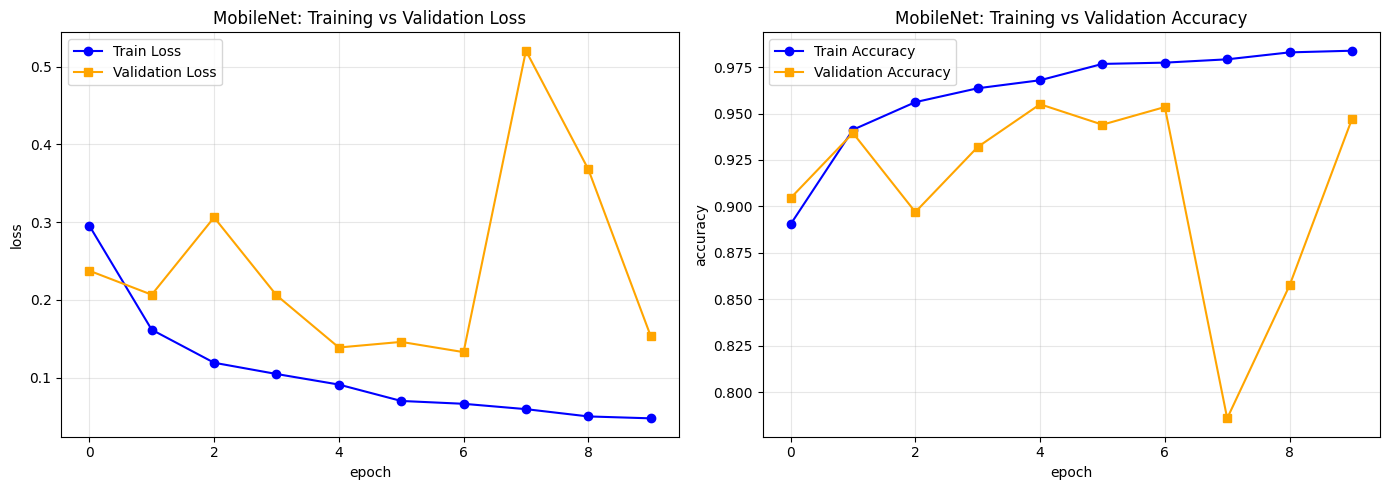

In [9]:
trainlosses = np.array([stat["trainloss"] for stat in stats_mobilenet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_mobilenet])
vallosses = np.array([stat["valloss"] for stat in stats_mobilenet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_mobilenet])
epochs = np.array([stat["epoch"] for stat in stats_mobilenet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("MobileNet: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("MobileNet: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/mobilenet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ MobileNet graph saved to outputs/mobilenet_training_curves.png")
plt.show()


✅ ResNet graph saved to outputs/resnet_training_curves.png


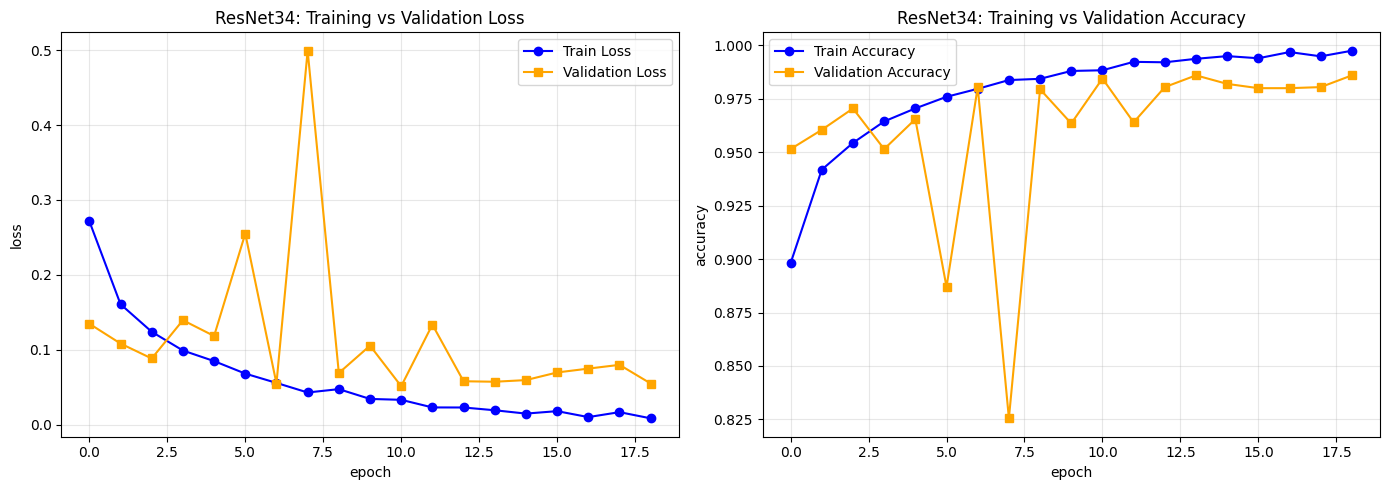

In [10]:
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
epochs = np.array([stat["epoch"] for stat in stats_resnet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ ResNet graph saved to outputs/resnet_training_curves.png")
plt.show()


## Test Set Evaluation

In [11]:
def test_epoch(test_dl, model, device):
    """Évalue le modèle sur l'ensemble de test (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():
        for batch in test_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

# Évaluer les deux modèles sur le test set
print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)

testloss_mobilenet, testaccuracy_mobilenet = test_epoch(test_loader, model_mobilenet, device)
testloss_resnet, testaccuracy_resnet = test_epoch(test_loader, model_resnet, device)

print(f"\nMobileNet - Test Loss: {testloss_mobilenet:.4f}, Test Accuracy: {testaccuracy_mobilenet*100:.2f}%")
print(f"ResNet34  - Test Loss: {testloss_resnet:.4f}, Test Accuracy: {testaccuracy_resnet*100:.2f}%")


EVALUATING ON TEST SET



MobileNet - Test Loss: 0.1173, Test Accuracy: 95.30%
ResNet34  - Test Loss: 0.0132, Test Accuracy: 99.70%



BEST EPOCHS FOUND (early stopping)
MobileNet: Best epoch was #5 (val acc: 95.50%)
ResNet34:  Best epoch was #14 (val acc: 98.60%)
(Models were saved at these epochs and are now being evaluated on test set)

FINAL COMPARISON - TRAIN / VALIDATION / TEST ACCURACIES + OVERFITTING ANALYSIS

Model           Train Acc       Val Acc         Test Acc        Overfitting Gap     
----------------------------------------------------------------------------------------------------
MobileNet               96.79%         95.50%         95.30%               1.29%
ResNet34                99.37%         98.60%         99.70%               0.77%

📊 DETAILED ANALYSIS:

❌ MobileNet Issues:
   - High overfitting gap: 1.29% (train 96.79% → val 95.50%)
   - Less stable: validation accuracy drops significantly from training

✅ ResNet34 Strengths:
   - Low overfitting gap: 0.77% (train 99.37% → val 98.60%)
   - Much more stable: validation accuracy close to training accuracy
   - Better generalization: will pe


✅ Comparison graph saved to outputs/model_comparison.png


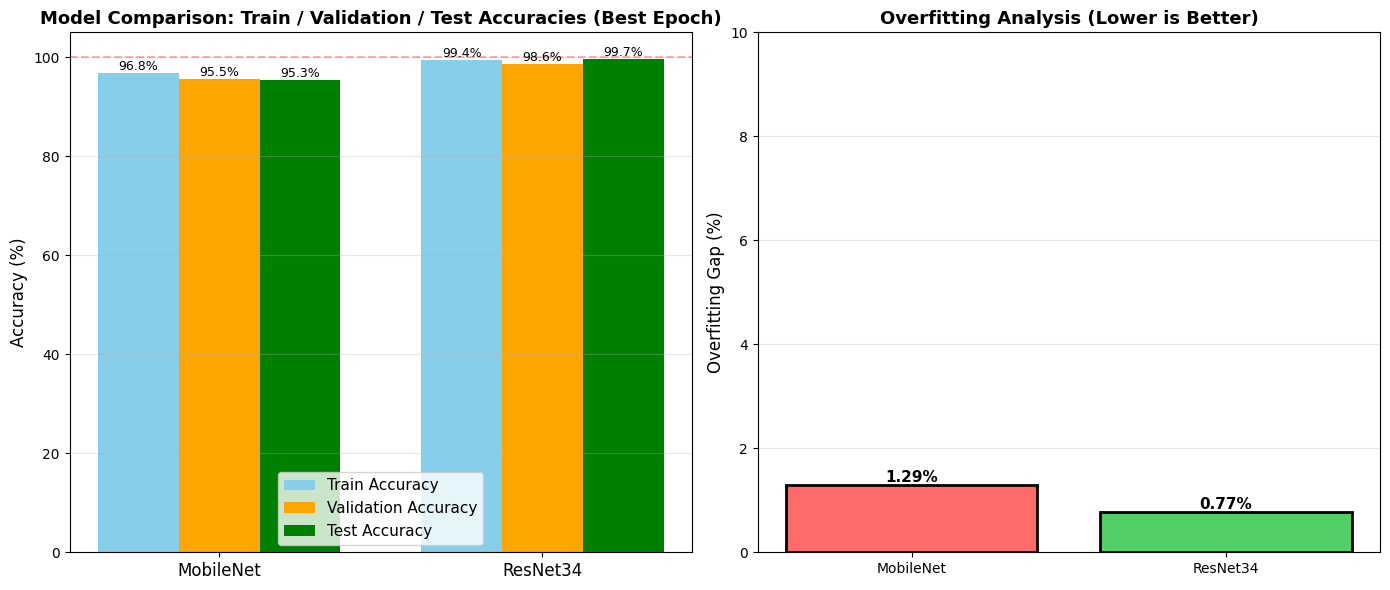

In [12]:
# ===== FIND BEST EPOCH (pas le dernier, mais le meilleur) =====
# Trouver l'epoch avec la meilleure validation accuracy
best_epoch_idx_mobilenet = np.argmax([stat["valaccuracy"] for stat in stats_mobilenet])
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])

print("\n" + "="*100)
print("BEST EPOCHS FOUND (early stopping)")
print("="*100)
print(f"MobileNet: Best epoch was #{best_epoch_idx_mobilenet+1} (val acc: {stats_mobilenet[best_epoch_idx_mobilenet]['valaccuracy']*100:.2f}%)")
print(f"ResNet34:  Best epoch was #{best_epoch_idx_resnet+1} (val acc: {stats_resnet[best_epoch_idx_resnet]['valaccuracy']*100:.2f}%)")
print(f"(Models were saved at these epochs and are now being evaluated on test set)")
print("="*100)

# Récupérer les accuracies du MEILLEUR epoch (pas du dernier)
final_trainacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["trainaccuracy"]
final_valacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["valaccuracy"]

final_trainacc_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"]
final_valacc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"]

# Calculer l'overfitting gap (train - val)
overfitting_gap_mobilenet = final_trainacc_mobilenet - final_valacc_mobilenet
overfitting_gap_resnet = final_trainacc_resnet - final_valacc_resnet

# Créer un tableau de comparaison
print("\n" + "="*100)
print("FINAL COMPARISON - TRAIN / VALIDATION / TEST ACCURACIES + OVERFITTING ANALYSIS")
print("="*100)
print(f"\n{'Model':<15} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15} {'Overfitting Gap':<20}")
print("-"*100)
print(f"{'MobileNet':<15} {final_trainacc_mobilenet*100:>13.2f}% {final_valacc_mobilenet*100:>13.2f}% {testaccuracy_mobilenet*100:>13.2f}% {overfitting_gap_mobilenet*100:>18.2f}%")
print(f"{'ResNet34':<15} {final_trainacc_resnet*100:>13.2f}% {final_valacc_resnet*100:>13.2f}% {testaccuracy_resnet*100:>13.2f}% {overfitting_gap_resnet*100:>18.2f}%")
print("="*100)

# Analyse pour choisir le meilleur modèle
# On considère le gap d'overfitting ET le test accuracy
print("\n📊 DETAILED ANALYSIS:")
print(f"\n❌ MobileNet Issues:")
print(f"   - High overfitting gap: {overfitting_gap_mobilenet*100:.2f}% (train {final_trainacc_mobilenet*100:.2f}% → val {final_valacc_mobilenet*100:.2f}%)")
print(f"   - Less stable: validation accuracy drops significantly from training")

print(f"\n✅ ResNet34 Strengths:")
print(f"   - Low overfitting gap: {overfitting_gap_resnet*100:.2f}% (train {final_trainacc_resnet*100:.2f}% → val {final_valacc_resnet*100:.2f}%)")
print(f"   - Much more stable: validation accuracy close to training accuracy")
print(f"   - Better generalization: will perform better with data augmentation")

accuracy_diff = abs(testaccuracy_resnet - testaccuracy_mobilenet) * 100
print(f"\n⚠️  Note: Test accuracies are nearly identical ({accuracy_diff:.2f}% difference)")
print(f"   This is within noise margin. ResNet34's superior stability & low overfitting")
print(f"   gap make it the better choice for the final model.")

print("\n" + "="*100)
print("🏆 BEST MODEL: ResNet34 (chosen for stability and generalization)")
print("="*100)

# Visualiser les accuracies et l'overfitting gap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Accuracies comparison
ax1 = axes[0]
models = ['MobileNet', 'ResNet34']
train_accs = [final_trainacc_mobilenet*100, final_trainacc_resnet*100]
val_accs = [final_valacc_mobilenet*100, final_valacc_resnet*100]
test_accs = [testaccuracy_mobilenet*100, testaccuracy_resnet*100]

x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, train_accs, width, label='Train Accuracy', color='skyblue')
bars2 = ax1.bar(x, val_accs, width, label='Validation Accuracy', color='orange')
bars3 = ax1.bar(x + width, test_accs, width, label='Test Accuracy', color='green')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Comparison: Train / Validation / Test Accuracies (Best Epoch)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 105])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=100, color='red', linestyle='--', alpha=0.3)

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# Subplot 2: Overfitting gap analysis
ax2 = axes[1]
gaps = [overfitting_gap_mobilenet*100, overfitting_gap_resnet*100]
colors_gap = ['#FF6B6B', '#51CF66']  # Red for high overfitting, green for low

bars = ax2.bar(models, gaps, color=colors_gap, edgecolor='black', linewidth=2)
ax2.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax2.set_title('Overfitting Analysis (Lower is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 10])
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("outputs/model_comparison.png", dpi=150, bbox_inches='tight')
print("\n✅ Comparison graph saved to outputs/model_comparison.png")
plt.show()
